# TFM Card Data

In [1]:
%load_ext dotenv
%dotenv

import pandas as pd
import numpy as np
import os
import json
import sqlite3
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager
from pathlib import Path

# Configure matplotlib to support Chinese characters using custom font
font_path = './fonts/MapleMono-NF-CN-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [prop.get_name()]
plt.rcParams['axes.unicode_minus'] = False  # Fix minus sign display

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:
# 加载中文名称映射
CN_MAP_FILE = './data/cn_merged.json'
import re

def load_cn_map(filepath):
    """加载中文名称映射"""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            cn_map = json.load(f)
        print(f"从 {filepath} 加载了 {len(cn_map)} 个中文名称映射")
        return cn_map
    except FileNotFoundError:
        print(f"警告: {filepath} 不存在")
        return {}

def strip_emoji(text):
    """移除 emoji 字符，用于 matplotlib 显示"""
    # Remove emoji and other special Unicode characters
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002702-\U000027B0"  # dingbats
        u"\U0001F900-\U0001F9FF"  # supplemental symbols
        u"\U0001FA00-\U0001FA6F"  # chess symbols
        u"\U0001FA70-\U0001FAFF"  # symbols extended
        u"\U00002600-\U000026FF"  # misc symbols
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub('', text).strip()

def get_cn_name(name, cn_map):
    """获取中文名称，如果没有则返回原名"""
    return cn_map.get(name, name)

def get_cn_name_for_plot(name, cn_map):
    """获取中文名称用于绘图（移除 emoji）"""
    cn_name = cn_map.get(name, name)
    return strip_emoji(cn_name)

def add_cn_name_column(df, name_column, cn_map):
    """为 DataFrame 添加 cn_name 列"""
    df = df.copy()
    df['cn_name'] = df[name_column].apply(lambda x: get_cn_name(x, cn_map))
    df['cn_name_plot'] = df[name_column].apply(lambda x: get_cn_name_for_plot(x, cn_map))
    return df

# 加载中文映射
CN_MAP = load_cn_map(CN_MAP_FILE)

# 测试
test_names = ['Tharsis Republic', 'EcoLine', 'Project Eden', 'Allied Bank', '🌸Weyland Yutani🌸']
print("测试中文名称映射:")
for name in test_names:
    cn = get_cn_name(name, CN_MAP)
    cn_plot = get_cn_name_for_plot(name, CN_MAP)
    print(f"  {name} -> {cn} (plot: {cn_plot})")

# 平均顺位：返回顺位用于聚合（越低越好）
def calc_weighted_score(position, players):
    """返回顺位，agg 时用贝叶斯平滑得到平均顺位。"""
    return float(position)

# 贝叶斯平均平滑：插入 n 局先验数据，小样本更稳定（参考 Bayesian average / rating）
BAYESIAN_PRIOR_N = 30  # 先验局数

def prior_mean_position(players):
    """先验期望顺位：2人局 1.5，4人局 2.5"""
    if players == 2:
        return 1.5
    if players == 3:
        return 2.0
    if players == 4:
        return 2.5
    return 2.5  # 5人局等默认

def bayesian_avg_position(total_sum, count, prior_mean=2.5, prior_n = BAYESIAN_PRIOR_N):
    """贝叶斯平滑平均顺位 = (C*prior + sum) / (C + n)"""
    if count is None or (isinstance(count, (int, float)) and count == 0):
        return prior_mean
    c = prior_n
    return (c * prior_mean + total_sum) / (c + count)

def add_bayesian_weighted_avg(df, total_col='total_weighted', count_col='count_weighted', players_col='players', prior_mean=None, prior_n=BAYESIAN_PRIOR_N):
    """在 groupby 后为 df 添加 weighted_avg_score（贝叶斯平滑）。prior_mean 若指定则覆盖按 players 的先验。"""
    df = df.copy()
    if prior_mean is not None:
        df['weighted_avg_score'] = df.apply(
            lambda r: bayesian_avg_position(r[total_col], r[count_col], prior_mean, prior_n), axis=1)
    elif players_col in df.columns:
        df['weighted_avg_score'] = df.apply(
            lambda r: bayesian_avg_position(r[total_col], r[count_col], prior_mean_position(r[players_col], prior_n)), axis=1)
    else:
        df['weighted_avg_score'] = df.apply(
            lambda r: bayesian_avg_position(r[total_col], r[count_col], 2.5, prior_n), axis=1)
    return df


从 ./data/cn_merged.json 加载了 3406 个中文名称映射
测试中文名称映射:
  Tharsis Republic -> Tharsis Republic (plot: Tharsis Republic)
  EcoLine -> EcoLine (plot: EcoLine)
  Project Eden -> 伊甸园计划 (plot: 伊甸园计划)
  Allied Bank -> 联合银行 (plot: 联合银行)
  🌸Weyland Yutani🌸 -> 🌸韦兰德-尤坦尼集团🌸 (plot: 韦兰德-尤坦尼集团)


In [3]:
# 数据加载：优先从本地 SQLite，否则从远程 PostgreSQL (只读)
# 只加载 breakthrough=true 的游戏数据
LOCAL_DB_PATH = './local_data/tfm.db'

def load_data_from_local():
    """从本地 SQLite 加载数据"""
    if not Path(LOCAL_DB_PATH).exists():
        return None, None, None

    conn = sqlite3.connect(LOCAL_DB_PATH)
    games_df = pd.read_sql('SELECT * FROM games', conn)
    game_results_df = pd.read_sql('SELECT * FROM game_results', conn)
    user_game_results_df = pd.read_sql('SELECT * FROM user_game_results', conn)
    conn.close()

    # 过滤 breakthrough=true 的游戏
    if 'game_options' in game_results_df.columns:
        breakthrough_games = game_results_df[
            game_results_df['game_options'].str.contains('"breakthrough":true', na=False)
        ]['game_id'].tolist()
        game_results_df = game_results_df[game_results_df['game_id'].isin(breakthrough_games)]
        user_game_results_df = user_game_results_df[user_game_results_df['game_id'].isin(breakthrough_games)]
        print(f"过滤 breakthrough=true 游戏: {len(breakthrough_games)} 场")

    return games_df, game_results_df, user_game_results_df

def load_data_from_pg():
    """从远程 PostgreSQL 加载数据 (只读), 只加载 breakthrough=true 的数据"""
    import pgOperation

    pg = pgOperation.PgOperation(
        ip=os.getenv('PG_HOST'),
        port=os.getenv('PG_PORT'),
        user=os.getenv('PG_USER'),
        pwd=os.getenv('PG_PASSWORD'),
        db=os.getenv('PG_DATABASE'),
        schema=os.getenv('PG_SCHEMA', 'public')
    )

    # 只读取 breakthrough=true 且 2025年以后的 game_results
    print("从 PostgreSQL 加载 breakthrough=true 数据...")
    game_results_df = pg.readSql("""
        SELECT * FROM game_results
        WHERE game_options::json->>'breakthrough' = 'true'
        AND createtime >= '2025-01-01'
    """)

    # 获取 breakthrough 游戏的 game_id 列表
    breakthrough_game_ids = game_results_df['game_id'].tolist()
    print(f"找到 breakthrough=true 游戏 (2025年): {len(breakthrough_game_ids)} 场")

    # 读取 user_game_results 并过滤
    user_game_results_df = pg.readSql("""
        SELECT * FROM user_game_results
        WHERE createtime >= '2025-01-01'
    """)
    user_game_results_df = user_game_results_df[user_game_results_df['game_id'].isin(breakthrough_game_ids)]
    print(f"user_game_results 记录: {len(user_game_results_df)} 条")

    # 转换时间格式
    game_results_df['createtime'] = pd.to_datetime(game_results_df['createtime'])
    user_game_results_df['createtime'] = pd.to_datetime(user_game_results_df['createtime'])

    # games 表需要合并多个分表，这里简化处理，不加载完整 games 表（数据量大）
    games_df = None

    return games_df, game_results_df, user_game_results_df

# 尝试加载数据
games_df, game_results_df, user_game_results_df = load_data_from_local()

if game_results_df is None:
    print("本地数据不存在，从 PostgreSQL 加载...")
    games_df, game_results_df, user_game_results_df = load_data_from_pg()
    print("从 PostgreSQL 加载数据成功 (仅 breakthrough=true)")
else:
    print("从本地 SQLite 加载数据成功 (仅 breakthrough=true)")

print(f"game_results: {len(game_results_df)} rows")
# 为 user_game_results 计算加权分数（供 combo 等分析使用）
user_game_results_df['weighted_score'] = user_game_results_df.apply(
    lambda row: calc_weighted_score(row['position'], row['players']), axis=1
)

print(f"user_game_results: {len(user_game_results_df)} rows")
if games_df is not None:
    print(f"games: {len(games_df)} rows")


过滤 breakthrough=true 游戏: 11098 场
从本地 SQLite 加载数据成功 (仅 breakthrough=true)
game_results: 11098 rows
user_game_results: 27230 rows
games: 17201 rows


## 1. Corporations

In [4]:
# 从 user_game_results 分析公司数据
# corporation 字段可能包含多个公司，用 | 分隔

def split_corporations(corp_str):
    """分割公司字符串，返回公司列表"""
    if pd.isna(corp_str) or corp_str == '':
        return []
    return [c.strip() for c in str(corp_str).split('|') if c.strip()]

# 筛选已完成的游戏
ugr_end = user_game_results_df[user_game_results_df['phase'] == 'end'].copy()
print(f"已完成游戏记录数: {len(ugr_end)}")

# 展开公司数据
corp_records = []
for _, row in ugr_end.iterrows():
    corps = split_corporations(row['corporation'])
    for corp in corps:
        corp_records.append({
            'game_id': row['game_id'],
            'user_id': row['user_id'],
            'corporation': corp,
            'position': row['position'],
            'player_score': row['player_score'],
            'players': row['players'],
            'generations': row['generations'],
            'is_rank': row.get('is_rank', 0),
            'createtime': row['createtime']
        })

corp_df = pd.DataFrame(corp_records)

# 计算加权分数
corp_df['weighted_score'] = corp_df.apply(
    lambda row: calc_weighted_score(row['position'], row['players']), axis=1
)
print(f"公司使用记录数: {len(corp_df)}")
corp_df.head()

已完成游戏记录数: 23691
公司使用记录数: 45955


game_id        user_id                  corporation  position  \
0  g237376a88be5  uf102aef4e1d1                 🌸Green Ring🌸         3   
1  g237376a88be5  uf102aef4e1d1                 🌸Thermopoli🌸         3   
2  g237376a88be5  u4352bd3577a0           🌸Green Leaf Dance🌸         2   
3  g237376a88be5  u4352bd3577a0                      Polaris         2   
4  g237376a88be5  u4d5c2567e852  🌸Integrated Microorganisms🌸         4   

   player_score  players  generations  is_rank           createtime  \
0            68        4            5        1  2025-01-01 09:07:00   
1            68        4            5        1  2025-01-01 09:07:00   
2            73        4            5        1  2025-01-01 09:07:00   
3            73        4            5        1  2025-01-01 09:07:00   
4            66        4            5        1  2025-01-01 09:07:00   

   weighted_score  
0             3.0  
1             3.0  
2             2.0  
3             2.0  
4             4.0

In [ ]:
# 1.1 公司使用率分析（按玩家人数分组）
def analyze_corporation_usage(corp_df, min_games=30):
    """分析公司使用率"""
    # 按公司和玩家人数统计
    corp_usage = corp_df.groupby(['corporation', 'players']).agg(
        total_games=('game_id', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count'),
        avg_generations=('generations', 'mean')
    ).reset_index()
    corp_usage = add_bayesian_weighted_avg(corp_usage)

    # 计算胜率
    corp_usage['win_rate'] = (corp_usage['wins'] / corp_usage['total_games'] * 100).round(2)

    # 过滤最小样本量
    corp_usage = corp_usage[corp_usage['total_games'] >= min_games]

    return corp_usage.sort_values(['players', 'weighted_avg_score'], ascending=[True, True])

corp_usage_df = analyze_corporation_usage(corp_df)
print(f"\n公司使用统计 (最小 {10} 局):")
corp_usage_df


公司使用统计 (最小 10 局):


corporation  players  total_games  wins  avg_position  \
48                    Aurorai        2           28    22      1.214286   
101            Earth Cat Cult        2           13    11      1.153846   
137         Hecate Speditions        2           15    11      1.266667   
17   Aphrodite (breakthrough)        2           89    58      1.348315   
152                  Id Front        2          116    75      1.353448   
..                        ...      ...          ...   ...           ...   
343                   Ringcom        5           13     1      3.384615   
434           Tycho Magnetics        5           13     1      3.615385   
539             🌸Shinra Tech🌸        5           11     0      3.727273   
79       Collegium Copernicus        5           13     1      3.846154   
458      Viron (breakthrough)        5           23     3      3.652174   

      avg_score  total_weighted  count_weighted  avg_generations  \
48   116.678571            34.0              28         8.071429   
101  132.461538            15.0              13         8.615385   
137  200.666667            19.0              15         9.200000   
17   130.157303           120.0              89         9.280899   
152  172.370690           157.0             116         9.853448   
..          ...             ...             ...              ...   
343   66.307692            44.0              13         5.076923   
434   63.615385            47.0              13         6.769231   
539   62.545455            41.0              11         5.272727   
79    64.615385            50.0              13         6.076923   
458   68.695652            84.0              23         6.304348   

     weighted_avg_score  win_rate  
48             1.289474     78.57  
101            1.304348     84.62  
137            1.360000     73.33  
17             1.363636     65.17  
152            1.365079     64.66  
..                  ...       ...  
343            3.000000      7.69  
434            3.130435      7.69  
539            3.142857      0.00  
79             3.260870      7.69  
458            3.303030     13.04  

[348 rows x 11 columns]

4人局公司平均顺位排行榜 (Top 20)


corporation  players  total_games  wins  \
19              Aphrodite (breakthrough)        4          165    74   
58                Brotherhood of Mutants        4           43    21   
494                   🌸Green Leaf Dance🌸        4          308   107   
116                              Eglogue        4          299    96   
112               Ecoline (breakthrough)        4          344   110   
263       MorningStar Inc (breakthrough)        4          528   191   
438                  UNMI (breakthrough)        4          194    59   
552                         🌸Thermopoli🌸        4          176    62   
342                              Ringcom        4          765   241   
482                        🌸Buy N Large🌸        4          243    78   
443           United Nations Mission One        4          399   120   
312                     PolderTECH Dutch        4          128    41   
26   Arcadian Communities (breakthrough)        4          390   122   
384                Splice (breakthrough)        4          702   215   
526                            🌸Prowler🌸        4          484   142   
530                                🌸RDA🌸        4          364   109   
376             Soylent Seedling Systems        4          184    47   
490              🌸Energy Saving Ecology🌸        4          395   119   
522                           🌸Protogen🌸        4          322    86   
154                             Id Front        4           77    27   

     avg_position  avg_score  total_weighted  count_weighted  avg_generations  \
19       1.896970  82.945455           313.0             165         6.042424   
58       1.906977  91.000000            82.0              43         6.046512   
494      2.090909  77.762987           644.0             308         5.571429   
116      2.123746  71.565217           635.0             299         5.036789   
112      2.142442  77.345930           737.0             344         5.837209   
263      2.162879  90.691288          1142.0             528         6.407197   
438      2.211340  74.938144           429.0             194         6.097938   
552      2.221591  74.375000           391.0             176         5.289773   
342      2.237908  85.343791          1712.0             765         5.790850   
482      2.246914  77.539095           546.0             243         5.559671   
443      2.253133  69.388471           899.0             399         4.398496   
312      2.242188  39.296875           287.0             128         1.531250   
26       2.258974  77.815385           881.0             390         5.748718   
384      2.264957  81.923077          1590.0             702         5.833333   
526      2.278926  77.948347          1103.0             484         5.663223   
530      2.282967  75.288462           831.0             364         5.582418   
376      2.304348  48.755435           424.0             184         2.548913   
490      2.311392  73.837975           913.0             395         5.382278   
522      2.313665  76.263975           745.0             322         5.549689   
154      2.298701  93.870130           177.0              77         7.220779   

     weighted_avg_score  win_rate                              cn_name  \
19             1.931429     44.85             Aphrodite (breakthrough)   
58             2.018868     48.84                               变种人兄弟会   
494            2.103774     34.74                               🌸绿叶舞动🌸   
116            2.135922     32.11                              Eglogue   
112            2.152542     31.98               Ecoline (breakthrough)   
263            2.169145     36.17       MorningStar Inc (breakthrough)   
438            2.225490     30.41                  UNMI (breakthrough)   
552            2.236559     35.23                               🌸精灵热舞🌸   
342            2.241290     31.50                              Ringcom   
482            2.256917     32.10                                🌸大巨购🌸   


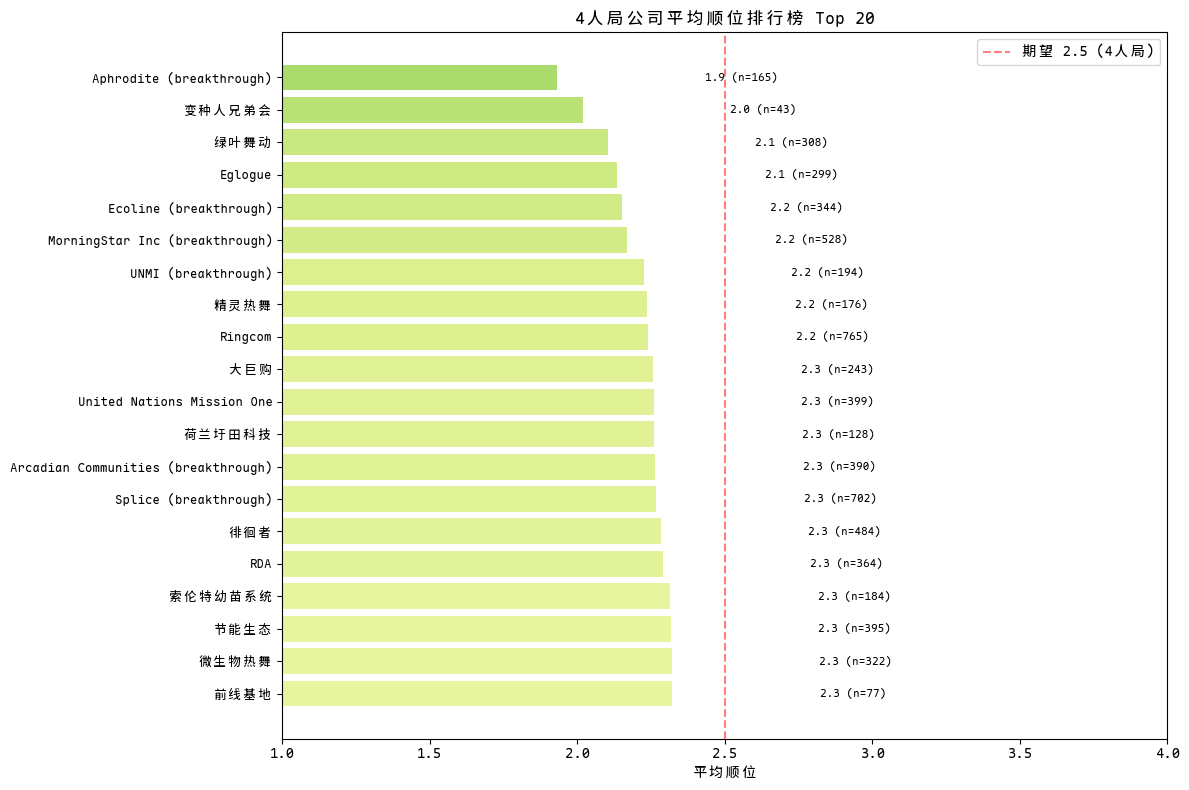

Saved: ./display/corporation_4p_weighted_mid_top20.png


In [6]:
# 1.2 公司平均顺位排行榜（4人局）
corp_4p = corp_usage_df[corp_usage_df['players'] == 4].copy()
corp_4p = add_cn_name_column(corp_4p, 'corporation', CN_MAP)
corp_4p_sorted = corp_4p.sort_values('weighted_avg_score', ascending=True)

print("=" * 60)
print("4人局公司平均顺位排行榜 (Top 20)")
print("=" * 60)
display(corp_4p_sorted.head(20))

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
top20 = corp_4p_sorted.head(20)
colors = plt.cm.RdYlGn(np.clip((4 - top20['weighted_avg_score']) / 3, 0, 1))
bars = ax.barh(range(len(top20)), top20['weighted_avg_score'], color=colors)
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(top20['cn_name_plot'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('平均顺位')
ax.axvline(x=2.5, color='red', linestyle='--', alpha=0.5, label='期望 2.5 (4人局)')
ax.legend()
ax.set_title('4人局公司平均顺位排行榜 Top 20')
ax.set_xlim(1, 4)
for bar, score, games in zip(bars, top20['weighted_avg_score'], top20['total_games']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{score:.1f} (n={games})', va='center', fontsize=8)
plt.tight_layout()
plt.savefig('./display/corporation_4p_weighted_mid_top20.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: ./display/corporation_4p_weighted_mid_top20.png")

公司使用次数排行榜 (Top 30)


corporation  total_games  wins   avg_score  \
110               Valley Trust (breakthrough)         1408   423   93.835938   
76                                 Point Luna         1304   417   99.082055   
43   Interplanetary Cinematics (breakthrough)         1167   404   88.995716   
16                    Celestic (breakthrough)         1149   376   92.632724   
99                    Teractor (breakthrough)         1106   322   92.503617   
112                                     Vitor         1073   394   97.362535   
135                          🌸Weyland Yutani🌸         1017   235   85.991150   
75                     Pobolog (breakthrough)         1009   322   92.672944   
122               🌸Integrated Microorganisms🌸          927   305   91.834951   
130                             🌸Shinra Tech🌸          919   270   91.052231   
85                                    Ringcom          903   296   92.769657   
95                      Splice (breakthrough)          896   296   89.812500   
67             MorningStar Inc (breakthrough)          875   358  104.205714   
115                                   雩喵科学探测器          841   211   85.706302   
129                       🌸Scolex Industries🌸          831   256   90.630566   
111                      Viron (breakthrough)          801   244   91.715356   
118                               🌸EliteTech🌸          797   221   83.410289   
123                             🌸Mining Corp🌸          764   205   85.363874   
94                                      Spire          754   266   92.771883   
116                                🌸Ark Nova🌸          750   217   95.817333   
80                                   Poseidon          729   204   90.386831   
81                                      Prism          712   227  103.509831   
131                              🌸SolarPlant🌸          686   225   87.230321   
57                                   Manutech          658   228   99.147416   
45                   Inventrix (breakthrough)          635   179   98.412598   
132                         🌸StarlinkDrifter🌸          625   161   91.692800   
134                                  🌸Tyrell🌸          605   160   90.504132   
127                                 🌸Prowler🌸          579   180   82.141623   
62                                      Midas          568   154   69.209507   
97     StormCraft Incorporated (breakthrough)          566   145   88.710247   

     total_weighted  count_weighted  weighted_avg_score  win_rate  \
110          3240.0            1408            2.302539     30.04   
76           3069.0            1304            2.354642     31.98   
43           2570.0            1167            2.204758     34.62   
16           2526.0            1149            2.201035     32.72   
99           2572.0            1106            2.327061     29.11   
112          2339.0            1073            2.182825     36.72   
135          2550.0            1017            2.507303     23.11   
75           2252.0            1009            2.234544     31.91   
122          2086.0             927            2.252935     32.90   
130          2105.0             919            2.292788     29.38   
85           1963.0             903            2.177437     32.78   
95           1923.0             896            2.150110     33.04   
67           1737.0             875            1.990960     40.91   
115          2116.0             841            2.515864     25.09   
129          1892.0             831            2.279429     30.81   
111          1854.0             801            2.316893     30.46   
118          1952.0             797            2.449814     27.73   
123          1852.0             764            2.425065     26.83   
94           1663.0             754            2.209424     35.28   
116          1799.0             750            2.400000     28.93   
80           1730.0             729            2.374831     27.98   
81           1702.0             712

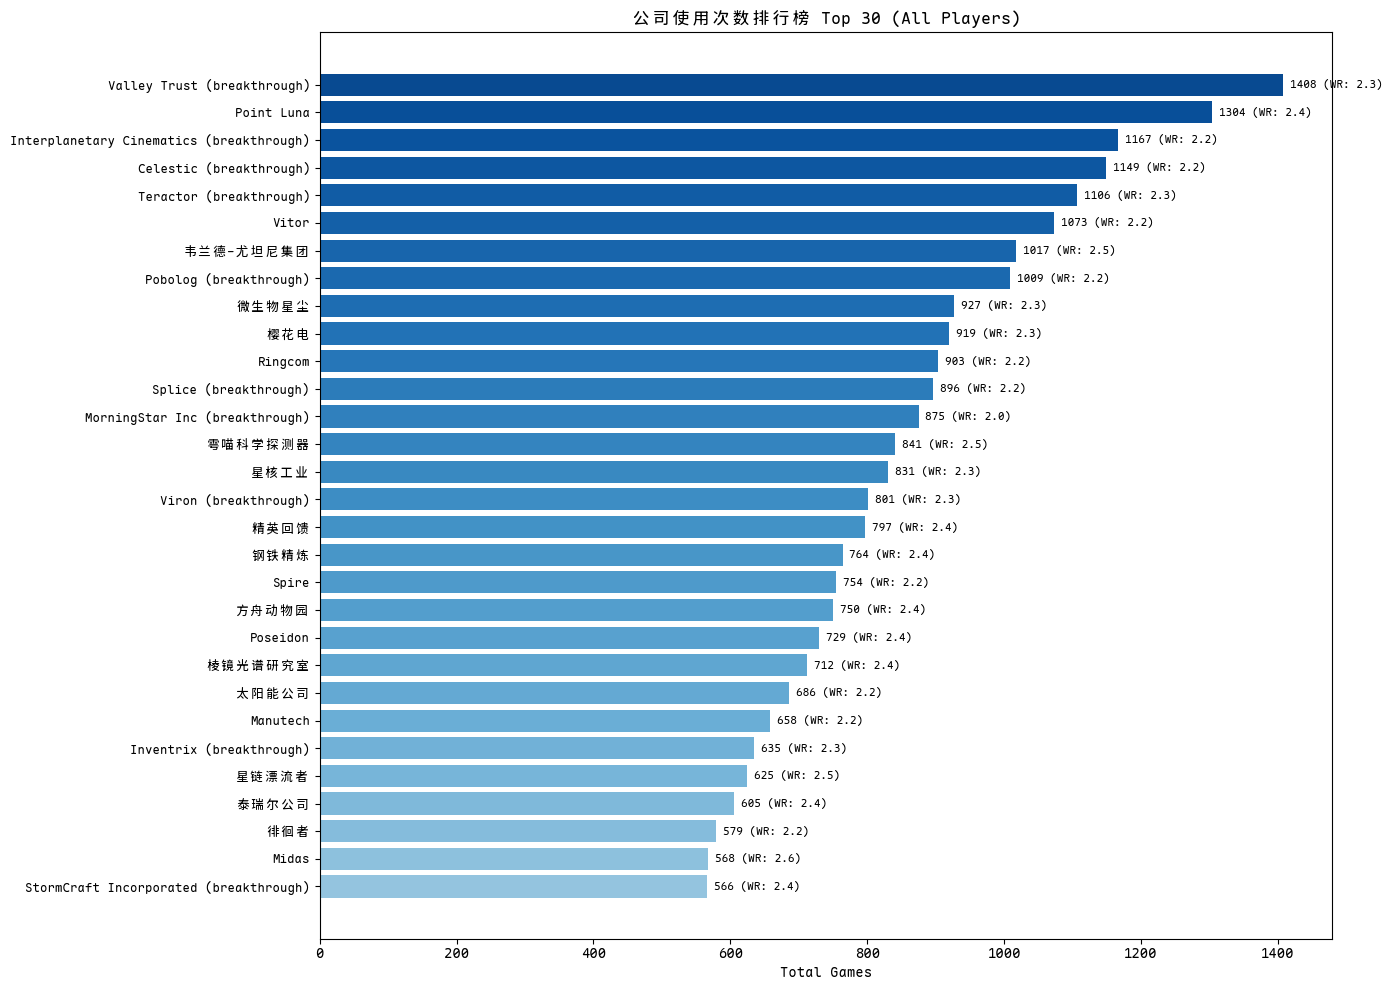

Saved: ./display/corporation_popularity_mid_top30.png


In [7]:
# 1.3 公司使用次数排行
corp_popular = corp_df.groupby('corporation').agg(
    total_games=('game_id', 'count'),
    wins=('position', lambda x: (x == 1).sum()),
    avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
).reset_index()
corp_popular = add_bayesian_weighted_avg(corp_popular)

corp_popular['win_rate'] = (corp_popular['wins'] / corp_popular['total_games'] * 100).round(2)
corp_popular = corp_popular.sort_values('total_games', ascending=False)
corp_popular = add_cn_name_column(corp_popular, 'corporation', CN_MAP)

print("=" * 60)
print("公司使用次数排行榜 (Top 30)")
print("=" * 60)
display(corp_popular.head(30))

# Visualization
fig, ax = plt.subplots(figsize=(14, 10))
top30 = corp_popular.head(30)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top30)))[::-1]
bars = ax.barh(range(len(top30)), top30['total_games'], color=colors)
ax.set_yticks(range(len(top30)))
ax.set_yticklabels(top30['cn_name_plot'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Total Games')
ax.set_title('公司使用次数排行榜 Top 30 (All Players)')
for bar, games, ws in zip(bars, top30['total_games'], top30['weighted_avg_score']):
    ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
            f'{games} (WR: {ws:.1f})', va='center', fontsize=8)
plt.tight_layout()
plt.savefig('./display/corporation_popularity_mid_top30.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: ./display/corporation_popularity_mid_top30.png")

双公司组合平均顺位排行榜 (Top 20)


combination  total_games  wins  \
140   Aphrodite (breakthrough) + MorningStar Inc (br...           29    16   
168      Aphrodite (breakthrough) + UNMI (breakthrough)           21    13   
2997                                    Ringcom + Vitor           29    18   
2033             Lakefront Resorts + 🌸Green Leaf Dance🌸           21    13   
1588                                   Id Front + Prism           12    10   
1184                             EcoTec + 🌸Buy N Large🌸           27    16   
66             Ambient + MorningStar Inc (breakthrough)           48    24   
160    Aphrodite (breakthrough) + Splice (breakthrough)           10     8   
3283  Splice (breakthrough) + 🌸Integrated Microorgan...          107    52   
122   Aphrodite (breakthrough) + Ecoline (breakthrough)           13     8   
1786  Interplanetary Cinematics (breakthrough) + UNM...           14     8   
3510   UNMI (breakthrough) + United Nations Mission One           29    13   
542                       Aurorai + UNMI (breakthrough)           10     8   
40                   Ambient + Aphrodite (breakthrough)           20    11   
3693                          🌸Ark Nova🌸 + 🌸MirrorCoat🌸           20    13   
3746      🌸Energy Saving Ecology🌸 + 🌸Scolex Industries🌸           12     8   
694                     Celestic (breakthrough) + Vitor           53    28   
1607                                   Id Front + Vitor            7     6   
2588                      Philares + 🌸Green Leaf Dance🌸            7     6   
1301                       Eglogue + 🌸Green Leaf Dance🌸           25    13   

      avg_position   avg_score  total_weighted  count_weighted  \
140       1.517241  108.379310            44.0              29   
168       1.428571  114.761905            30.0              21   
2997      1.551724   97.551724            45.0              29   
2033      1.476190   73.190476            31.0              21   
1588      1.250000  269.166667            15.0              12   
1184      1.592593   85.703704            43.0              27   
66        1.708333   99.937500            82.0              48   
160       1.200000  104.100000            12.0              10   
3283      1.803738  102.953271           193.0             107   
122       1.384615   80.769231            18.0              13   
1786      1.428571   97.785714            20.0              14   
3510      1.689655   92.103448            49.0              29   
542       1.300000   89.800000            13.0              10   
40        1.600000   97.450000            32.0              20   
3693      1.600000   95.000000            32.0              20   
3746      1.416667   90.666667            17.0              12   
694       1.811321  108.169811            96.0              53   
1607      1.142857  159.285714             8.0               7   
2588      1.142857  107.857143             8.0               7   
1301      1.720000   73.200000            43.0              25   

      weighted_avg_score  win_rate  \
140             1.769231     55.17   
168             1.774194     61.90   
2997            1.794872     62.07   
2033            1.806452     61.90   
1588            1.818182     83.33   
1184            1.837838     59.26   
66              1.844828     50.00   
160             1.850000     80.00   
3283            1.863248     48.60   
122             1.869565     61.54   
1786            1.875000     57.14   
3510            1.897436     44.83   
542             1.900000     80.00   
40              1.900000     55.00   
3693            1.900000     65.00   
3746            1.909091     66.67   
694             1.920635     52.83   
1607            1.941176     85.71   
2588            1.941176     85.71   
1301            1.942857     52.00   

                                           cn_name_plot  
140   Aphrodite (breakthrough) + MorningStar Inc (br...  
168      Aphrodite (breakthrough) + UNMI (breakthrough)  
2997                                    Ringc

/var/folders/kt/jh5yr5kn50v_xx9qcjdrw3p40000gn/T/ipykernel_68495/1053735539.py:70: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Maple Mono NF CN.
  plt.tight_layout()
/var/folders/kt/jh5yr5kn50v_xx9qcjdrw3p40000gn/T/ipykernel_68495/1053735539.py:71: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Maple Mono NF CN.
  plt.savefig('./display/corporation_combo_mid_top20.png', dpi=150, bbox_inches='tight')
/Users/oushuohuang/Documents/tfm-data/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Maple Mono NF CN.
  fig.canvas.print_figure(bytes_io, **kw)


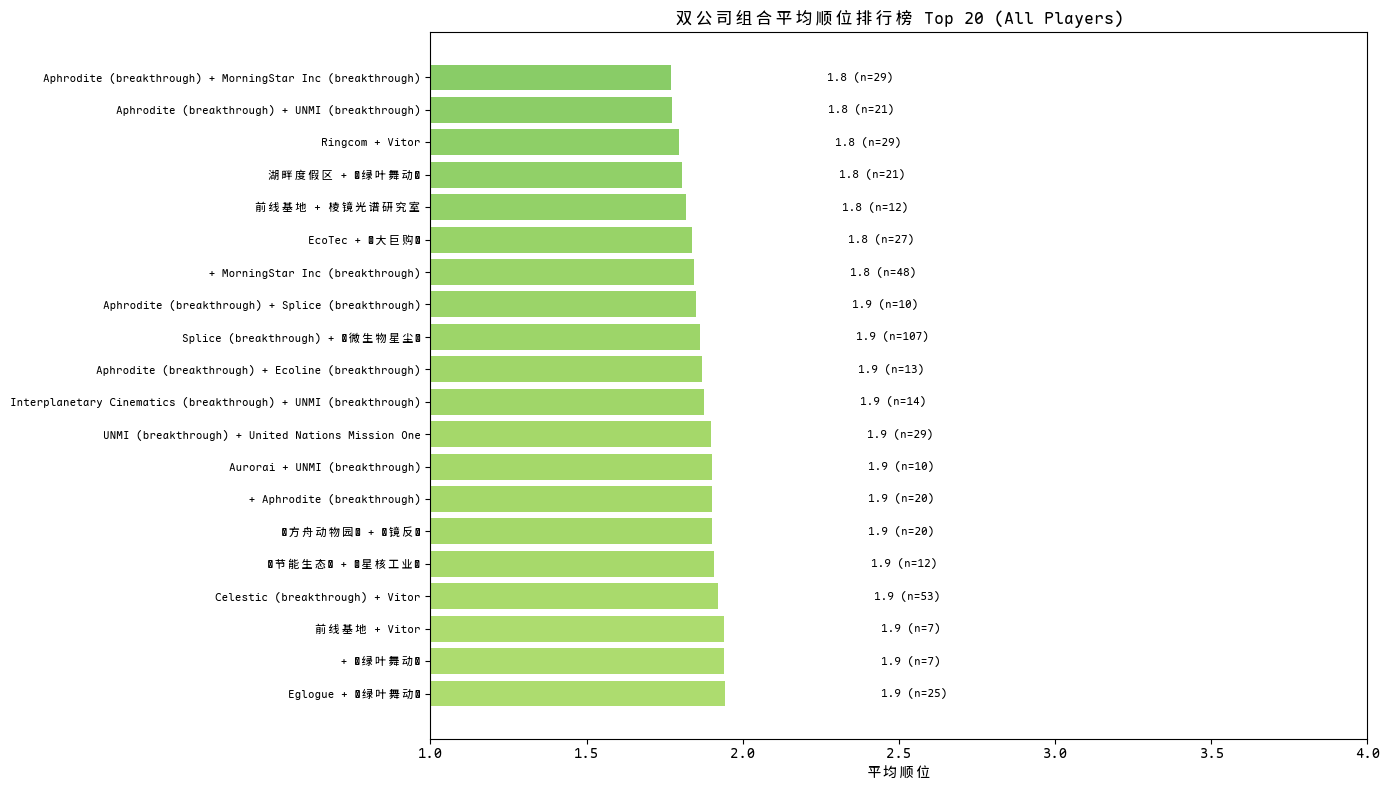

Saved: ./display/corporation_combo_mid_top20.png


In [8]:
# 1.4 双公司组合分析
def analyze_corp_combinations(ugr_df, min_games=5):
    """分析双公司组合"""
    combo_records = []

    for _, row in ugr_df[ugr_df['phase'] == 'end'].iterrows():
        corps = split_corporations(row['corporation'])
        if len(corps) >= 2:
            # 排序以确保组合唯一性
            combo = ' + '.join(sorted(corps[:2]))
            combo_records.append({
                'combination': combo,
                'corp1': sorted(corps[:2])[0],
                'corp2': sorted(corps[:2])[1],
                'position': row['position'],
                'player_score': row['player_score'],
                'players': row['players'],
                'generations': row['generations'],
                'weighted_score': calc_weighted_score(row['position'], row['players'])
            })

    if not combo_records:
        return pd.DataFrame()

    combo_df = pd.DataFrame(combo_records)

    # 统计组合表现
    combo_stats = combo_df.groupby('combination').agg(
        total_games=('position', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
    ).reset_index()
    combo_stats = add_bayesian_weighted_avg(combo_stats)

    combo_stats['win_rate'] = (combo_stats['wins'] / combo_stats['total_games'] * 100).round(2)
    combo_stats = combo_stats[combo_stats['total_games'] >= min_games]

    return combo_stats.sort_values('weighted_avg_score', ascending=True)

corp_combo_df = analyze_corp_combinations(user_game_results_df)
if len(corp_combo_df) > 0:
    # Add cn_name column for combinations
    def get_combo_cn_name(combo):
        parts = combo.split(' + ')
        cn_parts = [CN_MAP.get(p, p) for p in parts]
        return ' + '.join(cn_parts)
    corp_combo_df['cn_name_plot'] = corp_combo_df['combination'].apply(get_combo_cn_name)

    print("=" * 60)
    print("双公司组合平均顺位排行榜 (Top 20)")
    print("=" * 60)
    display(corp_combo_df.head(20))

    # Visualization
    fig, ax = plt.subplots(figsize=(14, 8))
    top20 = corp_combo_df.head(20)
    colors = plt.cm.RdYlGn(np.clip((4 - top20['weighted_avg_score']) / 3, 0, 1))
    bars = ax.barh(range(len(top20)), top20['weighted_avg_score'], color=colors)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['cn_name_plot'], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('平均顺位')
    ax.set_title('双公司组合平均顺位排行榜 Top 20 (All Players)')
    ax.set_xlim(1, 4)
    for bar, score, games in zip(bars, top20['weighted_avg_score'], top20['total_games']):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{score:.1f} (n={games})', va='center', fontsize=8)
    plt.tight_layout()
    plt.savefig('./display/corporation_combo_mid_top20.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: ./display/corporation_combo_mid_top20.png")
else:
    print("未找到足够的双公司组合数据")

## 2. 前序卡分析 (Preludes)

前序卡数据需要从 `games.game` JSON 中提取：
- `players[].dealtPreludeCards` - 发到的前序牌
- `players[].playedCards` - 已打出卡牌（包含前序）

In [9]:
# 从 data/ 读取排除列表
# prelude, corporation, ceo 都需要从 project card 统计中排除

PRELUDE_FILE = './data/prelude_clean.txt'
CORPORATION_FILE = './data/corporation_clean.txt'
CEO_FILE = './data/ceo_clean.txt'

def load_card_set(filepath, card_type):
    """从文件加载卡牌集合"""
    cards = set()
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                name = line.strip()
                if name:
                    cards.add(name)
        print(f"从 {filepath} 加载了 {len(cards)} 种 {card_type}")
    except FileNotFoundError:
        print(f"警告: {filepath} 不存在，使用空 {card_type} 集合")
    return cards

# 加载 prelude, corporation, ceo 集合
KNOWN_PRELUDES = load_card_set(PRELUDE_FILE, 'prelude')
KNOWN_CORPORATIONS = load_card_set(CORPORATION_FILE, 'corporation')
KNOWN_CEOS = load_card_set(CEO_FILE, 'ceo')
print(f"Prelude 样例: {list(KNOWN_PRELUDES)[:5]}")
print(f"Corporation 样例: {list(KNOWN_CORPORATIONS)[:5]}")
print(f"CEO 样例: {list(KNOWN_CEOS)[:5]}")

def is_prelude(card_name):
    """判断是否为前序卡（基于预定义列表）"""
    return card_name in KNOWN_PRELUDES

def is_corporation(card_name):
    """判断是否为公司卡（基于预定义列表）"""
    return card_name in KNOWN_CORPORATIONS

def is_ceo(card_name):
    """判断是否为 CEO 卡（基于预定义列表）"""
    return card_name in KNOWN_CEOS



从 ./data/prelude_clean.txt 加载了 118 种 prelude
从 ./data/corporation_clean.txt 加载了 162 种 corporation
从 ./data/ceo_clean.txt 加载了 37 种 ceo
Prelude 样例: ['Intellectual Property Theft', 'Ecology Experts', 'Tunneling Operation', 'Deepwater Dome', 'Corridors of Power']
Corporation 样例: ['Mars Maths', 'Polyphemos (breakthrough)', 'Henkei Genetics', 'Thorgate', 'EcoLine']
CEO 样例: ['Karen', 'Rogers', 'Caesar', 'Ingrid', 'Shara']


In [10]:
# 从 games 表提取前序数据（如果 games_df 可用）
def extract_prelude_data(games_df, user_game_results_df):
    """从 games JSON 中提取前序卡数据"""
    if games_df is None or len(games_df) == 0:
        print("games 数据不可用，无法提取前序卡详细数据")
        return pd.DataFrame()

    prelude_records = []

    for _, row in games_df.iterrows():
        try:
            game_data = row['game']
            if isinstance(game_data, str):
                game_data = json.loads(game_data)

            game_id = row['game_id']

            for player in game_data.get('players', []):
                user_id = player.get('userId', '')
                player_name = player.get('name', '')

                # 从 playedCards 中提取前序
                played_cards = player.get('playedCards', [])
                for card in played_cards:
                    card_name = card.get('name', '')
                    if is_prelude(card_name):
                        prelude_records.append({
                            'game_id': game_id,
                            'user_id': user_id,
                            'player_name': player_name,
                            'prelude_name': card_name
                        })
        except Exception as e:
            continue

    if not prelude_records:
        return pd.DataFrame()

    prelude_df = pd.DataFrame(prelude_records)

    # 关联 user_game_results 获取胜负信息
    ugr_end = user_game_results_df[user_game_results_df['phase'] == 'end'][
        ['game_id', 'user_id', 'position', 'player_score', 'players', 'generations']
    ]

    prelude_df = prelude_df.merge(
        ugr_end,
        on=['game_id', 'user_id'],
        how='left'
    )

    # 计算加权分数
    prelude_df['weighted_score'] = prelude_df.apply(
        lambda row: calc_weighted_score(row['position'], row['players']), axis=1
    )

    return prelude_df

prelude_df = extract_prelude_data(games_df, user_game_results_df)
if len(prelude_df) > 0:
    print(f"提取到前序卡使用记录: {len(prelude_df)}")
    display(prelude_df.head(10))
else:
    print("无前序卡数据（需要 games 表的详细数据）")

提取到前序卡使用记录: 112029


game_id       user_id     player_name        prelude_name  position  \
0  g10030c944bf6  cec0e3f37580          hikaru              Mohole       2.0   
1  g10030c944bf6  cec0e3f37580          hikaru  Early Colonization       2.0   
2  g10030c944bf6  addb298f4557              风风       Soil Bacteria       1.0   
3  g10030c944bf6  addb298f4557              风风         Space Lanes       1.0   
4  g10030c944bf6  8068f8baa976          raaaay      Venus Contract       4.0   
5  g10030c944bf6  8068f8baa976          raaaay    Aquifer Turbines       4.0   
6  g10030c944bf6  c4f6ba391723            liyo    Power Generation       3.0   
7  g10030c944bf6  c4f6ba391723            liyo         Double Down       3.0   
8  g1004d7e6d1f8                许壮( •̀ ω •́ )y         Space Lanes       NaN   
9  g1004d7e6d1f8                许壮( •̀ ω •́ )y            Donation       NaN   

   player_score  players  generations  weighted_score  
0          79.0      4.0          6.0             2.0  
1          79.0      4.0          6.0             2.0  
2          80.0      4.0          6.0             1.0  
3          80.0      4.0          6.0             1.0  
4          64.0      4.0          6.0             4.0  
5          64.0      4.0          6.0             4.0  
6          66.0      4.0          6.0             3.0  
7          66.0      4.0          6.0             3.0  
8           NaN      NaN          NaN             NaN  
9           NaN      NaN          NaN             NaN

前序卡平均顺位排行榜


prelude_name  total_uses  wins  avg_position   avg_score  \
59                     Merger        1678   238      1.772257  130.378882   
77               Project Eden        1514   266      1.900164   90.841244   
107            WG Partnership         227    60      1.864000  107.400000   
80             Research Grant         180    44      1.869565  138.945652   
91    Suitable Infrastructure        1393   258      1.925249  108.325581   
88              Soil Bacteria        1280   260      1.930034   99.544369   
62             Mining Complex          32    12      1.791667  137.500000   
87            Society Support         559    19      1.920000  108.200000   
56      Lunar Planning Office          41    11      1.846154  153.769231   
52          Inherited Fortune          40     8      1.714286  100.571429   
95          Terraforming Deal        1357   198      2.051587   93.940476   
108  World Government Advisor        1139   202      2.057540   83.632937   
66           Nitrate Reducers         446   126      2.055016  105.446602   
12          Biosphere Support         445    33      2.024390   92.451220   
57        Main Belt Asteroids         597    41      2.044248  105.221239   
67          Nitrogen Shipment         527    33      2.026316  106.855263   
26             Deepwater Dome          29     7      1.785714  104.714286   
21                  Core Mine          41    10      1.920000  116.320000   
64                     Mohole         595    19      2.037037   86.074074   
89                Space Lanes        1772   247      2.092669  107.690180   

     total_weighted  count_weighted  avg_generations  weighted_avg_score  \
59            856.0             483         8.792961            1.787018   
77           1161.0             611         6.360065            1.909823   
107           233.0             125         7.592000            1.911111   
80            172.0              92         8.597826            1.931373   
91           1159.0             602         7.260797            1.934641   
88           1131.0             586         6.945392            1.939597   
62             43.0              24         9.541667            2.000000   
87             96.0              50         9.200000            2.016667   
56             48.0              26         9.346154            2.027778   
52             24.0              14         7.000000            2.041667   
95           1034.0             504         6.922619            2.060311   
108          1037.0             504         6.365079            2.066148   
66            635.0             309         7.579288            2.068966   
12            166.0              82         7.939024            2.076087   
57            231.0             113         8.601770            2.081301   
67            154.0              76         8.578947            2.081395   
26             25.0              14         8.000000            2.083333   
21             48.0              25         8.760000            2.085714   
64            165.0              81         8.037037            2.087912   
89           1513.0             723         7.506224            2.098226   

     win_rate  cn_name cn_name_plot  
59      14.18     企业合并         企业合并  
77      17.57    伊甸园计划        伊甸园计划  
107     26.43  世界政府小伙伴      世界政府小伙伴  
80      24.44     研发资助         研发资助  
91      18.52   适宜基础设施       适宜基础设施  
88      20.31     土壤细菌         土壤细菌  
62      37.50    矿业综合体        矿业综合体  
87       3.40     社会支援         社会支援  
56      26.83  月球规划办公室      月球规划办公室  
52      20.00    继承的财富        继承的财富  
95      14.59    地球化交易        地球化交易  
108     17.73   世界政府顾问       世界政府顾问  
66      28.25   硝酸盐还原剂       硝酸盐还原剂  
12       7.42  生物圈支援载体      生物圈支援载体  
57       6.87    主带小行星        主带小行星  
67       6.26     氮气运输         氮气运输  
26      24.14     深水穹顶         深水穹顶  
21      24.39      核地雷          核地雷  
64       3.19     超深钻探         超深钻探  
89      13.94     太空航道         太空航道

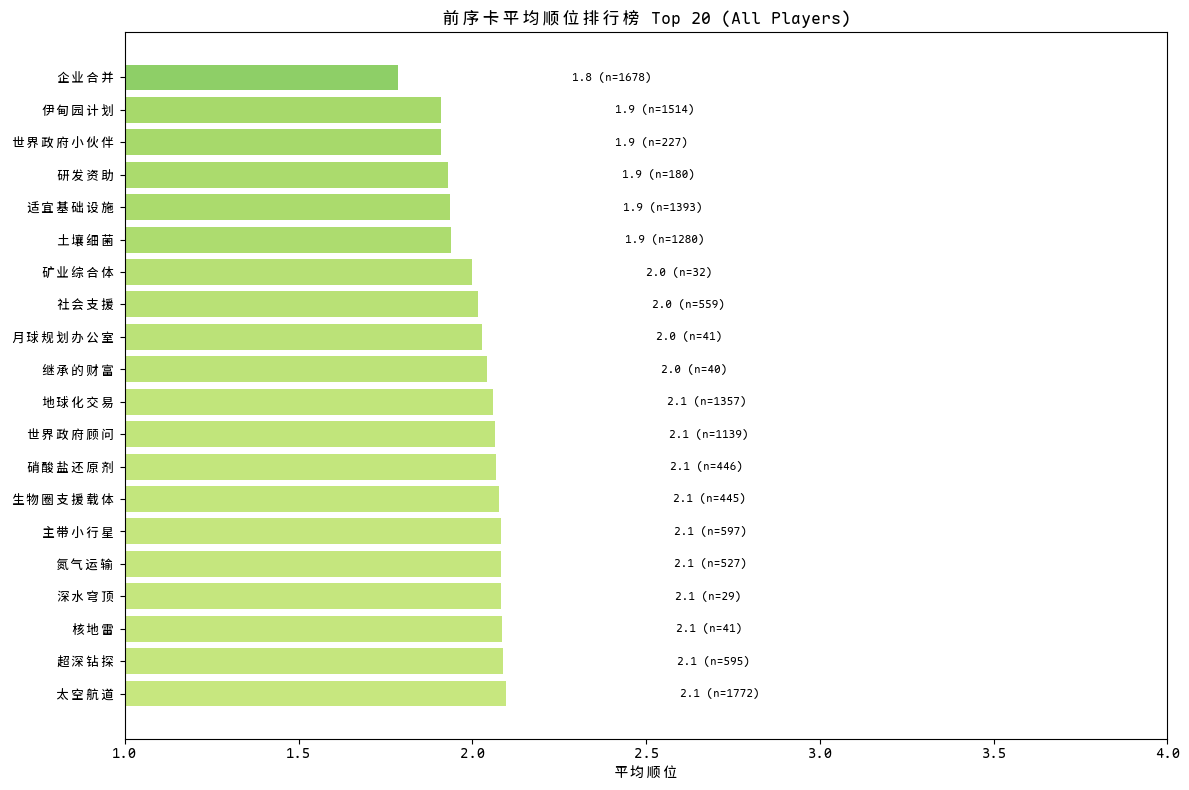

Saved: ./display/prelude_weighted_all_top20.png


In [11]:
# 2.1 前序卡使用率和胜率分析
def analyze_prelude_stats(prelude_df, min_games=10):
    """分析前序卡使用率和胜率"""
    if prelude_df is None or len(prelude_df) == 0:
        return pd.DataFrame()

    prelude_stats = prelude_df.groupby('prelude_name').agg(
        total_uses=('game_id', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count'),
        avg_generations=('generations', 'mean')
    ).reset_index()
    prelude_stats = add_bayesian_weighted_avg(prelude_stats)

    prelude_stats['win_rate'] = (prelude_stats['wins'] / prelude_stats['total_uses'] * 100).round(2)
    prelude_stats = prelude_stats[prelude_stats['total_uses'] >= min_games]

    return prelude_stats.sort_values('weighted_avg_score', ascending=True)

if len(prelude_df) > 0:
    prelude_stats_df = analyze_prelude_stats(prelude_df)
    prelude_stats_df = add_cn_name_column(prelude_stats_df, 'prelude_name', CN_MAP)
    print("=" * 60)
    print("前序卡平均顺位排行榜")
    print("=" * 60)
    display(prelude_stats_df.head(20))

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    top20 = prelude_stats_df.head(20)
    colors = plt.cm.RdYlGn(np.clip((4 - top20['weighted_avg_score']) / 3, 0, 1))
    bars = ax.barh(range(len(top20)), top20['weighted_avg_score'], color=colors)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['cn_name_plot'], fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('平均顺位')
    ax.set_xlim(1, 4)
    ax.set_title('前序卡平均顺位排行榜 Top 20 (All Players)')
    for bar, score, uses in zip(bars, top20['weighted_avg_score'], top20['total_uses']):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{score:.1f} (n={uses})', va='center', fontsize=8)
    plt.tight_layout()
    plt.savefig('./display/prelude_weighted_all_top20.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: ./display/prelude_weighted_all_top20.png")

## 3. 打出的卡牌分析 (Played Cards)

从 `games.game` JSON 中提取 `players[].playedCards` 数据

In [12]:
# 从 games 表提取卡牌数据
def extract_played_cards(games_df, user_game_results_df):
    """从 games JSON 中提取已打出卡牌数据"""
    if games_df is None or len(games_df) == 0:
        print("games 数据不可用，无法提取卡牌详细数据")
        return pd.DataFrame()

    card_records = []

    for _, row in games_df.iterrows():
        try:
            game_data = row['game']
            if isinstance(game_data, str):
                game_data = json.loads(game_data)

            game_id = row['game_id']

            for player in game_data.get('players', []):
                user_id = player.get('userId', '')
                player_name = player.get('name', '')
                tr = player.get('terraformRating', 0)

                # 获取公司信息
                corporations = player.get('corporations', [])
                corp_names = [c.get('name', '') for c in corporations]

                # 提取所有打出的卡牌
                played_cards = player.get('playedCards', [])
                for card in played_cards:
                    card_name = card.get('name', '')
                    resource_count = card.get('resourceCount', 0)

                    card_records.append({
                        'game_id': game_id,
                        'user_id': user_id,
                        'player_name': player_name,
                        'card_name': card_name,
                        'resource_count': resource_count,
                        'terraform_rating': tr,
                        'corporation': '|'.join(corp_names),
                        'is_prelude': is_prelude(card_name),
                        'is_corporation': is_corporation(card_name),
                        'is_ceo': is_ceo(card_name)
                    })
        except Exception as e:
            continue

    if not card_records:
        return pd.DataFrame()

    card_df = pd.DataFrame(card_records)

    # 关联 user_game_results 获取胜负信息
    ugr_end = user_game_results_df[user_game_results_df['phase'] == 'end'][
        ['game_id', 'user_id', 'position', 'player_score', 'players', 'generations']
    ]

    card_df = card_df.merge(
        ugr_end,
        on=['game_id', 'user_id'],
        how='left'
    )

    # 计算加权分数
    card_df['weighted_score'] = card_df.apply(
        lambda row: calc_weighted_score(row['position'], row['players']), axis=1
    )

    return card_df

played_cards_df = extract_played_cards(games_df, user_game_results_df)
if len(played_cards_df) > 0:
    print(f"提取到卡牌使用记录: {len(played_cards_df)}")
    print(f"唯一卡牌数: {played_cards_df['card_name'].nunique()}")
    display(played_cards_df.head(10))
else:
    print("无卡牌数据（需要 games 表的详细数据）")

提取到卡牌使用记录: 2168102
唯一卡牌数: 1071


game_id       user_id player_name                 card_name  \
0  g10030c944bf6  cec0e3f37580      hikaru                    Mohole   
1  g10030c944bf6  cec0e3f37580      hikaru        Early Colonization   
2  g10030c944bf6  cec0e3f37580      hikaru           Martian Fencing   
3  g10030c944bf6  cec0e3f37580      hikaru    Subterranean Reservoir   
4  g10030c944bf6  cec0e3f37580      hikaru          Deimos Down:ares   
5  g10030c944bf6  cec0e3f37580      hikaru          Bribed Committee   
6  g10030c944bf6  cec0e3f37580      hikaru  Technology Demonstration   
7  g10030c944bf6  cec0e3f37580      hikaru        Desperate Measures   
8  g10030c944bf6  cec0e3f37580      hikaru                       Cow   
9  g10030c944bf6  cec0e3f37580      hikaru   Colonizer Training Camp   

   resource_count  terraform_rating  \
0               0                44   
1               0                44   
2               0                44   
3               0                44   
4               0                44   
5               0                44   
6               0                44   
7               0                44   
8               7                44   
9               0                44   

                                         corporation  is_prelude  \
0  United Nations Mission One|Interplanetary Cine...        True   
1  United Nations Mission One|Interplanetary Cine...        True   
2  United Nations Mission One|Interplanetary Cine...       False   
3  United Nations Mission One|Interplanetary Cine...       False   
4  United Nations Mission One|Interplanetary Cine...       False   
5  United Nations Mission One|Interplanetary Cine...       False   
6  United Nations Mission One|Interplanetary Cine...       False   
7  United Nations Mission One|Interplanetary Cine...       False   
8  United Nations Mission One|Interplanetary Cine...       False   
9  United Nations Mission One|Interplanetary Cine...       False   

   is_corporation  is_ceo  position  player_score  players  generations  \
0           False   False       2.0          79.0      4.0          6.0   
1           False   False       2.0          79.0      4.0          6.0   
2           False   False       2.0          79.0      4.0          6.0   
3           False   False       2.0          79.0      4.0          6.0   
4           False   False       2.0          79.0      4.0          6.0   
5           False   False       2.0          79.0      4.0          6.0   
6           False   False       2.0          79.0      4.0          6.0   
7           False   False       2.0          79.0      4.0          6.0   
8           False   False       2.0          79.0      4.0          6.0   
9           False   False       2.0          79.0      4.0          6.0   

   weighted_score  
0             2.0  
1             2.0  
2             2.0  
3             2.0  
4             2.0  
5             2.0  
6             2.0  
7             2.0  
8             2.0  
9             2.0

项目卡平均顺位排行榜 (Top 30，打出次数>100)


card_name  play_count  game_count  wins  \
588        Sinus Irdium Road Network         114         114    42   
114                 Copernicus Tower         106         106    39   
366             Luna Staging Station         112         112    46   
365                      Luna Senate         104         104    43   
374          Lunar Mine Urbanization         119         119    48   
598                    Social Events         673         673   245   
136        Darkside Mining Syndicate         165         165    53   
112                 Coordinated Raid         600         600   174   
710           Underground Detonators         149         149    62   
175                  Ecological Zone        3396        3396   235   
356                    Luna Archives         123         123    41   
138        Darkside Smugglers' Union         175         175    56   
461  New Colony Planning Initiatives         113         113    43   
334              L.T.F. Headquarters         108         108    41   
390               Mare Nectaris Mine         163         163    55   
389                Mare Imbrium Mine         175         175    60   
367               Luna Trade Station         116         116    43   
385  Magnetic Field Generators:promo        1227        1227   124   
13       Aerobraked Ammonia Asteroid        2041        2041   214   
89                        City Parks        1986        1986   422   
392            Mare Serenitatis Mine         142         142    44   
682                     Thorium Rush         148         148    49   
260                     HE3 Refinery         133         133    48   
373           Lunar Industry Complex         158         158    52   
247               Grand Luna Academy         105         105    38   
235                   Geodesic Tents         112         112    43   
520             Preliminary Darkside         160         160    55   
161                Diversity Support        1863        1863   421   
144                Deep Lunar Mining         140         140    49   
74                           Capital        3078        3078   164   

     avg_position   avg_score  total_weighted  count_weighted  avg_resources  \
588      1.493151  180.589041           109.0              73       0.000000   
114      1.492308  191.169231            97.0              65       0.509434   
366      1.513514  180.351351           112.0              74       0.000000   
365      1.513889  185.569444           109.0              72       0.000000   
374      1.539474  182.526316           117.0              76       0.000000   
598      1.631944  166.162037           705.0             432       0.000000   
136      1.571429  169.047619           165.0             105       0.000000   
112      1.663580  165.503086           539.0             324       0.000000   
710      1.633028  161.321101           178.0             109       0.000000   
175      1.699346  127.790850           780.0             459       7.586867   
356      1.620253  176.354430           128.0              79       6.300813   
138      1.653846  169.500000           172.0             104       0.000000   
461      1.637500  177.025000           131.0              80       0.000000   
334      1.630137  171.342466           119.0              73       0.000000   
390      1.663551  169.757009           178.0             107       0.000000   
389      1.675439  162.429825           191.0             114       0.000000   
367      1.643836  180.150685           120.0              73       0.000000   
385      1.717131  142.103586           431.0             251       0.000000   
13       1.733645  164.850467           742.0             428       0.000000   
89       1.742958  133.220657          1485.0             852       0.000000   
392      1.673684  148.926316           159.0              95       0.000000   
682      1.677083  155.489583           161.0              96       0.000000   
260      1.67058

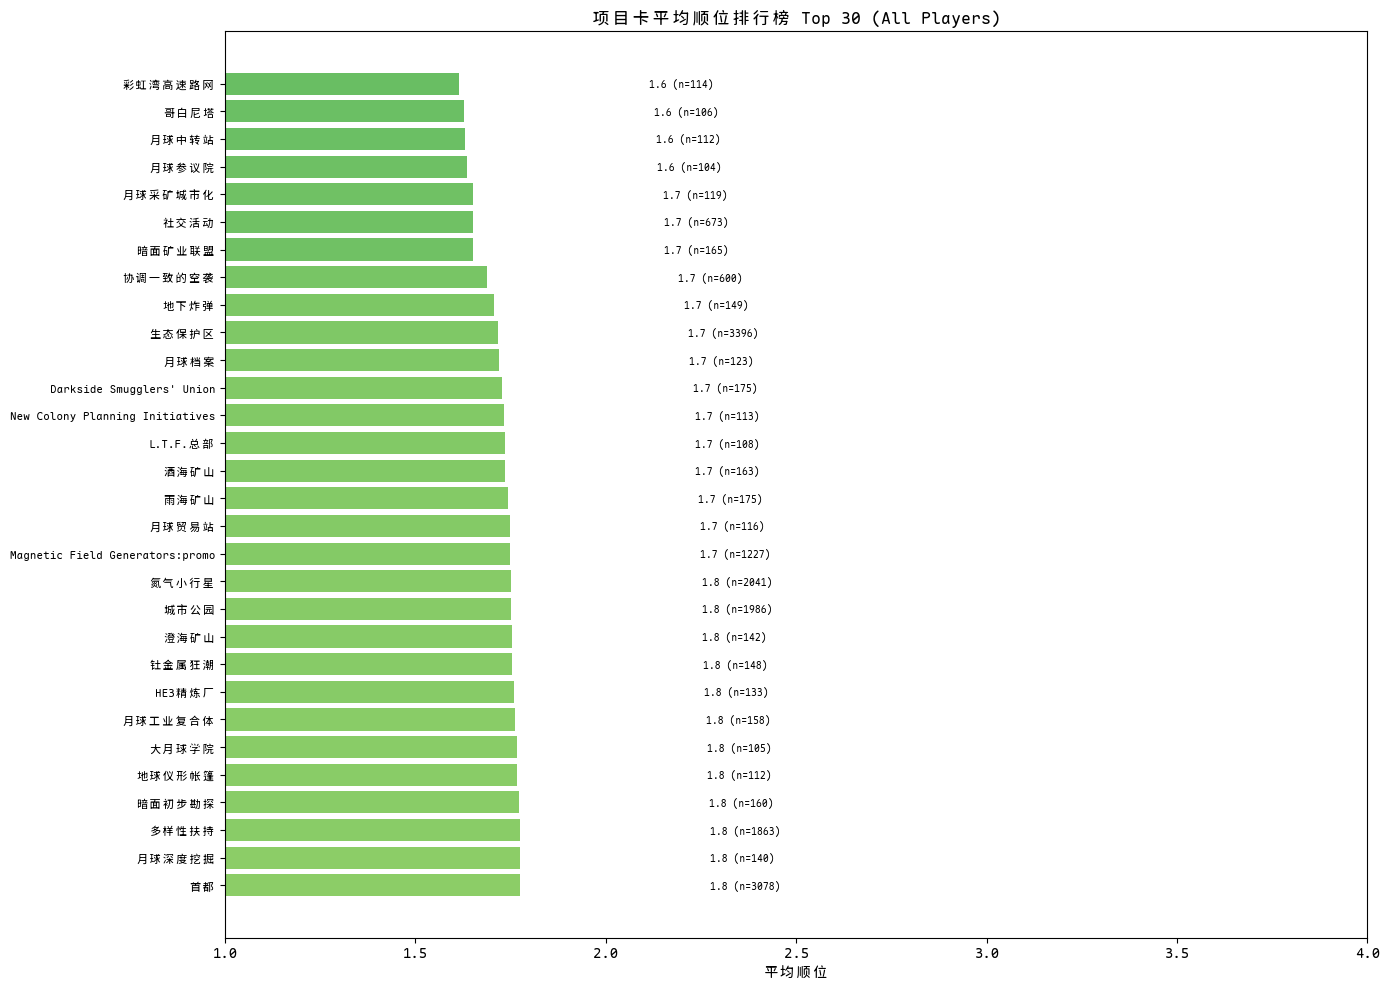

Saved: ./display/card_weighted_all_top30.png


In [13]:
# 3.1 卡牌打出率和胜率分析
def analyze_card_stats(card_df, min_games=10):
    """分析卡牌打出率和胜率"""
    if card_df is None or len(card_df) == 0:
        return pd.DataFrame()

    # 排除前序卡，只分析项目卡
    project_cards_df = card_df[(~card_df['is_prelude']) & (~card_df['is_corporation']) & (~card_df['is_ceo'])].copy()

    card_stats = project_cards_df.groupby('card_name').agg(
        play_count=('game_id', 'count'),
        game_count=('game_id', 'nunique'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count'),
        avg_resources=('resource_count', 'mean')
    ).reset_index()
    card_stats = add_bayesian_weighted_avg(card_stats)

    card_stats['win_rate'] = (card_stats['wins'] / card_stats['play_count'] * 100).round(2)
    card_stats = card_stats[card_stats['play_count'] >= min_games]

    return card_stats

if len(played_cards_df) > 0:
    card_stats_df = analyze_card_stats(played_cards_df)
    card_stats_df = add_cn_name_column(card_stats_df, 'card_name', CN_MAP)

    # 按平均顺位排序（仅统计打出次数>100的卡牌）
    print("=" * 60)
    print("项目卡平均顺位排行榜 (Top 30，打出次数>100)")
    print("=" * 60)
    card_stats_by_wr = card_stats_df[card_stats_df['play_count'] > 100].sort_values('weighted_avg_score', ascending=True)
    display(card_stats_by_wr.head(30))

    # Visualization - Weighted Score
    fig, ax = plt.subplots(figsize=(14, 10))
    top30 = card_stats_by_wr.head(30)
    colors = plt.cm.RdYlGn(np.clip((4 - top30['weighted_avg_score']) / 3, 0, 1))
    bars = ax.barh(range(len(top30)), top30['weighted_avg_score'], color=colors)
    ax.set_yticks(range(len(top30)))
    ax.set_yticklabels(top30['cn_name_plot'], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('平均顺位')
    ax.set_xlim(1, 4)
    ax.set_title('项目卡平均顺位排行榜 Top 30 (All Players)')
    for bar, score, count in zip(bars, top30['weighted_avg_score'], top30['play_count']):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{score:.1f} (n={count})', va='center', fontsize=7)
    plt.tight_layout()
    plt.savefig('./display/card_weighted_all_top30.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: ./display/card_weighted_all_top30.png")

项目卡使用次数排行榜 (Top 30)


card_name  play_count  game_count  wins  avg_position  \
559          Research Outpost        8292        8292  1234      1.997653   
670  Technology Demonstration        8204        8204  1130      2.103483   
482        Olympus Conference        8083        8083  1258      2.032882   
555                  Research        8023        8023  1101      2.076762   
397           Mars University        7938        7938  1173      2.071762   
338      Lagrange Observatory        7891        7891  1054      2.147959   
7             Advanced Alloys        7734        7734  1053      2.077794   
612          Solar Wind Power        7729        7729  1097      2.046569   
169            Earth Catapult        7679        7679  1248      1.929900   
625             Space Station        7647        7647  1076      2.099581   
314         Invention Contest        7615        7615  1136      2.074828   
698       Trans-Neptune Probe        7507        7507   984      2.127644   
736           Viral Enhancers        7453        7453  1253      2.011723   
172              Earth Office        7373        7373  1127      2.020607   
69          Business Contacts        7329        7329  1142      2.061131   
442            Miranda Resort        7193        7193  1039      2.039689   
45      Atalanta Planitia Lab        7165        7165  1260      2.050499   
573        Rover Construction        7115        7115  1040      2.067647   
735            Vesta Shipyard        7086        7086   961      2.081909   
317           Investment Loan        6977        6977  1093      2.098026   
416               Media Group        6878        6878  1132      2.003652   
232           Ganymede Colony        6854        6854  1061      1.926689   
730          Venus Waystation        6822        6822  1213      2.047009   
234               Gene Repair        6729        6729   935      2.046220   
342              Large Convoy        6701        6701  1041      1.918643   
634       Sponsored Academies        6667        6667  1098      2.062024   
1                  AI Central        6661        6661   985      2.059794   
576               SF Memorial        6661        6661   945      2.093871   
297         Imported Hydrogen        6611        6611  1032      1.998025   
431           Mineral Deposit        6593        6593   953      2.079062   

      avg_score  total_weighted  count_weighted  avg_resources  \
559  113.942675          5959.0            2983       0.000000   
670  110.875290          6342.0            3015       0.000000   
482  113.994197          6306.0            3102       0.545961   
555  112.555827          5952.0            2866       0.000000   
397  113.212283          6207.0            2996       0.000000   
338  109.014626          6315.0            2940       0.000000   
7    115.308985          5689.0            2738       0.000000   
612  112.998578          5757.0            2813       0.000000   
169  119.260014          5396.0            2796       0.000000   
625  112.223969          6009.0            2862       0.000000   
314  111.442759          6017.0            2900       0.000000   
698  112.411379          5834.0            2742       0.000000   
736  112.425269          6178.0            3071       0.000000   
172  112.662328          5589.0            2766       0.000000   
69   111.819081          5833.0            2830       0.000000   
442  115.685214          5242.0            2570       0.000000   
45   114.740648          6578.0            3208       0.000000   
573  111.397794          5624.0            2720       0.000000   
735  116.800795          5236.0            2515       0.000000   
317  108.406739          6164.0            2938       0.000000   
416  112.157779          5486.0            2738       0.000000   
232  122.079489          4678.0            2428       0.000000   
730  113.486193          6227.0            3042       0.000000   
234  119.403024          4737.0            2315 

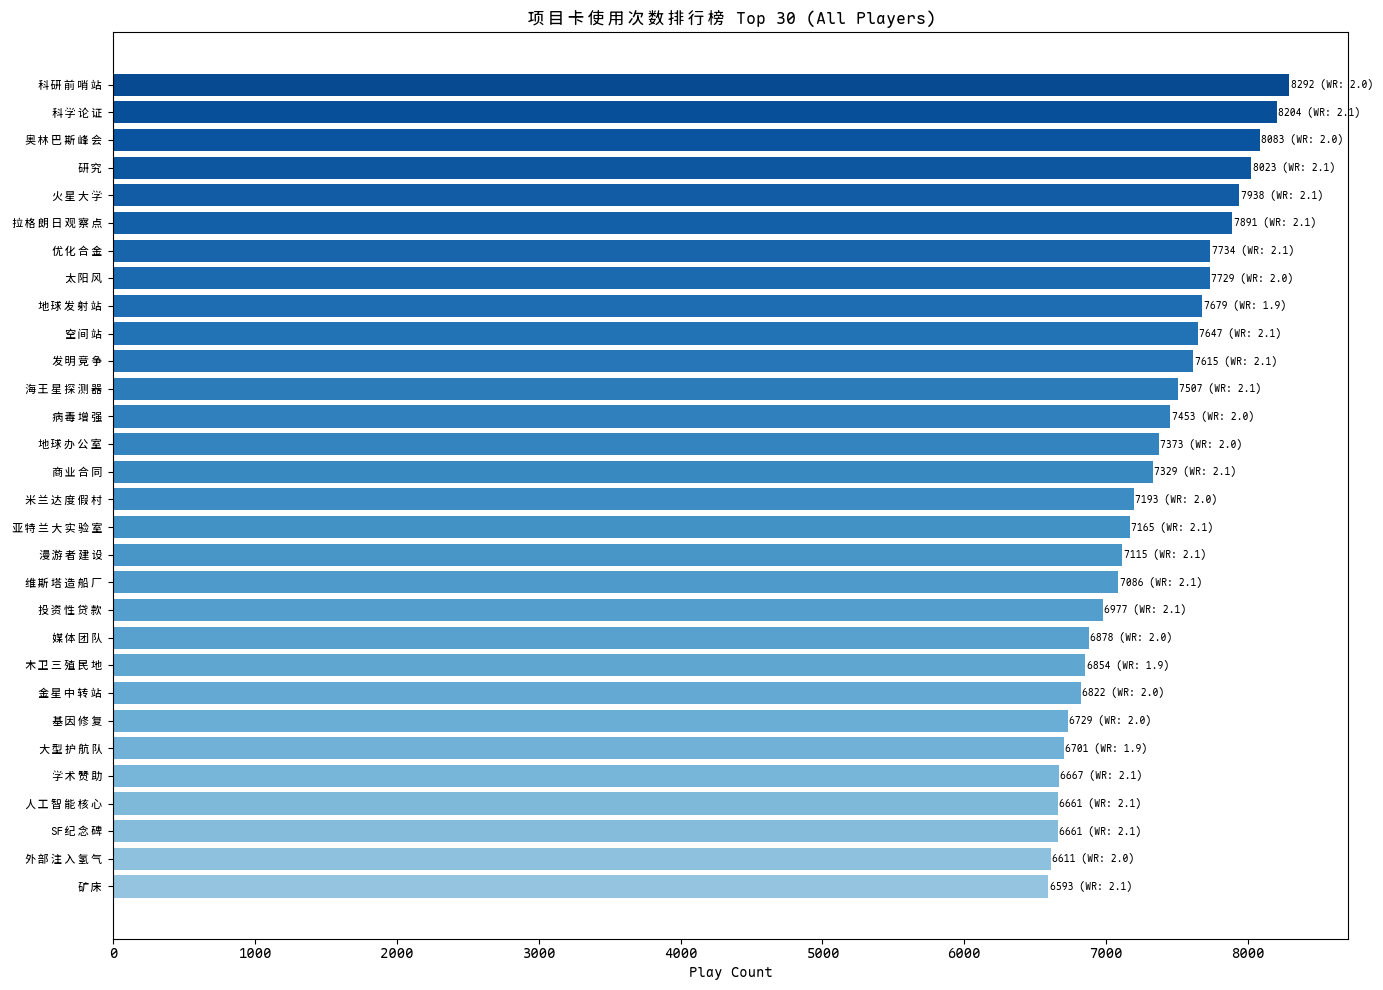

Saved: ./display/card_playcount_all_top30.png


In [14]:
# 3.2 卡牌使用次数排行
if len(played_cards_df) > 0:
    print("=" * 60)
    print("项目卡使用次数排行榜 (Top 30)")
    print("=" * 60)
    card_stats_by_count = card_stats_df.sort_values('play_count', ascending=False)
    display(card_stats_by_count.head(30))

    # Visualization - Play Count
    fig, ax = plt.subplots(figsize=(14, 10))
    top30 = card_stats_by_count.head(30)
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top30)))[::-1]
    bars = ax.barh(range(len(top30)), top30['play_count'], color=colors)
    ax.set_yticks(range(len(top30)))
    ax.set_yticklabels(top30['cn_name_plot'], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('Play Count')
    ax.set_title('项目卡使用次数排行榜 Top 30 (All Players)')
    for bar, count, ws in zip(bars, top30['play_count'], top30['weighted_avg_score']):
        ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
                f'{count} (WR: {ws:.1f})', va='center', fontsize=7)
    plt.tight_layout()
    plt.savefig('./display/card_playcount_all_top30.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: ./display/card_playcount_all_top30.png")

4人局项目卡平均顺位排行榜 (Top 20)


card_name  players  play_count  wins  avg_position  \
637   Declaration of Independence      4.0          47    23      1.808511   
2670                Social Events      4.0         211    98      1.909953   
1342               Induced Tremor      4.0           8     5      1.375000   
409                    City Parks      4.0         423   171      2.007092   
784               Ecological Zone      4.0          99    45      1.979798   
722             Diversity Support      4.0         438   181      2.034247   
1020                 GHG Shipment      4.0         364   158      2.038462   
1617     Luna Political Institute      4.0           9     6      1.555556   
95              Algae Bioreactors      4.0           8     6      1.500000   
3206  Urgent Terraforming Command      4.0         684   263      2.057018   
2138          Off-World Tax Haven      4.0           5     4      1.200000   
405                     City Park      4.0         386   148      2.064767   
2539            Robot Pollinators      4.0         739   290      2.075778   
1513               Lake Marineris      4.0         390   137      2.076923   
3373                         奇物丰收      4.0         279   107      2.075269   
793              Ecology Research      4.0         714   266      2.092437   
1630                  Luna Senate      4.0          10     4      1.700000   
1363                      Insects      4.0         853   299      2.096131   
2623    Sinus Irdium Road Network      4.0           9     5      1.666667   
68           Aerosport Tournament      4.0         621   237      2.101449   

       avg_score  total_weighted  count_weighted  weighted_avg_score  \
637   111.723404            85.0              47            1.929825   
2670  104.270142           403.0             211            1.936652   
1342   99.500000            11.0               8            2.000000   
409    91.491726           849.0             423            2.018476   
784    92.595960           196.0              99            2.027523   
722    97.826484           891.0             438            2.044643   
1020   88.824176           742.0             364            2.050802   
1617  110.000000            14.0               9            2.052632   
95    117.875000            12.0               8            2.055556   
3206   89.804094          1407.0             684            2.063401   
2138  105.600000             6.0               5            2.066667   
405    98.898964           797.0             386            2.075758   
2539   91.281461          1534.0             739            2.081442   
1513   90.882051           810.0             390            2.087500   
3373   91.394265           579.0             279            2.089965   
793    94.558824          1494.0             714            2.098066   
1630  128.100000            17.0              10            2.100000   
1363   90.862837          1788.0             853            2.100811   
2623  141.222222            15.0               9            2.105263   
68     95.297907          1305.0             621            2.107765   

      win_rate    cn_name cn_name_plot  
637      48.94       独立宣言         独立宣言  
2670     46.45       社交活动         社交活动  
1342     62.50       诱发震颤         诱发震颤  
409      40.43       城市公园         城市公园  
784      45.45      生态保护区        生态保护区  
722      41.32      多样性扶持        多样性扶持  
1020     43.41     温室气体运输       温室气体运输  
1617     66.67    月球政治研究所      月球政治研究所  
95       75.00    藻类生物反应器      藻类生物反应器  
3206     38.45      紧急改造令        紧急改造令  
2138     80.00     外星避税天堂       外星避税天堂  
405      38.34  City Park    City Park  
2539     39.24      机器授粉者        机器授粉者  
1513     35.13        水手湖          水手湖  
3373     38.35       奇物丰收         奇物丰收  
793      37.25      生态学研究        生态学研究  
1630     40.00      月球参议院        月球参议院  
1363     35.05         昆虫           昆虫  
2623     55.56    彩虹湾高速路网      彩虹湾高速路网  
68       38.16    航空运动锦标赛      航空运动锦标赛

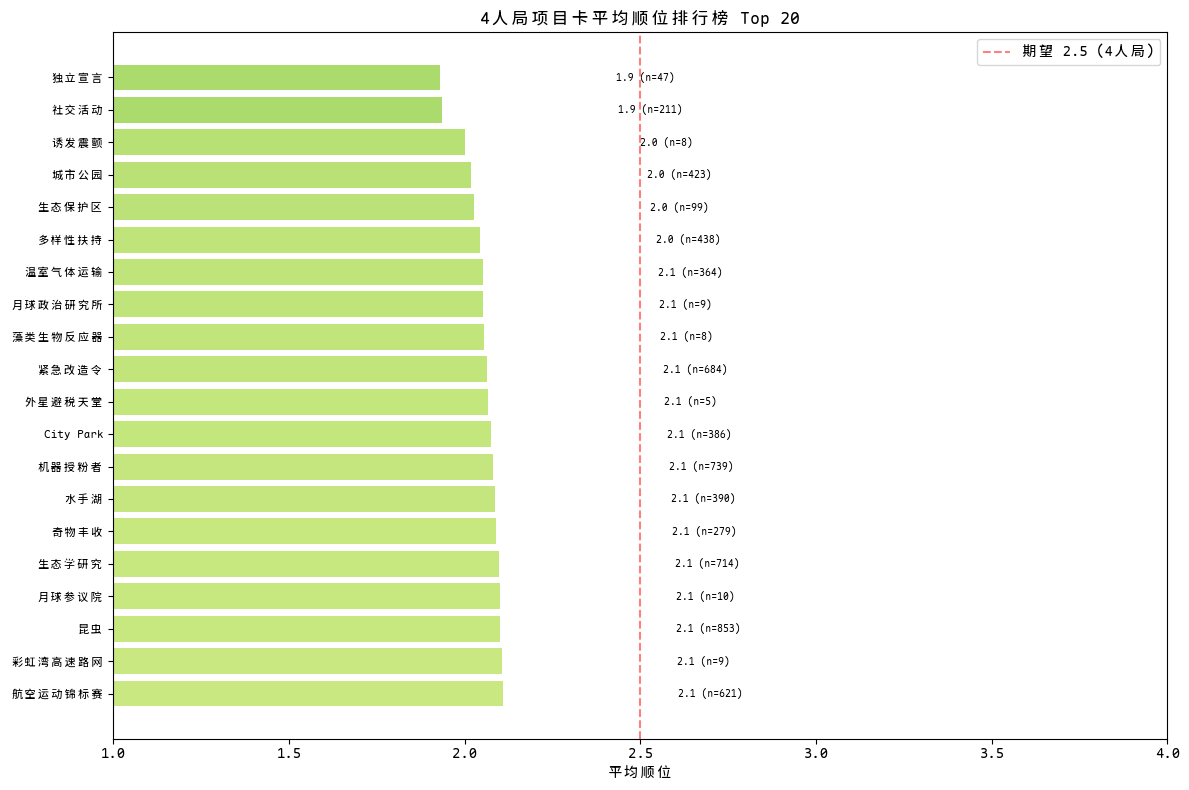

Saved: ./display/card_4p_weighted_mid_top20.png


In [15]:
# 3.3 卡牌与玩家人数的关系
def analyze_card_by_players(card_df, min_games=5):
    """按玩家人数分析卡牌表现"""
    if card_df is None or len(card_df) == 0:
        return pd.DataFrame()

    project_cards_df = card_df[(~card_df['is_prelude']) & (~card_df['is_corporation']) & (~card_df['is_ceo'])].copy()

    card_by_players = project_cards_df.groupby(['card_name', 'players']).agg(
        play_count=('game_id', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
    ).reset_index()
    card_by_players = add_bayesian_weighted_avg(card_by_players)

    card_by_players['win_rate'] = (card_by_players['wins'] / card_by_players['play_count'] * 100).round(2)
    card_by_players = card_by_players[card_by_players['play_count'] >= min_games]

    return card_by_players

if len(played_cards_df) > 0:
    card_by_players_df = analyze_card_by_players(played_cards_df)
    card_by_players_df = add_cn_name_column(card_by_players_df, 'card_name', CN_MAP)

    # 4人局卡牌排行
    print("=" * 60)
    print("4人局项目卡平均顺位排行榜 (Top 20)")
    print("=" * 60)
    card_4p_df = card_by_players_df[card_by_players_df['players'] == 4].sort_values('weighted_avg_score', ascending=True)
    display(card_4p_df.head(20))

    # Visualization - 4P Card Weighted Score
    fig, ax = plt.subplots(figsize=(12, 8))
    top20 = card_4p_df.head(20)
    colors = plt.cm.RdYlGn(np.clip((4 - top20['weighted_avg_score']) / 3, 0, 1))
    bars = ax.barh(range(len(top20)), top20['weighted_avg_score'], color=colors)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['cn_name_plot'], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('平均顺位')
    ax.set_xlim(1, 4)
    ax.axvline(x=2.5, color='red', linestyle='--', alpha=0.5, label='期望 2.5 (4人局)')
    ax.legend()
    ax.set_title('4人局项目卡平均顺位排行榜 Top 20')
    for bar, score, count in zip(bars, top20['weighted_avg_score'], top20['play_count']):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{score:.1f} (n={count})', va='center', fontsize=7)
    plt.tight_layout()
    plt.savefig('./display/card_4p_weighted_mid_top20.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: ./display/card_4p_weighted_mid_top20.png")

卡牌-公司协同加权分排行 (Top 30)


card_name corporation  play_count  wins   avg_score  \
3429        AntiGravity Experiment    Id Front          33    28  196.090909   
18415                  Decomposers    Id Front          47    37  195.659574   
83083       Sub-Crust Measurements    Id Front          43    32  180.069767   
21826               Earth Catapult    Id Front          46    33  188.565217   
40106            Invention Contest    Id Front          42    32  172.690476   
34720                  Hi-Tech Lab    Id Front          42    32  190.619048   
52163               Mass Converter    Id Front          42    31  196.285714   
51046          Martian Lumber Corp    Id Front          32    25  206.187500   
90751            Urban Decomposers    Id Front          28    25  173.214286   
22917             Ecology Research       Vitor          89    60  134.629213   
45005            Lightning Harvest    Id Front          42    33  169.809524   
38442           Indentured Workers    Id Front          36    27  186.055556   
39276                   Insulation       Prism          34    25  215.470588   
79358            Space Port Colony    Id Front          43    31  197.837209   
76278              Soil Enrichment    Id Front          30    23  218.733333   
23913                Energy Supply    Id Front          28    24  193.678571   
94472     Water Import From Europa    Id Front          35    27  210.542857   
59291       Nitrogen-Rich Asteroid       Prism          42    32  198.333333   
59543                   Nobel Labs    Id Front          24    20  174.041667   
75246                Small Animals    Id Front          31    24  213.709677   
1394                   Advertising    Id Front          38    28  203.421053   
61611              Orbital Cleanup    Id Front          45    33  172.266667   
3259       Anti-Gravity Technology    Manutech          68    47  160.544118   
64316              Plant Smuggling    Id Front          36    27  195.861111   
92210              Venus Trade Hub    Id Front          36    27  194.944444   
22832             Ecology Research    Id Front          27    21  188.814815   
80770          Sponsored Academies    Id Front          41    29  180.414634   
10393           Carbon Nanosystems    Id Front          41    30  179.414634   
18186                    Dawn City    Id Front          41    29  171.073171   
91075  Urgent Terraforming Command       Prism          46    32  182.956522   

       total_weighted  count_weighted  weighted_avg_score  win_rate  \
3429             39.0              33            1.488372     84.85   
18415            60.0              47            1.491228     78.72   
83083            55.0              43            1.509434     74.42   
21826            60.0              46            1.517857     71.74   
40106            54.0              42            1.519231     76.19   
34720            54.0              42            1.519231     76.19   
52163            54.0              42            1.519231     73.81   
51046            39.0              32            1.523810     78.12   
90751            33.0              28            1.526316     89.29   
22917           127.0              89            1.535354     67.42   
45005            55.0              42            1.538462     78.57   
38442            46.0              36            1.543478     75.00   
39276            43.0              34            1.545455     73.53   
79358            57.0              43            1.547170     72.09   
76278            37.0              30            1.550000     76.67   
23913            34.0              28            1.552632     85.71   
94472            45.0              35            1.555556     77.14   
59291            56.0              42            1.557692     76.19   
59543            28.0              24            1.558824     83.33   
75246            39.0              31            1.560976     77.42   
1394             50.0              38            1.56

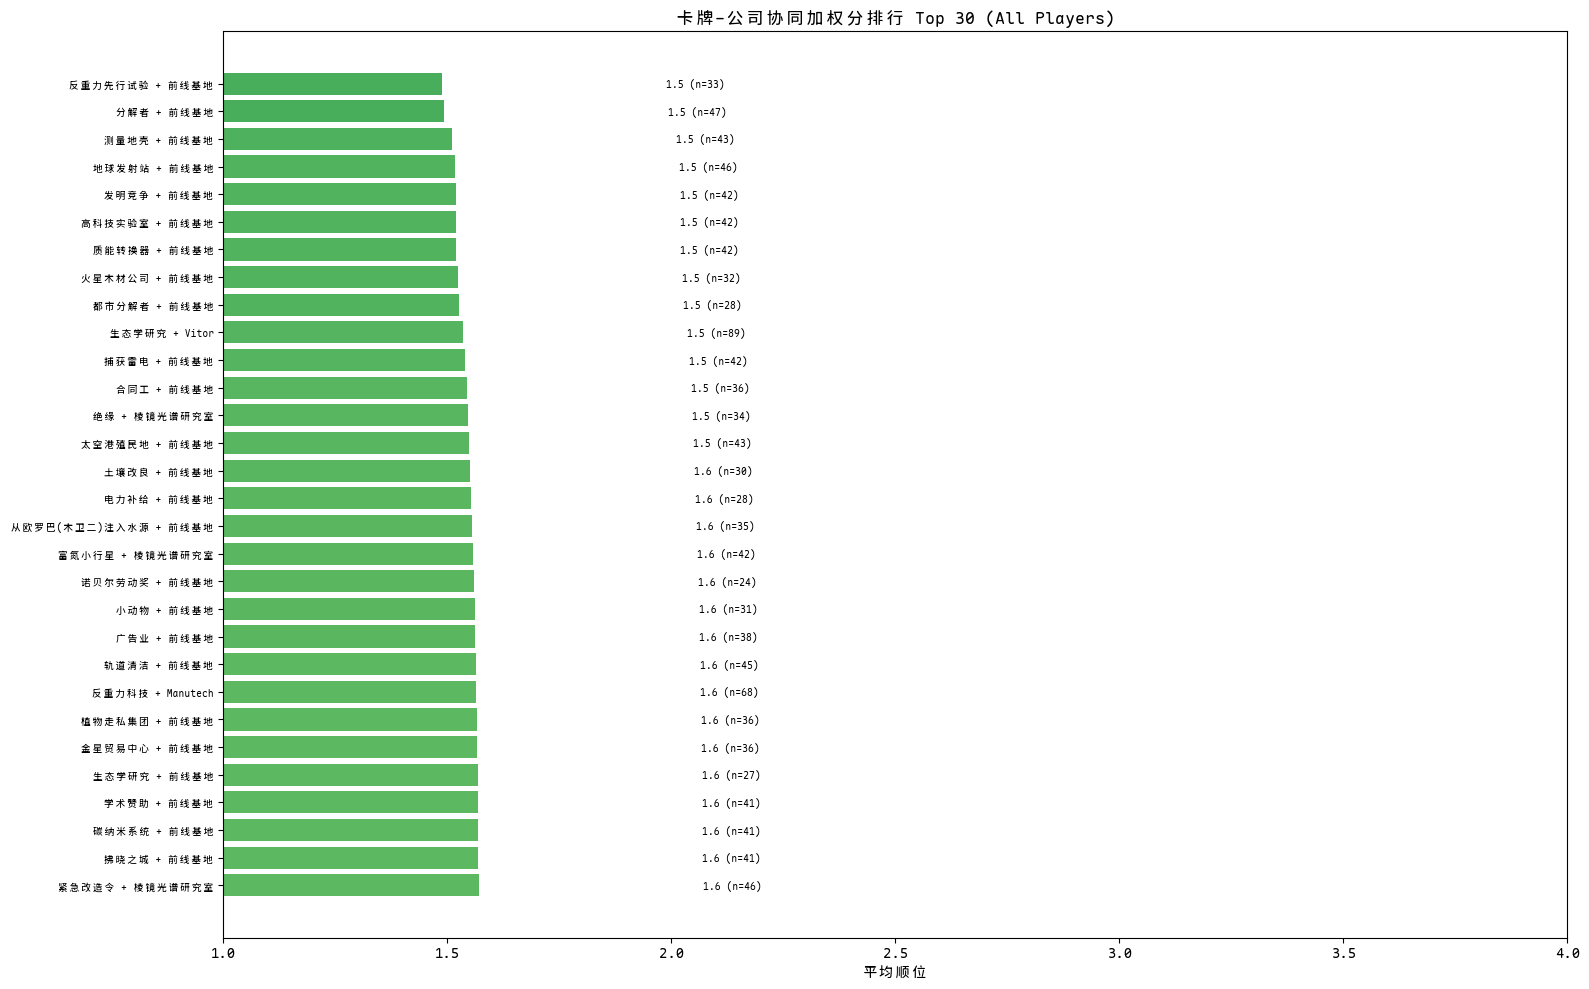

Saved: ./display/card_corp_synergy_all_top30.png


In [16]:
# 3.4 卡牌与公司的关联分析
def analyze_card_corporation_synergy(card_df, min_games=5):
    """分析卡牌与公司的协同效果"""
    if card_df is None or len(card_df) == 0:
        return pd.DataFrame()

    project_cards_df = card_df[(~card_df['is_prelude']) & (~card_df['is_corporation']) & (~card_df['is_ceo'])].copy()

    # 展开公司
    synergy_records = []
    for _, row in project_cards_df.iterrows():
        corps = split_corporations(row['corporation'])
        for corp in corps:
            synergy_records.append({
                'card_name': row['card_name'],
                'corporation': corp,
                'position': row['position'],
                'player_score': row['player_score'],
                'weighted_score': row['weighted_score']
            })

    if not synergy_records:
        return pd.DataFrame()

    synergy_df = pd.DataFrame(synergy_records)

    synergy_stats = synergy_df.groupby(['card_name', 'corporation']).agg(
        play_count=('position', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
    ).reset_index()
    synergy_stats = add_bayesian_weighted_avg(synergy_stats)

    synergy_stats['win_rate'] = (synergy_stats['wins'] / synergy_stats['play_count'] * 100).round(2)
    synergy_stats = synergy_stats[synergy_stats['play_count'] >= min_games]

    return synergy_stats.sort_values('weighted_avg_score', ascending=True)

if len(played_cards_df) > 0:
    synergy_df = analyze_card_corporation_synergy(played_cards_df)
    if len(synergy_df) > 0:
        # Add cn_name columns
        synergy_df['card_cn_name'] = synergy_df['card_name'].apply(lambda x: CN_MAP.get(x, x))
        synergy_df['corp_cn_name'] = synergy_df['corporation'].apply(lambda x: CN_MAP.get(x, x))
        # Add plot-safe versions (without emoji)
        synergy_df['card_cn_name_plot'] = synergy_df['card_name'].apply(lambda x: get_cn_name_for_plot(x, CN_MAP))
        synergy_df['corp_cn_name_plot'] = synergy_df['corporation'].apply(lambda x: get_cn_name_for_plot(x, CN_MAP))

        print("=" * 60)
        print("卡牌-公司协同加权分排行 (Top 30)")
        print("=" * 60)
        display(synergy_df.head(30))

        # Visualization
        fig, ax = plt.subplots(figsize=(16, 10))
        top30 = synergy_df.head(30)
        labels = [f"{strip_emoji(row['card_cn_name'])[:15]} + {strip_emoji(row['corp_cn_name'])[:15]}" for _, row in top30.iterrows()]
        colors = plt.cm.RdYlGn(np.clip((4 - top30['weighted_avg_score']) / 3, 0, 1))
        bars = ax.barh(range(len(top30)), top30['weighted_avg_score'], color=colors)
        ax.set_yticks(range(len(top30)))
        ax.set_yticklabels(labels, fontsize=7)
        ax.invert_yaxis()
        ax.set_xlabel('平均顺位')
        ax.set_xlim(1, 4)
        ax.set_title('卡牌-公司协同加权分排行 Top 30 (All Players)')
        for bar, score, count in zip(bars, top30['weighted_avg_score'], top30['play_count']):
            ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                    f'{score:.1f} (n={count})', va='center', fontsize=7)
        plt.tight_layout()
        plt.savefig('./display/card_corp_synergy_all_top30.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Saved: ./display/card_corp_synergy_all_top30.png")

## 4. 数据导出

In [17]:
# 导出分析结果到 CSV
OUTPUT_DIR = './analysis_results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 导出公司数据
if len(corp_usage_df) > 0:
    corp_usage_df.to_csv(f'{OUTPUT_DIR}/corporation_usage.csv', index=False)
    print(f"已导出: {OUTPUT_DIR}/corporation_usage.csv")

if len(corp_popular) > 0:
    corp_popular.to_csv(f'{OUTPUT_DIR}/corporation_popularity.csv', index=False)
    print(f"已导出: {OUTPUT_DIR}/corporation_popularity.csv")

if len(corp_combo_df) > 0:
    corp_combo_df.to_csv(f'{OUTPUT_DIR}/corporation_combinations.csv', index=False)
    print(f"已导出: {OUTPUT_DIR}/corporation_combinations.csv")

# 导出前序数据
if 'prelude_stats_df' in dir() and len(prelude_stats_df) > 0:
    prelude_stats_df.to_csv(f'{OUTPUT_DIR}/prelude_stats.csv', index=False)
    print(f"已导出: {OUTPUT_DIR}/prelude_stats.csv")

# 导出卡牌数据
if 'card_stats_df' in dir() and len(card_stats_df) > 0:
    card_stats_df.to_csv(f'{OUTPUT_DIR}/card_stats.csv', index=False)
    print(f"已导出: {OUTPUT_DIR}/card_stats.csv")

if 'card_by_players_df' in dir() and len(card_by_players_df) > 0:
    card_by_players_df.to_csv(f'{OUTPUT_DIR}/card_stats_by_players.csv', index=False)
    print(f"已导出: {OUTPUT_DIR}/card_stats_by_players.csv")

print("\n数据导出完成!")

已导出: ./analysis_results/corporation_usage.csv
已导出: ./analysis_results/corporation_popularity.csv
已导出: ./analysis_results/corporation_combinations.csv
已导出: ./analysis_results/prelude_stats.csv
已导出: ./analysis_results/card_stats.csv
已导出: ./analysis_results/card_stats_by_players.csv

数据导出完成!


## 5. 汇总统计

In [18]:
# 汇总统计信息
print("=" * 60)
print("数据分析汇总")
print("=" * 60)

print(f"\n1. 公司数据:")
print(f"   - 总公司使用记录: {len(corp_df)}")
print(f"   - 唯一公司数量: {corp_df['corporation'].nunique()}")
if len(corp_usage_df) > 0:
    print(f"   - 分析的公司数量 (>=10局): {len(corp_usage_df['corporation'].unique())}")

if len(corp_combo_df) > 0:
    print(f"\n2. 双公司组合:")
    print(f"   - 分析的组合数量: {len(corp_combo_df)}")

if 'prelude_df' in dir() and len(prelude_df) > 0:
    print(f"\n3. 前序卡数据:")
    print(f"   - 总前序使用记录: {len(prelude_df)}")
    print(f"   - 唯一前序数量: {prelude_df['prelude_name'].nunique()}")

if 'played_cards_df' in dir() and len(played_cards_df) > 0:
    print(f"\n4. 卡牌数据:")
    print(f"   - 总卡牌使用记录: {len(played_cards_df)}")
    print(f"   - 唯一卡牌数量: {played_cards_df['card_name'].nunique()}")
    project_count = len(played_cards_df[(~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])])
    print(f"   - 项目卡使用记录: {project_count}")

数据分析汇总

1. 公司数据:
   - 总公司使用记录: 45955


   - 唯一公司数量: 137
   - 分析的公司数量 (>=10局): 114

2. 双公司组合:
   - 分析的组合数量: 1276

3. 前序卡数据:
   - 总前序使用记录: 112029
   - 唯一前序数量: 109

4. 卡牌数据:
   - 总卡牌使用记录: 2168102
   - 唯一卡牌数量: 1071
   - 项目卡使用记录: 2023829


## 6. Export to Display Folder and Visualizations

In [19]:
matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

DISPLAY_DIR = './display'
os.makedirs(DISPLAY_DIR, exist_ok=True)

# Minimum sample size for filtered data
MIN_SAMPLE_SIZE = 10

print(f"Display folder created: {DISPLAY_DIR}")
print(f"Minimum sample size for filtered data: {MIN_SAMPLE_SIZE}")

Display folder created: ./display
Minimum sample size for filtered data: 10


Saved: ./display/corporation_usage_full.csv (569 rows)
Saved: ./display/corporation_usage_filtered.csv (348 rows)
Saved: ./display/corporation_4p_weighted_full.csv (135 rows)
Saved: ./display/corporation_4p_weighted_filtered.csv (109 rows)


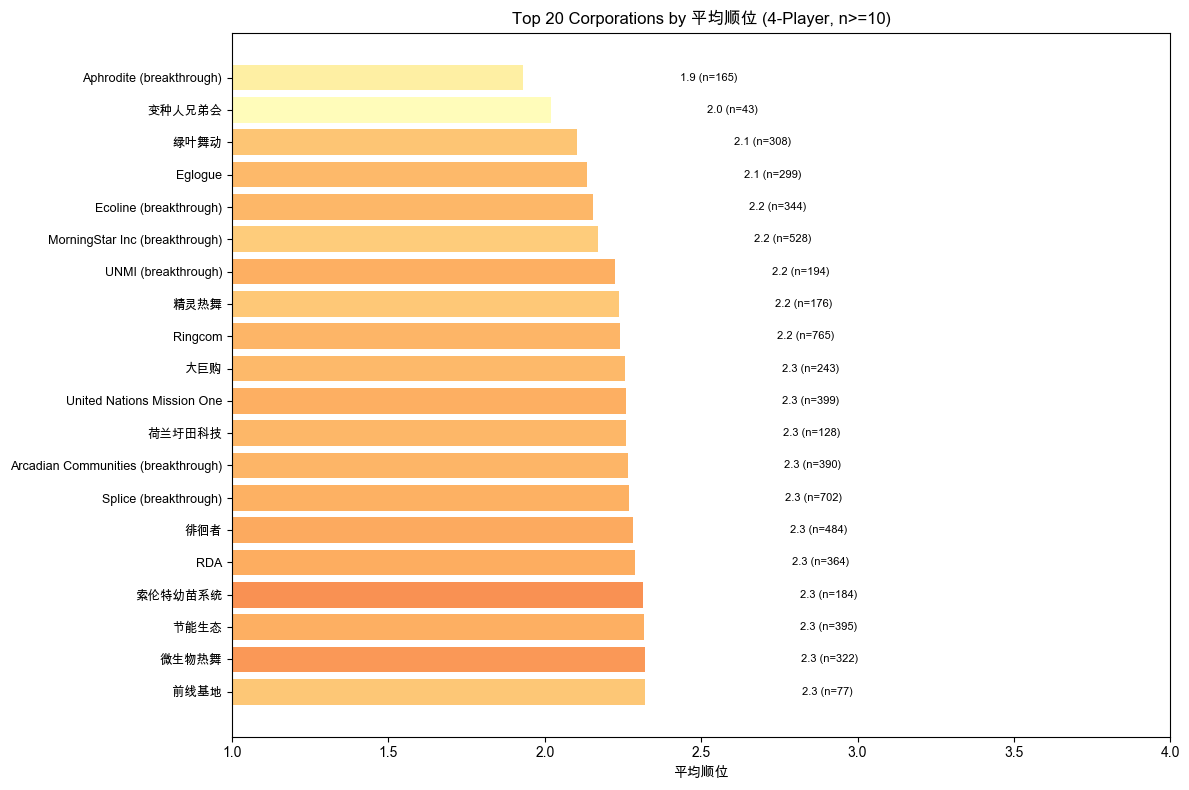

Saved: ./display/corporation_4p_weighted_top20.png


In [20]:
# 6.1 Save Corporation Usage Data (Full + Filtered) and Visualize

# Re-analyze corporation usage without min_games filter for full version
corp_usage_full = corp_df.groupby(['corporation', 'players']).agg(
    total_games=('game_id', 'count'),
    wins=('position', lambda x: (x == 1).sum()),
    avg_position=('position', 'mean'),
    avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count'),
    avg_generations=('generations', 'mean')
).reset_index()
corp_usage_full = add_bayesian_weighted_avg(corp_usage_full)
corp_usage_full['win_rate'] = (corp_usage_full['wins'] / corp_usage_full['total_games'] * 100).round(2)
corp_usage_full = corp_usage_full.sort_values(['players', 'weighted_avg_score'], ascending=[True, True])

# Add cn_name column
corp_usage_full = add_cn_name_column(corp_usage_full, 'corporation', CN_MAP)

# Save FULL corporation usage data (no filter)
corp_usage_full.to_csv(f'{DISPLAY_DIR}/corporation_usage_full.csv', index=False)
print(f"Saved: {DISPLAY_DIR}/corporation_usage_full.csv ({len(corp_usage_full)} rows)")

# Save FILTERED corporation usage data (>= MIN_SAMPLE_SIZE)
corp_usage_filtered = corp_usage_full[corp_usage_full['total_games'] >= MIN_SAMPLE_SIZE].copy()
corp_usage_filtered.to_csv(f'{DISPLAY_DIR}/corporation_usage_filtered.csv', index=False)
print(f"Saved: {DISPLAY_DIR}/corporation_usage_filtered.csv ({len(corp_usage_filtered)} rows)")

# 4-player data - Full and Filtered
corp_4p_full = corp_usage_full[corp_usage_full['players'] == 4].sort_values('weighted_avg_score', ascending=True)
corp_4p_filtered = corp_usage_filtered[corp_usage_filtered['players'] == 4].sort_values('weighted_avg_score', ascending=True)

corp_4p_full.to_csv(f'{DISPLAY_DIR}/corporation_4p_weighted_full.csv', index=False)
corp_4p_filtered.to_csv(f'{DISPLAY_DIR}/corporation_4p_weighted_filtered.csv', index=False)
print(f"Saved: {DISPLAY_DIR}/corporation_4p_weighted_full.csv ({len(corp_4p_full)} rows)")
print(f"Saved: {DISPLAY_DIR}/corporation_4p_weighted_filtered.csv ({len(corp_4p_filtered)} rows)")

# Visualization: Top 20 Corporations by 平均顺位 (4-player) - FILTERED DATA
fig, ax = plt.subplots(figsize=(12, 8))
top20_4p = corp_4p_filtered.head(20)
colors = plt.cm.RdYlGn(top20_4p['win_rate'] / 100)
bars = ax.barh(range(len(top20_4p)), top20_4p['weighted_avg_score'], color=colors)
ax.set_yticks(range(len(top20_4p)))
ax.set_yticklabels(top20_4p['cn_name_plot'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('平均顺位')
ax.set_title(f'Top 20 Corporations by 平均顺位 (4-Player, n>={MIN_SAMPLE_SIZE})')
ax.set_xlim(1, 4)

for i, (bar, score, games) in enumerate(zip(bars, top20_4p['weighted_avg_score'], top20_4p['total_games'])):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{score:.1f} (n={games})', va='center', fontsize=8)

plt.tight_layout()
plt.savefig(f'{DISPLAY_DIR}/corporation_4p_weighted_top20.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {DISPLAY_DIR}/corporation_4p_weighted_top20.png")

In [21]:
# 6.2 Save Corporation Popularity Data (Full + Filtered) and Visualize
# 只使用4人局数据计算胜率，避免单人局100%胜率干扰

# Filter to 4-player games only for accurate win rate calculation
corp_df_4p = corp_df[corp_df['players'] == 4].copy()

# Re-calculate corporation popularity using 4-player games only
corp_popular_full = corp_df_4p.groupby('corporation').agg(
    total_games=('game_id', 'count'),
    wins=('position', lambda x: (x == 1).sum()),
    avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
).reset_index()
corp_popular_full = add_bayesian_weighted_avg(corp_popular_full)
corp_popular_full['win_rate'] = (corp_popular_full['wins'] / corp_popular_full['total_games'] * 100).round(2)
corp_popular_full = corp_popular_full.sort_values('total_games', ascending=False)

# Add cn_name column
corp_popular_full = add_cn_name_column(corp_popular_full, 'corporation', CN_MAP)

# Save FULL corporation popularity data
corp_popular_full.to_csv(f'{DISPLAY_DIR}/corporation_popularity_full.csv', index=False)
print(f"Saved: {DISPLAY_DIR}/corporation_popularity_full.csv ({len(corp_popular_full)} rows)")

# Save FILTERED corporation popularity data
corp_popular_filtered = corp_popular_full[corp_popular_full['total_games'] >= MIN_SAMPLE_SIZE].copy()
corp_popular_filtered.to_csv(f'{DISPLAY_DIR}/corporation_popularity_filtered.csv', index=False)
print(f"Saved: {DISPLAY_DIR}/corporation_popularity_filtered.csv ({len(corp_popular_filtered)} rows)")

# Visualization: Top 30 Most Used Corporations - FILTERED DATA
fig, ax = plt.subplots(figsize=(14, 10))
top30_popular = corp_popular_filtered.head(30)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top30_popular)))[::-1]
bars = ax.barh(range(len(top30_popular)), top30_popular['total_games'], color=colors)
ax.set_yticks(range(len(top30_popular)))
ax.set_yticklabels(top30_popular['cn_name_plot'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Total Games')
ax.set_title(f'Top 30 Most Used Corporations - 4P Games (n>={MIN_SAMPLE_SIZE})')

for bar, games, ws in zip(bars, top30_popular['total_games'], top30_popular['win_rate']):
    ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
            f'{games} (WR: {ws:.1f})', va='center', fontsize=8)

ax.set_xlim(1, 4)
plt.tight_layout()
plt.savefig(f'{DISPLAY_DIR}/corporation_popularity_top30.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {DISPLAY_DIR}/corporation_popularity_top30.png")

Saved: ./display/corporation_popularity_full.csv (135 rows)
Saved: ./display/corporation_popularity_filtered.csv (109 rows)


/var/folders/kt/jh5yr5kn50v_xx9qcjdrw3p40000gn/T/ipykernel_68495/1943619766.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved: ./display/corporation_popularity_top30.png


Saved: ./display/corporation_combinations_full.csv (3880 rows)
Saved: ./display/corporation_combinations_filtered.csv (598 rows)


/var/folders/kt/jh5yr5kn50v_xx9qcjdrw3p40000gn/T/ipykernel_68495/4267527940.py:66: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Arial Unicode MS.
  plt.tight_layout()
/var/folders/kt/jh5yr5kn50v_xx9qcjdrw3p40000gn/T/ipykernel_68495/4267527940.py:67: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Arial Unicode MS.
  plt.savefig(f'{DISPLAY_DIR}/corporation_combinations_top20.png', dpi=150, bbox_inches='tight')
/Users/oushuohuang/Documents/tfm-data/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Arial Unicode MS.
  fig.canvas.print_figure(bytes_io, **kw)


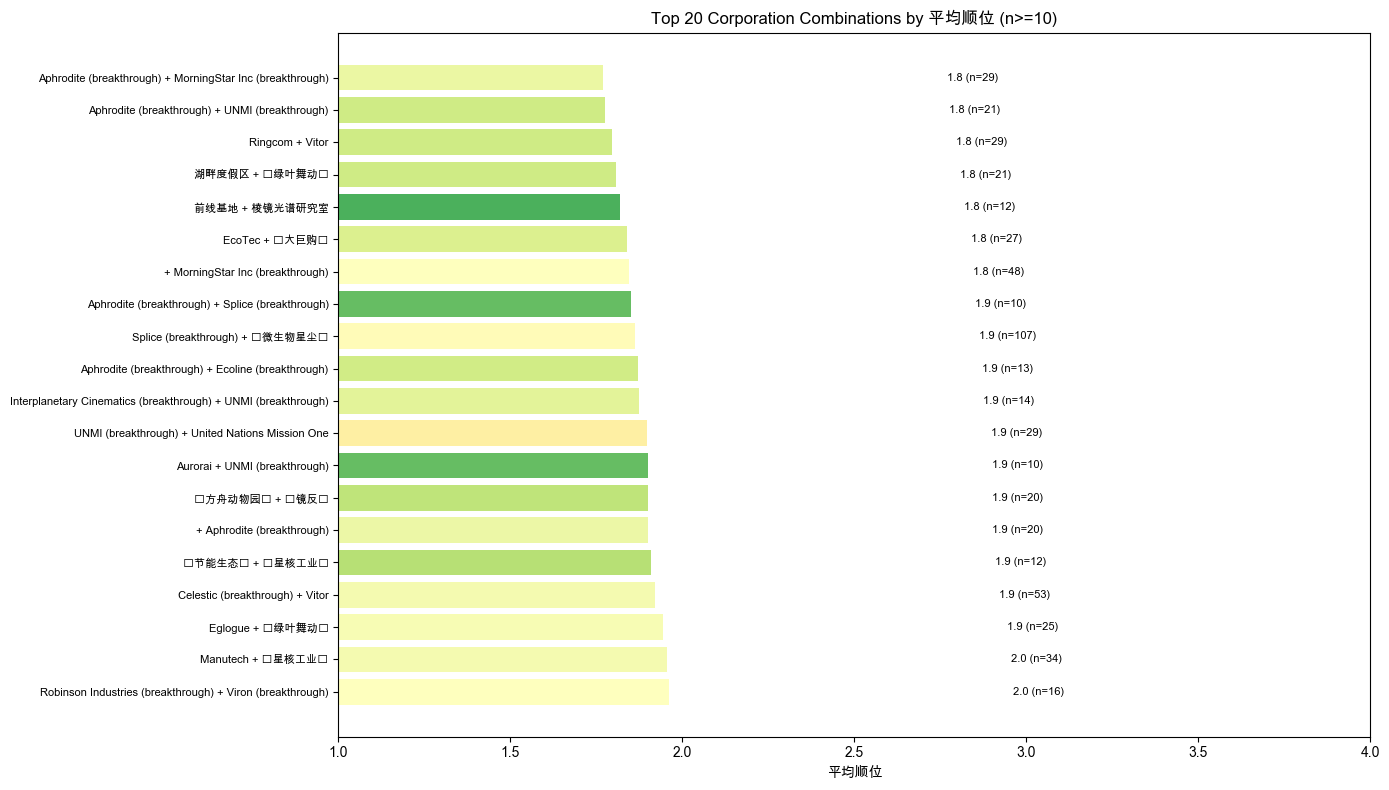

Saved: ./display/corporation_combinations_top20.png


In [22]:
# 6.3 Save Corporation Combinations Data (Full + Filtered) and Visualize

# Re-analyze combinations without filter for full version
combo_records = []
for _, row in user_game_results_df[user_game_results_df['phase'] == 'end'].iterrows():
    corps = split_corporations(row['corporation'])
    if len(corps) >= 2:
        combo = ' + '.join(sorted(corps[:2]))
        combo_records.append({
            'combination': combo,
            'corp1': sorted(corps[:2])[0],
            'corp2': sorted(corps[:2])[1],
            'position': row['position'],
            'player_score': row['player_score'],
            'players': row['players'],
            'generations': row['generations'],
            'weighted_score': row['weighted_score']
        })

if combo_records:
    combo_df_temp = pd.DataFrame(combo_records)
    corp_combo_full = combo_df_temp.groupby('combination').agg(
        total_games=('position', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
    ).reset_index()
    corp_combo_full = add_bayesian_weighted_avg(corp_combo_full)
    corp_combo_full['win_rate'] = (corp_combo_full['wins'] / corp_combo_full['total_games'] * 100).round(2)
    corp_combo_full = corp_combo_full.sort_values('weighted_avg_score', ascending=True)

    # Add cn_name column (for combination, we'll translate each corp separately)
    def get_combo_cn_name(combo):
        parts = combo.split(' + ')
        cn_parts = [CN_MAP.get(p, p) for p in parts]
        return ' + '.join(cn_parts)
    corp_combo_full['cn_name_plot'] = corp_combo_full['combination'].apply(get_combo_cn_name)

    # Save FULL combination data
    corp_combo_full.to_csv(f'{DISPLAY_DIR}/corporation_combinations_full.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/corporation_combinations_full.csv ({len(corp_combo_full)} rows)")

    # Save FILTERED combination data
    corp_combo_filtered = corp_combo_full[corp_combo_full['total_games'] >= MIN_SAMPLE_SIZE].copy()
    corp_combo_filtered.to_csv(f'{DISPLAY_DIR}/corporation_combinations_filtered.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/corporation_combinations_filtered.csv ({len(corp_combo_filtered)} rows)")

    # Visualization: Top 20 Corporation Combinations - FILTERED DATA
    if len(corp_combo_filtered) > 0:
        fig, ax = plt.subplots(figsize=(14, 8))
        top20_combo = corp_combo_filtered.head(20)
        colors = plt.cm.RdYlGn(top20_combo['win_rate'] / 100)
        bars = ax.barh(range(len(top20_combo)), top20_combo['weighted_avg_score'], color=colors)
        ax.set_yticks(range(len(top20_combo)))
        ax.set_yticklabels(top20_combo['cn_name_plot'], fontsize=8)
        ax.invert_yaxis()
        ax.set_xlabel('平均顺位')
        ax.set_title(f'Top 20 Corporation Combinations by 平均顺位 (n>={MIN_SAMPLE_SIZE})')
        ax.set_xlim(1, 4)

        for bar, score, games in zip(bars, top20_combo['weighted_avg_score'], top20_combo['total_games']):
            ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{score:.1f} (n={games})', va='center', fontsize=8)

        plt.tight_layout()
        plt.savefig(f'{DISPLAY_DIR}/corporation_combinations_top20.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {DISPLAY_DIR}/corporation_combinations_top20.png")
else:
    print("No corporation combination data available")

Saved: ./display/prelude_usage_raw.csv (112029 rows)
Saved: ./display/prelude_stats_full.csv (109 rows)
Saved: ./display/prelude_stats_filtered.csv (91 rows)


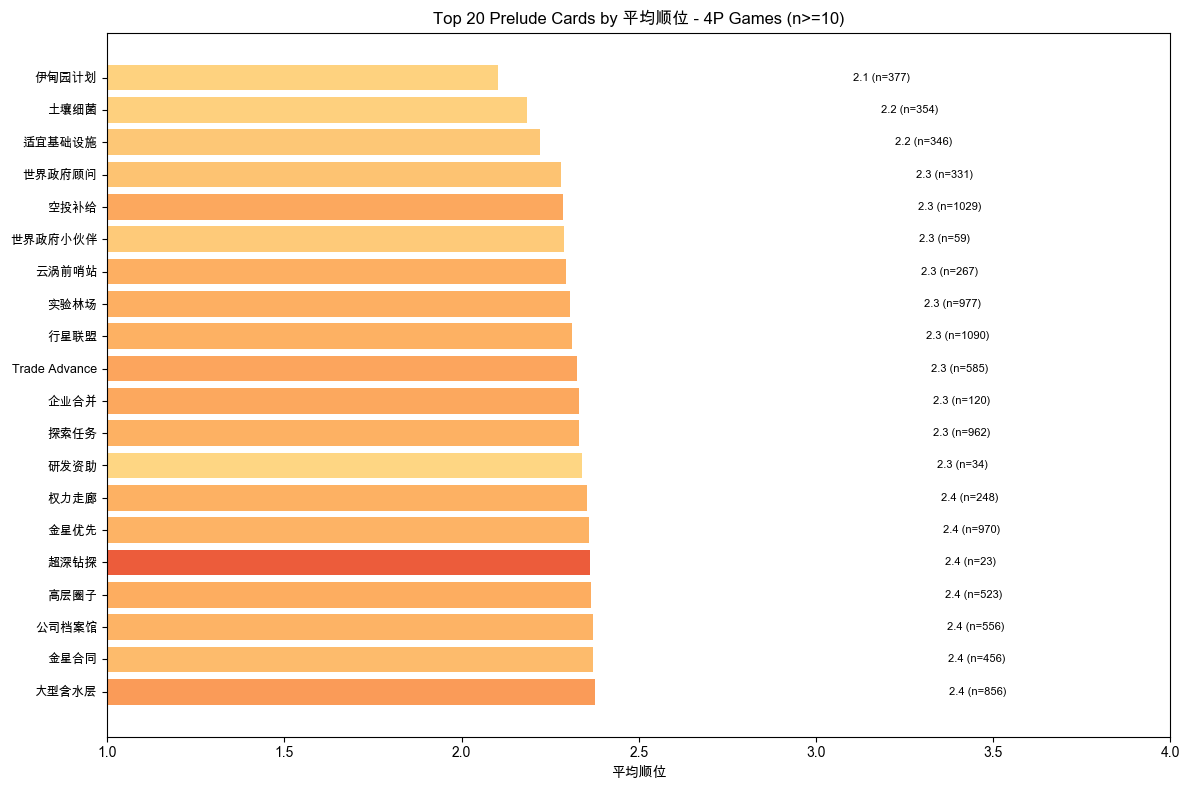

Saved: ./display/prelude_weighted_top20.png


In [23]:
# 6.4 Save Prelude Stats Data (Full + Filtered) and Visualize

if 'prelude_df' in dir() and len(prelude_df) > 0:
    # Save raw prelude data
    prelude_df.to_csv(f'{DISPLAY_DIR}/prelude_usage_raw.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/prelude_usage_raw.csv ({len(prelude_df)} rows)")

    # Re-analyze prelude stats using 4-player games only for accurate win rate
    prelude_df_4p = prelude_df[prelude_df['players'] == 4].copy()
    prelude_stats_full = prelude_df_4p.groupby('prelude_name').agg(
        total_uses=('game_id', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count'),
        avg_generations=('generations', 'mean')
    ).reset_index()
    prelude_stats_full = add_bayesian_weighted_avg(prelude_stats_full)
    prelude_stats_full['win_rate'] = (prelude_stats_full['wins'] / prelude_stats_full['total_uses'] * 100).round(2)
    prelude_stats_full = prelude_stats_full.sort_values('weighted_avg_score', ascending=True)

    # Add cn_name column
    prelude_stats_full = add_cn_name_column(prelude_stats_full, 'prelude_name', CN_MAP)

    # Save FULL prelude stats data
    prelude_stats_full.to_csv(f'{DISPLAY_DIR}/prelude_stats_full.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/prelude_stats_full.csv ({len(prelude_stats_full)} rows)")

    # Save FILTERED prelude stats data
    prelude_stats_filtered = prelude_stats_full[prelude_stats_full['total_uses'] >= MIN_SAMPLE_SIZE].copy()
    prelude_stats_filtered.to_csv(f'{DISPLAY_DIR}/prelude_stats_filtered.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/prelude_stats_filtered.csv ({len(prelude_stats_filtered)} rows)")

    # Visualization: Top 20 Preludes by Weighted Score - FILTERED DATA
    if len(prelude_stats_filtered) > 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        top20_prelude = prelude_stats_filtered.head(20)
        colors = plt.cm.RdYlGn(top20_prelude['win_rate'] / 100)
        bars = ax.barh(range(len(top20_prelude)), top20_prelude['weighted_avg_score'], color=colors)
        ax.set_yticks(range(len(top20_prelude)))
        ax.set_yticklabels(top20_prelude['cn_name_plot'], fontsize=9)
        ax.invert_yaxis()
        ax.set_xlabel('平均顺位')
        ax.set_title(f'Top 20 Prelude Cards by 平均顺位 - 4P Games (n>={MIN_SAMPLE_SIZE})')
        ax.set_xlim(1, 4)

        for bar, score, uses in zip(bars, top20_prelude['weighted_avg_score'], top20_prelude['total_uses']):
            ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{score:.1f} (n={uses})', va='center', fontsize=8)

        plt.tight_layout()
        plt.savefig(f'{DISPLAY_DIR}/prelude_weighted_top20.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {DISPLAY_DIR}/prelude_weighted_top20.png")
else:
    print("No prelude data available")

Saved: ./display/played_cards_raw.csv (2168102 rows)
Saved: ./display/card_stats_full.csv (758 rows)
Saved: ./display/card_stats_filtered.csv (664 rows)


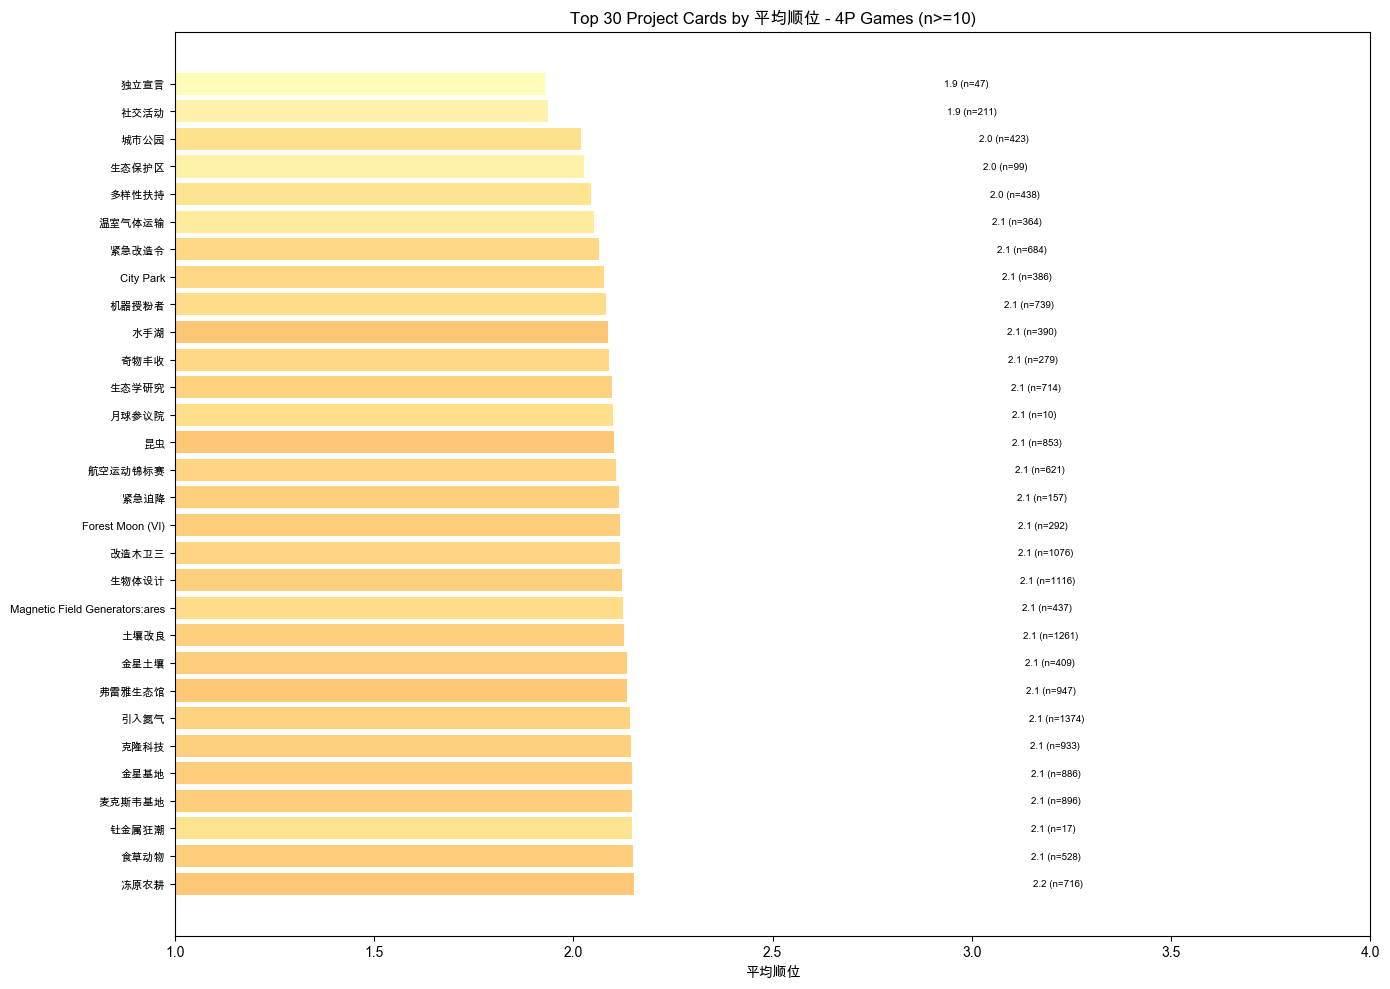

Saved: ./display/card_weighted_top30.png


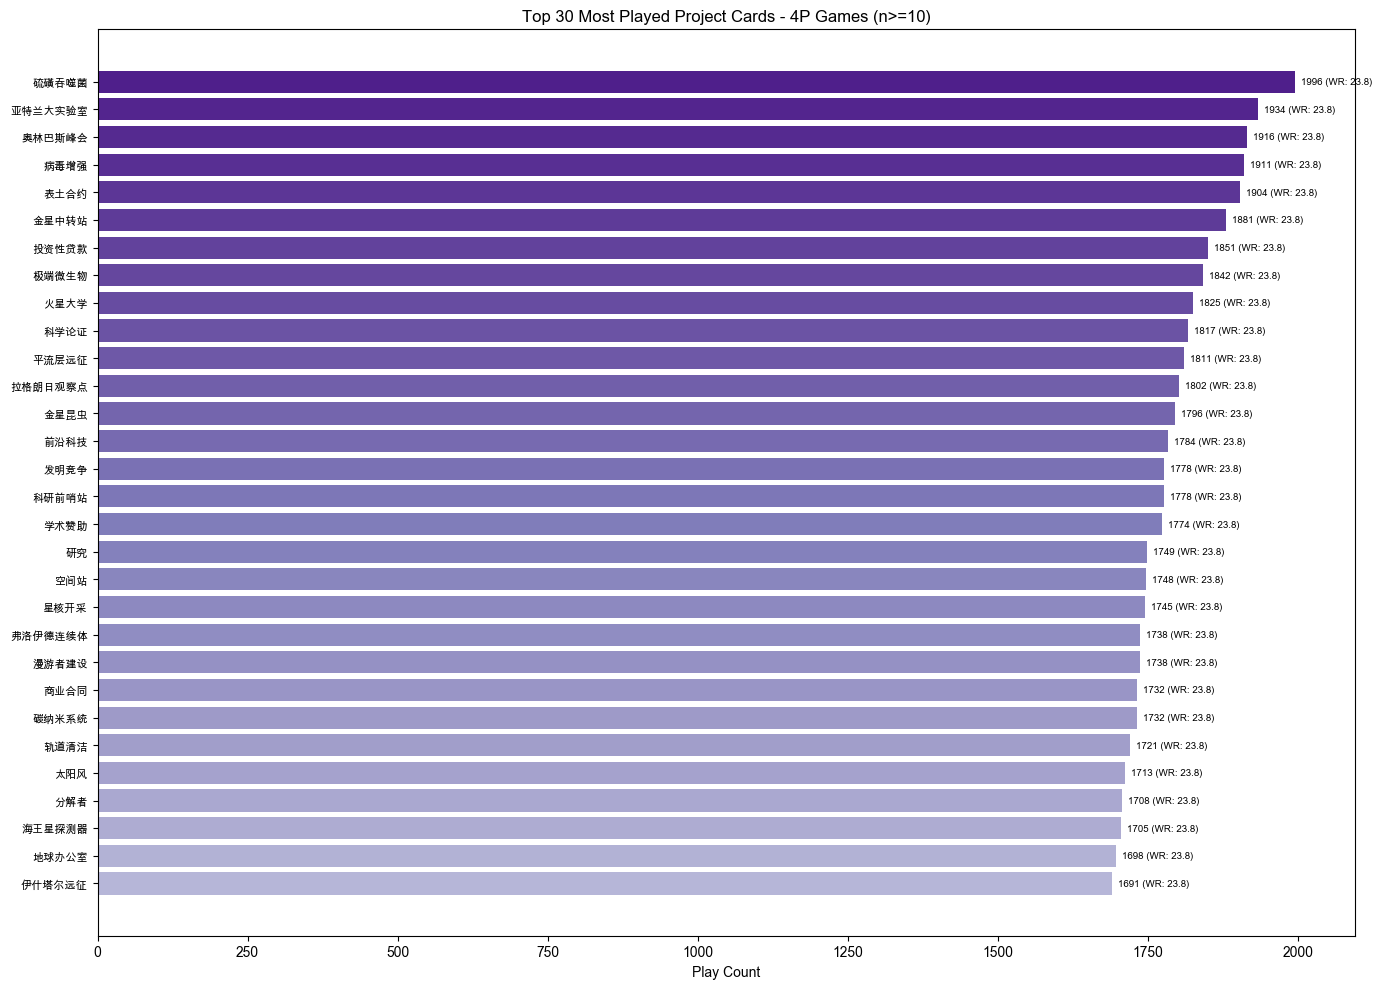

Saved: ./display/card_playcount_top30.png


In [24]:
# 6.5 Save Card Stats Data (Full + Filtered) and Visualize

if 'played_cards_df' in dir() and len(played_cards_df) > 0:
    # Save raw played cards data
    played_cards_df.to_csv(f'{DISPLAY_DIR}/played_cards_raw.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/played_cards_raw.csv ({len(played_cards_df)} rows)")

    # Re-analyze card stats using 4-player games only for accurate win rate
    # Filter to 4-player games and exclude preludes
    project_cards_df = played_cards_df[((~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])) & (played_cards_df['players'] == 4)].copy()
    card_stats_full = project_cards_df.groupby('card_name').agg(
        play_count=('game_id', 'count'),
        game_count=('game_id', 'nunique'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count'),
        avg_resources=('resource_count', 'mean')
    ).reset_index()
    card_stats_full = add_bayesian_weighted_avg(card_stats_full)
    card_stats_full['win_rate'] = (card_stats_full['wins'] / card_stats_full['play_count'] * 100).round(2)

    # Add cn_name column
    card_stats_full = add_cn_name_column(card_stats_full, 'card_name', CN_MAP)

    # Save FULL card stats data
    card_stats_full.to_csv(f'{DISPLAY_DIR}/card_stats_full.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/card_stats_full.csv ({len(card_stats_full)} rows)")

    # Save FILTERED card stats data
    card_stats_filtered = card_stats_full[card_stats_full['play_count'] >= MIN_SAMPLE_SIZE].copy()
    card_stats_filtered.to_csv(f'{DISPLAY_DIR}/card_stats_filtered.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/card_stats_filtered.csv ({len(card_stats_filtered)} rows)")

    # Visualization 1: Top 30 Cards by Weighted Score - FILTERED DATA
    fig, ax = plt.subplots(figsize=(14, 10))
    top30_winrate = card_stats_filtered.sort_values('weighted_avg_score', ascending=True).head(30)
    colors = plt.cm.RdYlGn(top30_winrate['win_rate'] / 100)
    bars = ax.barh(range(len(top30_winrate)), top30_winrate['weighted_avg_score'], color=colors)
    ax.set_yticks(range(len(top30_winrate)))
    ax.set_yticklabels(top30_winrate['cn_name_plot'], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('平均顺位')
    ax.set_title(f'Top 30 Project Cards by 平均顺位 - 4P Games (n>={MIN_SAMPLE_SIZE})')
    ax.set_xlim(1, 4)

    for bar, score, count in zip(bars, top30_winrate['weighted_avg_score'], top30_winrate['play_count']):
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{score:.1f} (n={count})', va='center', fontsize=7)

    plt.tight_layout()
    plt.savefig(f'{DISPLAY_DIR}/card_weighted_top30.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {DISPLAY_DIR}/card_weighted_top30.png")

    # Visualization 2: Top 30 Cards by Play Count - FILTERED DATA
    fig, ax = plt.subplots(figsize=(14, 10))
    top30_popular = card_stats_filtered.sort_values('play_count', ascending=False).head(30)
    colors = plt.cm.Purples(np.linspace(0.4, 0.9, len(top30_popular)))[::-1]
    bars = ax.barh(range(len(top30_popular)), top30_popular['play_count'], color=colors)
    ax.set_yticks(range(len(top30_popular)))
    ax.set_yticklabels(top30_popular['cn_name_plot'], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('Play Count')
    ax.set_title(f'Top 30 Most Played Project Cards - 4P Games (n>={MIN_SAMPLE_SIZE})')

    for bar, count, wr in zip(bars, top30_popular['play_count'], top30_popular['win_rate']):
        ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
                f'{count} (WR: {ws:.1f})', va='center', fontsize=7)

    plt.tight_layout()
    plt.savefig(f'{DISPLAY_DIR}/card_playcount_top30.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {DISPLAY_DIR}/card_playcount_top30.png")
else:
    print("No card stats data available")

Saved: ./display/card_stats_by_players_full.csv (3409 rows)
Saved: ./display/card_stats_by_players_filtered.csv (2510 rows)
Saved: ./display/card_4p_weighted_full.csv (758 rows)
Saved: ./display/card_4p_weighted_filtered.csv (664 rows)


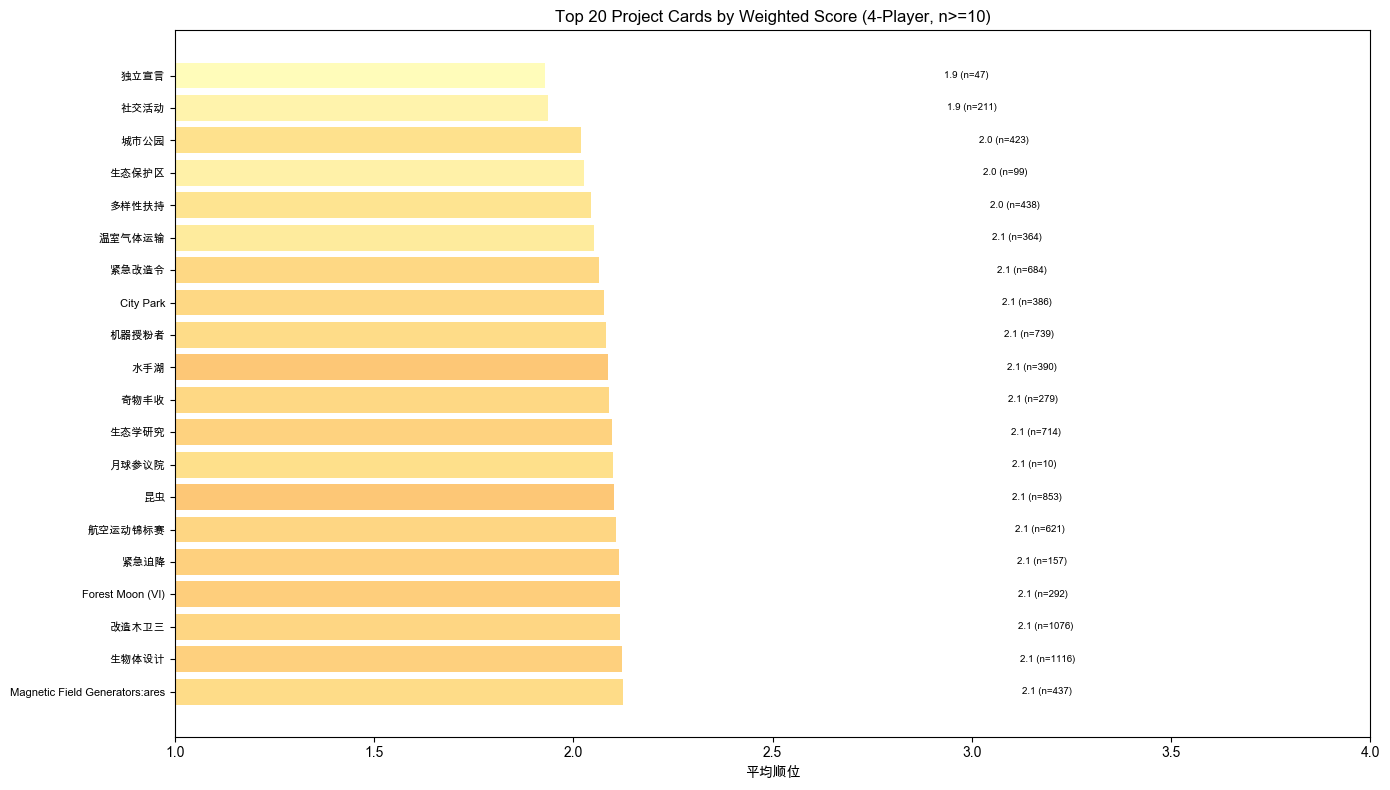

Saved: ./display/card_4p_weighted_top20.png


In [25]:
# 6.6 Save Card Stats by Player Count (Full + Filtered) and Visualize

if 'played_cards_df' in dir() and len(played_cards_df) > 0:
    # Re-analyze card stats by players without filter for full version
    project_cards_df = played_cards_df[(~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])].copy()
    card_by_players_full = project_cards_df.groupby(['card_name', 'players']).agg(
        play_count=('game_id', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
    ).reset_index()
    card_by_players_full = add_bayesian_weighted_avg(card_by_players_full)
    card_by_players_full['win_rate'] = (card_by_players_full['wins'] / card_by_players_full['play_count'] * 100).round(2)

    # Add cn_name column
    card_by_players_full = add_cn_name_column(card_by_players_full, 'card_name', CN_MAP)

    # Save FULL card stats by players data
    card_by_players_full.to_csv(f'{DISPLAY_DIR}/card_stats_by_players_full.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/card_stats_by_players_full.csv ({len(card_by_players_full)} rows)")

    # Save FILTERED card stats by players data
    card_by_players_filtered = card_by_players_full[card_by_players_full['play_count'] >= MIN_SAMPLE_SIZE].copy()
    card_by_players_filtered.to_csv(f'{DISPLAY_DIR}/card_stats_by_players_filtered.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/card_stats_by_players_filtered.csv ({len(card_by_players_filtered)} rows)")

    # 4-player card ranking - Full and Filtered
    card_4p_full = card_by_players_full[card_by_players_full['players'] == 4].sort_values('weighted_avg_score', ascending=True)
    card_4p_filtered = card_by_players_filtered[card_by_players_filtered['players'] == 4].sort_values('weighted_avg_score', ascending=True)

    card_4p_full.to_csv(f'{DISPLAY_DIR}/card_4p_weighted_full.csv', index=False)
    card_4p_filtered.to_csv(f'{DISPLAY_DIR}/card_4p_weighted_filtered.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/card_4p_weighted_full.csv ({len(card_4p_full)} rows)")
    print(f"Saved: {DISPLAY_DIR}/card_4p_weighted_filtered.csv ({len(card_4p_filtered)} rows)")

    # Visualization: Top 20 Cards in 4-Player Games - FILTERED DATA
    if len(card_4p_filtered) > 0:
        fig, ax = plt.subplots(figsize=(14, 8))
        top20_4p = card_4p_filtered.head(20)
        colors = plt.cm.RdYlGn(top20_4p['win_rate'] / 100)
        bars = ax.barh(range(len(top20_4p)), top20_4p['weighted_avg_score'], color=colors)
        ax.set_yticks(range(len(top20_4p)))
        ax.set_yticklabels(top20_4p['cn_name_plot'], fontsize=8)
        ax.invert_yaxis()
        ax.set_xlabel('平均顺位')
        ax.set_title(f'Top 20 Project Cards by Weighted Score (4-Player, n>={MIN_SAMPLE_SIZE})')
        ax.set_xlim(1, 4)

        for bar, score, count in zip(bars, top20_4p['weighted_avg_score'], top20_4p['play_count']):
            ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{score:.1f} (n={count})', va='center', fontsize=7)

        plt.tight_layout()
        plt.savefig(f'{DISPLAY_DIR}/card_4p_weighted_top20.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {DISPLAY_DIR}/card_4p_weighted_top20.png")
else:
    print("No card by players data available")

Saved: ./display/card_corporation_synergy_full.csv (62211 rows)
Saved: ./display/card_corporation_synergy_filtered.csv (28543 rows)


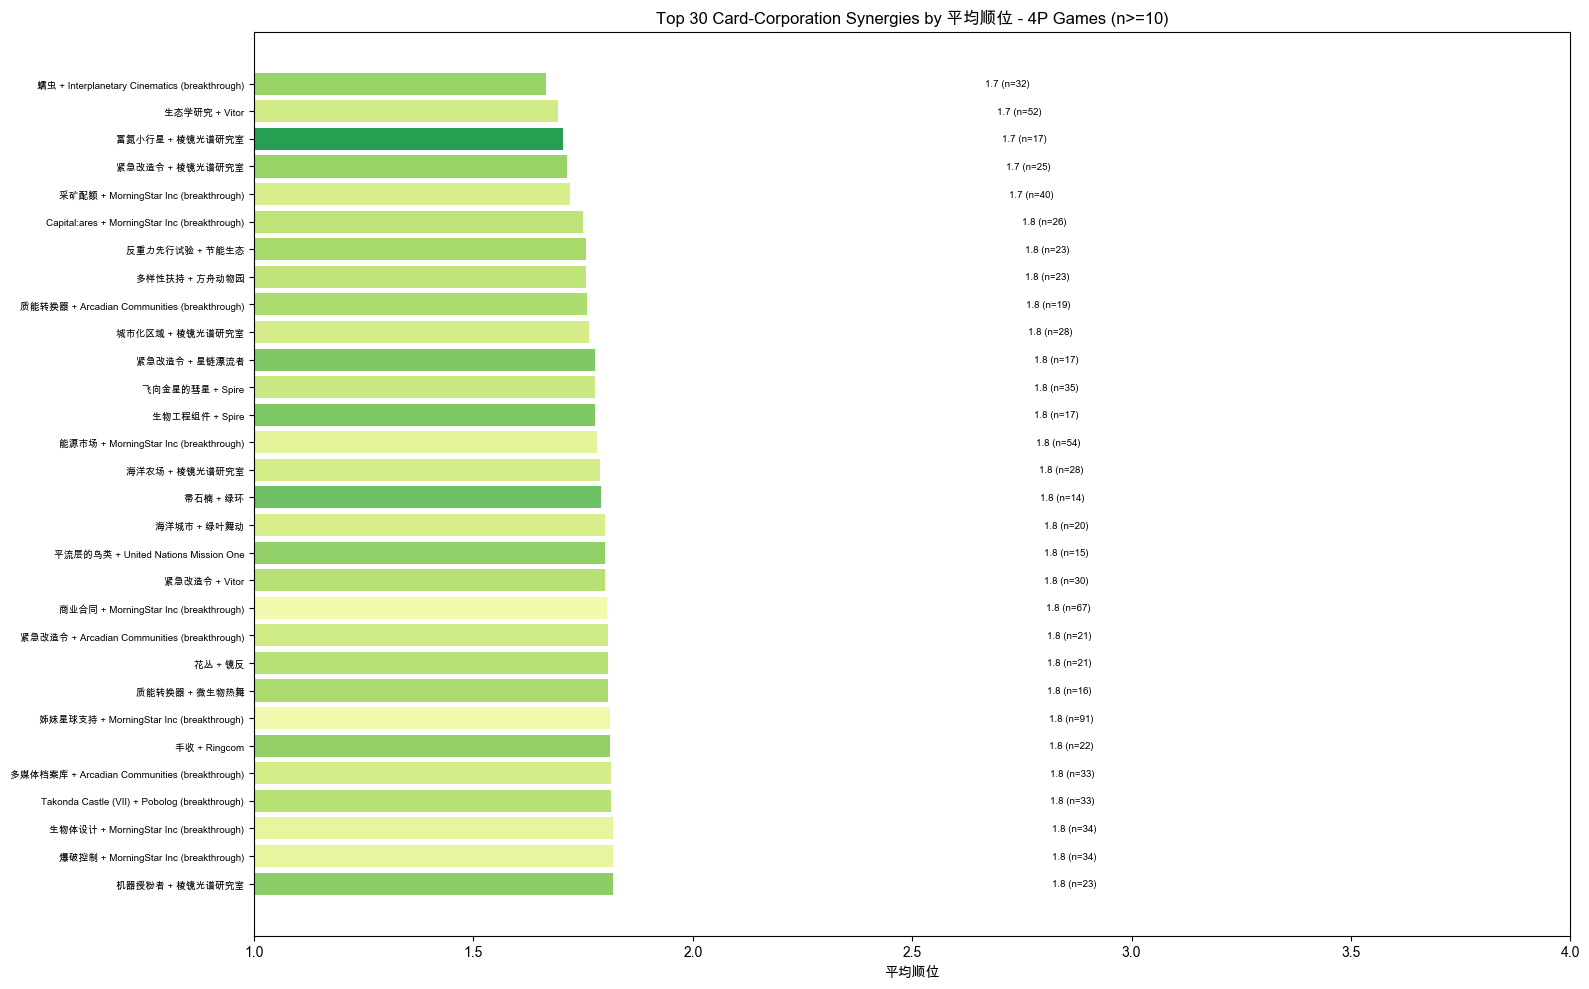

Saved: ./display/card_corporation_synergy_top30.png


In [26]:
# 6.7 Save Card-Corporation Synergy Data (Full + Filtered) and Visualize

if 'played_cards_df' in dir() and len(played_cards_df) > 0:
    # Re-analyze synergy using 4-player games only for accurate win rate
    project_cards_df = played_cards_df[((~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])) & (played_cards_df['players'] == 4)].copy()

    synergy_records = []
    for _, row in project_cards_df.iterrows():
        corps = split_corporations(row['corporation'])
        for corp in corps:
            synergy_records.append({
                'card_name': row['card_name'],
                'corporation': corp,
                'position': row['position'],
                'player_score': row['player_score'],
                'weighted_score': row['weighted_score']
            })

    if synergy_records:
        synergy_temp_df = pd.DataFrame(synergy_records)
        synergy_full = synergy_temp_df.groupby(['card_name', 'corporation']).agg(
            play_count=('position', 'count'),
            wins=('position', lambda x: (x == 1).sum()),
            avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
        ).reset_index()
        synergy_full = add_bayesian_weighted_avg(synergy_full)
        synergy_full['win_rate'] = (synergy_full['wins'] / synergy_full['play_count'] * 100).round(2)
        synergy_full = synergy_full.sort_values('weighted_avg_score', ascending=True)

        # Add cn_name columns for both card and corporation
        synergy_full['card_cn_name'] = synergy_full['card_name'].apply(lambda x: CN_MAP.get(x, x))
        synergy_full['corp_cn_name'] = synergy_full['corporation'].apply(lambda x: CN_MAP.get(x, x))

        # Save FULL synergy data
        synergy_full.to_csv(f'{DISPLAY_DIR}/card_corporation_synergy_full.csv', index=False)
        print(f"Saved: {DISPLAY_DIR}/card_corporation_synergy_full.csv ({len(synergy_full)} rows)")

        # Save FILTERED synergy data
        synergy_filtered = synergy_full[synergy_full['play_count'] >= MIN_SAMPLE_SIZE].copy()
        synergy_filtered.to_csv(f'{DISPLAY_DIR}/card_corporation_synergy_filtered.csv', index=False)
        print(f"Saved: {DISPLAY_DIR}/card_corporation_synergy_filtered.csv ({len(synergy_filtered)} rows)")

        # Visualization: Top 30 Card-Corporation Synergies - FILTERED DATA
        if len(synergy_filtered) > 0:
            fig, ax = plt.subplots(figsize=(16, 10))
            top30_synergy = synergy_filtered.head(30)
            labels = [f"{strip_emoji(row['card_cn_name'])} + {strip_emoji(row['corp_cn_name'])}" for _, row in top30_synergy.iterrows()]
            colors = plt.cm.RdYlGn(top30_synergy['win_rate'] / 100)
            bars = ax.barh(range(len(top30_synergy)), top30_synergy['weighted_avg_score'], color=colors)
            ax.set_yticks(range(len(top30_synergy)))
            ax.set_yticklabels(labels, fontsize=7)
            ax.invert_yaxis()
            ax.set_xlabel('平均顺位')
            ax.set_title(f'Top 30 Card-Corporation Synergies by 平均顺位 - 4P Games (n>={MIN_SAMPLE_SIZE})')
            ax.set_xlim(1, 4)

            for bar, score, count in zip(bars, top30_synergy['weighted_avg_score'], top30_synergy['play_count']):
                ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                        f'{score:.1f} (n={count})', va='center', fontsize=7)

            plt.tight_layout()
            plt.savefig(f'{DISPLAY_DIR}/card_corporation_synergy_top30.png', dpi=150, bbox_inches='tight')
            plt.show()
            print(f"Saved: {DISPLAY_DIR}/card_corporation_synergy_top30.png")
else:
    print("No synergy data available")

In [27]:
# 6.8 Summary: List all exported files

print("=" * 70)
print("EXPORT SUMMARY - All files saved to ./display/")
print(f"Minimum sample size for filtered data: {MIN_SAMPLE_SIZE}")
print("=" * 70)

# List all files in display folder
display_files = sorted(os.listdir(DISPLAY_DIR))
csv_files = [f for f in display_files if f.endswith('.csv')]
png_files = [f for f in display_files if f.endswith('.png')]

# Separate full and filtered files
full_files = [f for f in csv_files if '_full' in f or '_raw' in f]
filtered_files = [f for f in csv_files if '_filtered' in f]

print("\nCSV Files - FULL (complete data, no filtering):")
print("-" * 50)
for f in full_files:
    file_path = os.path.join(DISPLAY_DIR, f)
    size_kb = os.path.getsize(file_path) / 1024
    print(f"  - {f} ({size_kb:.1f} KB)")

print(f"\nCSV Files - FILTERED (n>={MIN_SAMPLE_SIZE}):")
print("-" * 50)
for f in filtered_files:
    file_path = os.path.join(DISPLAY_DIR, f)
    size_kb = os.path.getsize(file_path) / 1024
    print(f"  - {f} ({size_kb:.1f} KB)")

print(f"\nTotal CSV files: {len(csv_files)} (Full: {len(full_files)}, Filtered: {len(filtered_files)})")

print("\nVisualization Files (PNG) - Based on FILTERED data:")
print("-" * 50)
for f in png_files:
    file_path = os.path.join(DISPLAY_DIR, f)
    size_kb = os.path.getsize(file_path) / 1024
    print(f"  - {f} ({size_kb:.1f} KB)")

print(f"\nTotal PNG files: {len(png_files)}")
print("=" * 70)
print("Export complete!")

EXPORT SUMMARY - All files saved to ./display/
Minimum sample size for filtered data: 10

CSV Files - FULL (complete data, no filtering):
--------------------------------------------------
  - card_4p_weighted_full.csv (93.6 KB)
  - card_4p_winrate_full.csv (75.0 KB)
  - card_corporation_synergy_full.csv (6830.9 KB)
  - card_stats_2p_full.csv (91.8 KB)
  - card_stats_4p_full.csv (90.6 KB)
  - card_stats_by_players_full.csv (394.9 KB)
  - card_stats_full.csv (97.9 KB)
  - corporation_4p_weighted_full.csv (18.4 KB)
  - corporation_4p_winrate_full.csv (17.3 KB)
  - corporation_combinations_full.csv (478.6 KB)
  - corporation_popularity_full.csv (14.0 KB)
  - corporation_usage_full.csv (71.3 KB)
  - played_cards_raw.csv (235680.3 KB)
  - prelude_stats_2p_full.csv (12.3 KB)
  - prelude_stats_4p_full.csv (12.8 KB)
  - prelude_stats_full.csv (14.5 KB)
  - prelude_usage_raw.csv (6618.3 KB)

CSV Files - FILTERED (n>=10):
--------------------------------------------------
  - card_4p_weighted_fi

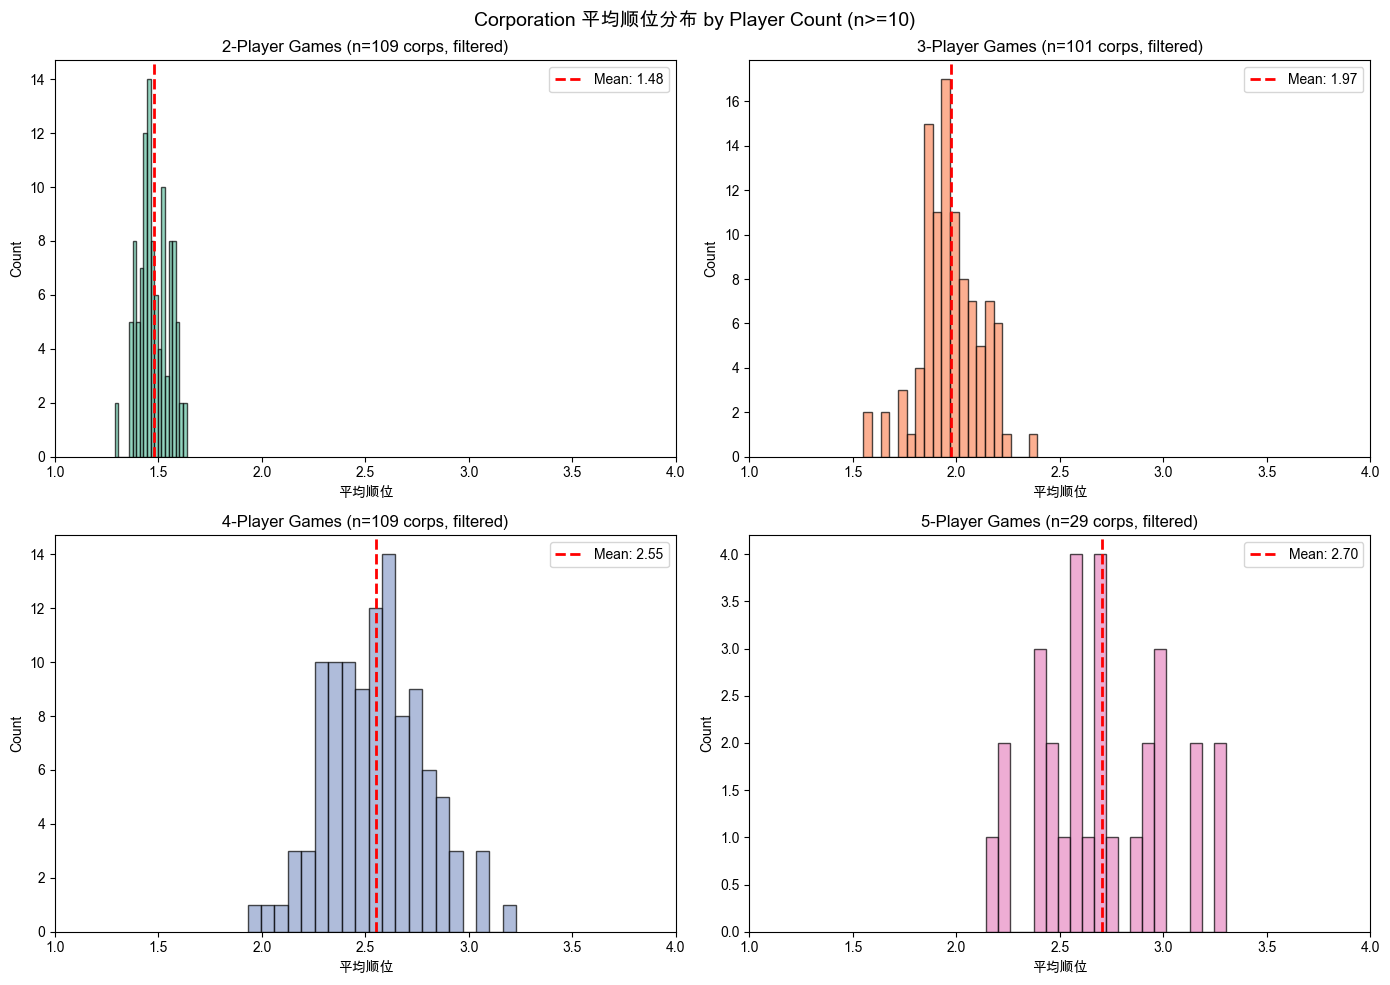

Saved: ./display/corporation_weighted_distribution.png


/var/folders/kt/jh5yr5kn50v_xx9qcjdrw3p40000gn/T/ipykernel_68495/2335229528.py:46: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Arial Unicode MS.
  plt.tight_layout()
/var/folders/kt/jh5yr5kn50v_xx9qcjdrw3p40000gn/T/ipykernel_68495/2335229528.py:47: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Arial Unicode MS.
  plt.savefig(f'{DISPLAY_DIR}/corporation_comparison_by_players.png', dpi=150, bbox_inches='tight')
/Users/oushuohuang/Documents/tfm-data/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Arial Unicode MS.
  fig.canvas.print_figure(bytes_io, **kw)


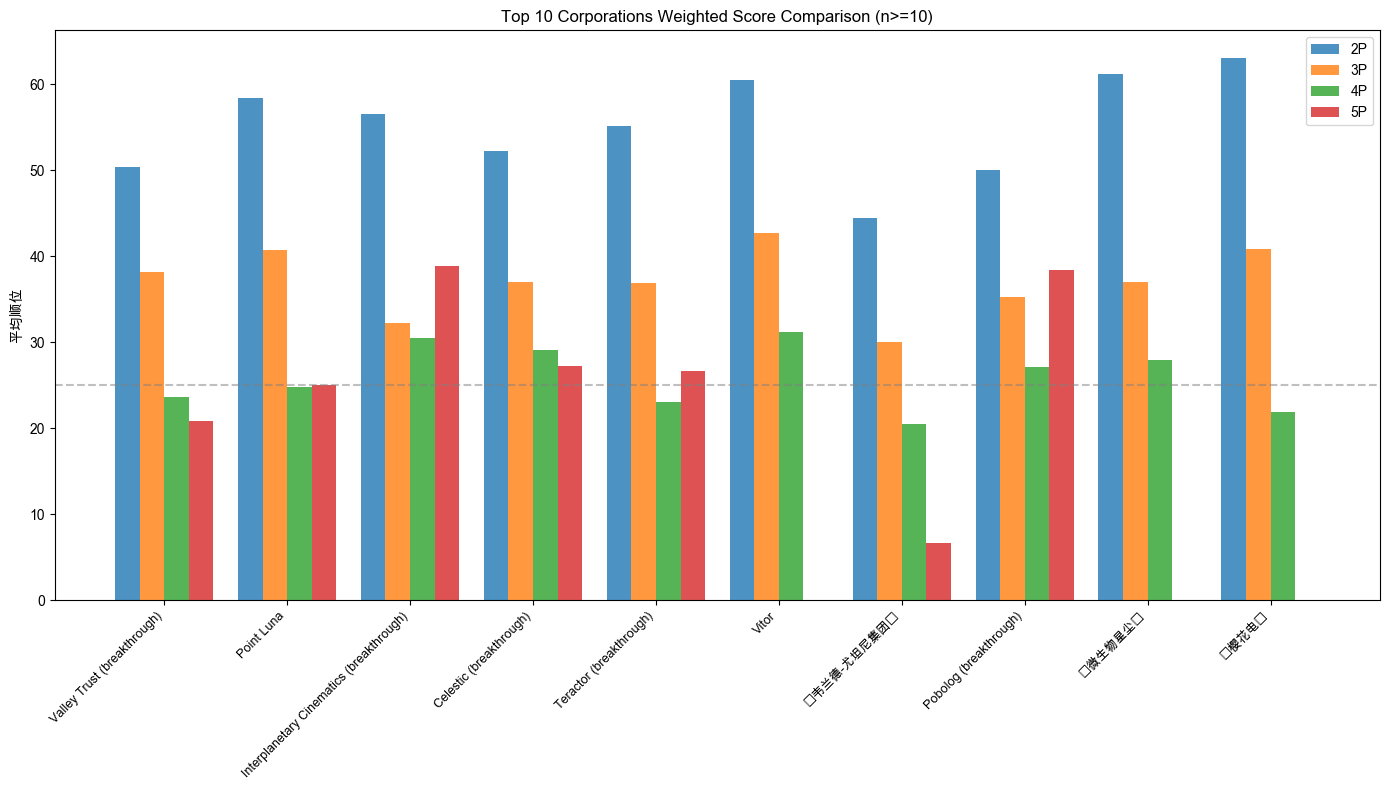

Saved: ./display/corporation_comparison_by_players.png


In [28]:
# 6.9 Additional Visualizations: Weighted Score Distribution and Comparison (FILTERED)

# 1. Corporation 平均顺位分布 by Player Count - Using FILTERED data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, players in enumerate([2, 3, 4, 5]):
    ax = axes[idx // 2, idx % 2]
    data = corp_usage_filtered[corp_usage_filtered['players'] == players]['weighted_avg_score']
    if len(data) > 0:
        ax.hist(data, bins=20, color=plt.cm.Set2(idx), edgecolor='black', alpha=0.7)
        ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
        ax.set_xlim(1, 4)
        ax.set_xlabel('平均顺位')
        ax.set_ylabel('Count')
        ax.set_title(f'{players}-Player Games (n={len(data)} corps, filtered)')
        ax.legend()

plt.suptitle(f'Corporation 平均顺位分布 by Player Count (n>={MIN_SAMPLE_SIZE})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{DISPLAY_DIR}/corporation_weighted_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {DISPLAY_DIR}/corporation_weighted_distribution.png")

# 2. Top 10 Corporations Comparison Across Player Counts - Using FILTERED data
corp_multi_player = corp_usage_filtered.groupby('corporation').filter(lambda x: len(x) >= 3)
if len(corp_multi_player) > 0:
    top_corps = corp_multi_player.groupby('corporation')['total_games'].sum().nlargest(10).index.tolist()

    fig, ax = plt.subplots(figsize=(14, 8))
    width = 0.2
    x = np.arange(len(top_corps))

    for i, players in enumerate([2, 3, 4, 5]):
        data = corp_usage_filtered[(corp_usage_filtered['players'] == players) & (corp_usage_filtered['corporation'].isin(top_corps))]
        win_rates = [data[data['corporation'] == c]['win_rate'].values[0] if c in data['corporation'].values else 0 for c in top_corps]
        ax.bar(x + i * width, win_rates, width, label=f'{players}P', alpha=0.8)

    ax.set_xticks(x + width * 1.5)
    top_corps_cn = [CN_MAP.get(c, c) for c in top_corps]
    ax.set_xticklabels(top_corps_cn, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('平均顺位')
    ax.set_title(f'Top 10 Corporations Weighted Score Comparison (n>={MIN_SAMPLE_SIZE})')
    ax.legend()
    ax.axhline(y=25, color='gray', linestyle='--', alpha=0.5, label='Expected 4P')

    plt.tight_layout()
    plt.savefig(f'{DISPLAY_DIR}/corporation_comparison_by_players.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {DISPLAY_DIR}/corporation_comparison_by_players.png")

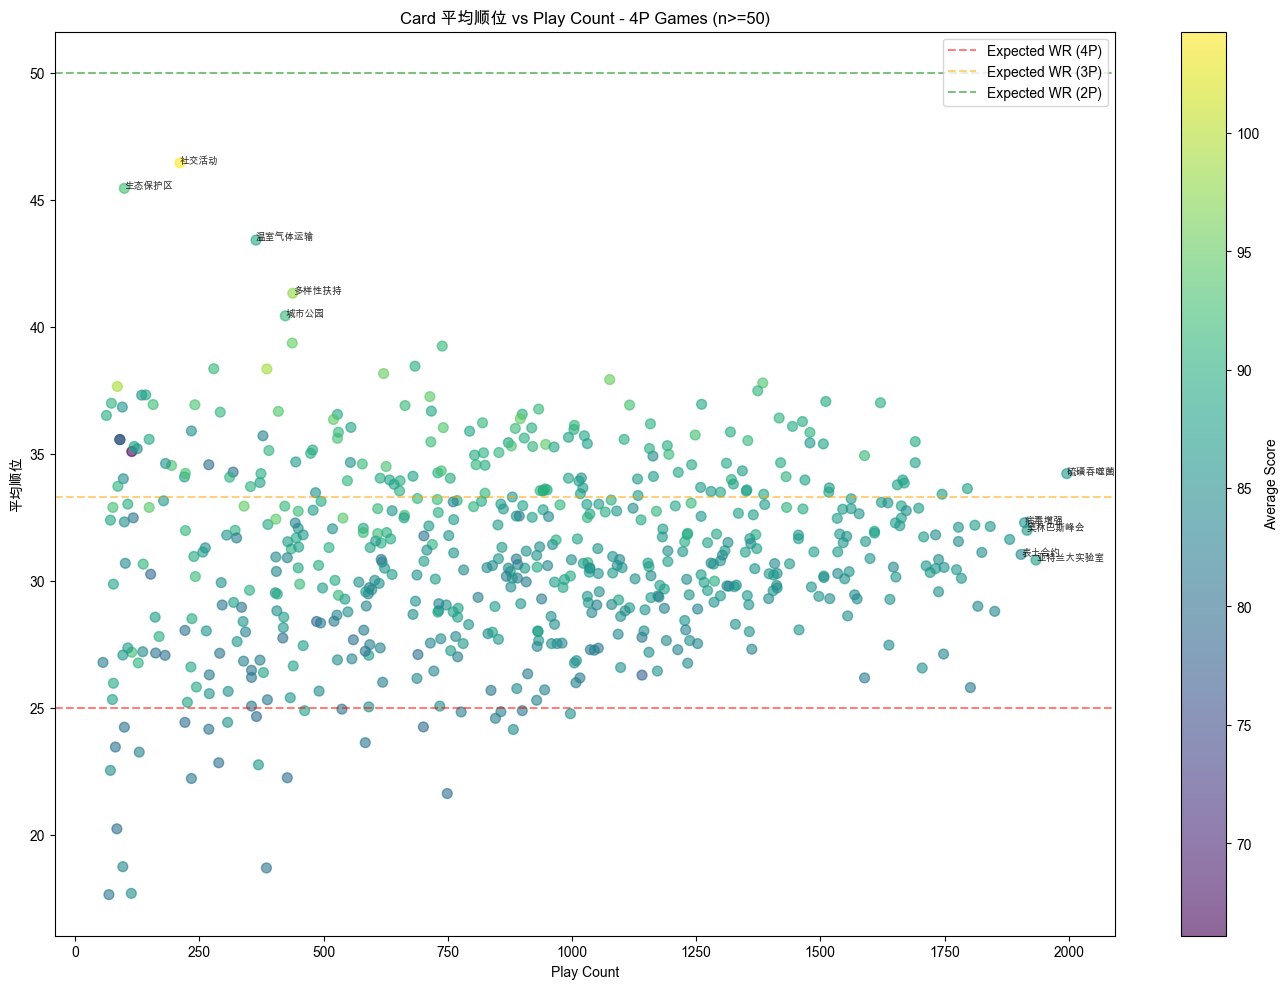

Saved: ./display/card_weighted_vs_playcount.png


In [29]:
# 6.10 Card 平均顺位 vs Play Count Scatter Plot (FILTERED)

if 'card_stats_filtered' in dir() and len(card_stats_filtered) > 0:
    fig, ax = plt.subplots(figsize=(14, 10))

    # Use filtered data (already filtered by MIN_SAMPLE_SIZE)
    # Additionally filter to cards with at least 50 plays for clearer visualization
    plot_data = card_stats_filtered[card_stats_filtered['play_count'] >= 50].copy()

    if len(plot_data) > 0:
        scatter = ax.scatter(
            plot_data['play_count'],
            plot_data['win_rate'],
            c=plot_data['avg_score'],
            cmap='viridis',
            s=50,
            alpha=0.6
        )

        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Average Score')

        # Add reference lines
        ax.axhline(y=25, color='red', linestyle='--', alpha=0.5, label='Expected WR (4P)')
        ax.axhline(y=33.3, color='orange', linestyle='--', alpha=0.5, label='Expected WR (3P)')
        ax.axhline(y=50, color='green', linestyle='--', alpha=0.5, label='Expected WR (2P)')

        # Label some interesting points
        top_wr = plot_data.nlargest(5, 'win_rate')
        top_pop = plot_data.nlargest(5, 'play_count')

        for _, row in pd.concat([top_wr, top_pop]).drop_duplicates().iterrows():
            ax.annotate(
                row['cn_name_plot'][:15],
                (row['play_count'], row['win_rate']),
                fontsize=7,
                alpha=0.8
            )

        ax.set_xlabel('Play Count')
        ax.set_ylabel('平均顺位')
        ax.set_title(f'Card 平均顺位 vs Play Count - 4P Games (n>=50)')
        ax.legend(loc='upper right')

        plt.tight_layout()
        plt.savefig(f'{DISPLAY_DIR}/card_weighted_vs_playcount.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {DISPLAY_DIR}/card_weighted_vs_playcount.png")
    else:
        print("Not enough cards with 50+ plays for scatter plot")

## 7. Prelude and Card Stats by Player Count (2P vs 4P)

Saved: ./display/prelude_stats_2p_full.csv (108 rows)
Saved: ./display/prelude_stats_2p_filtered.csv (88 rows)


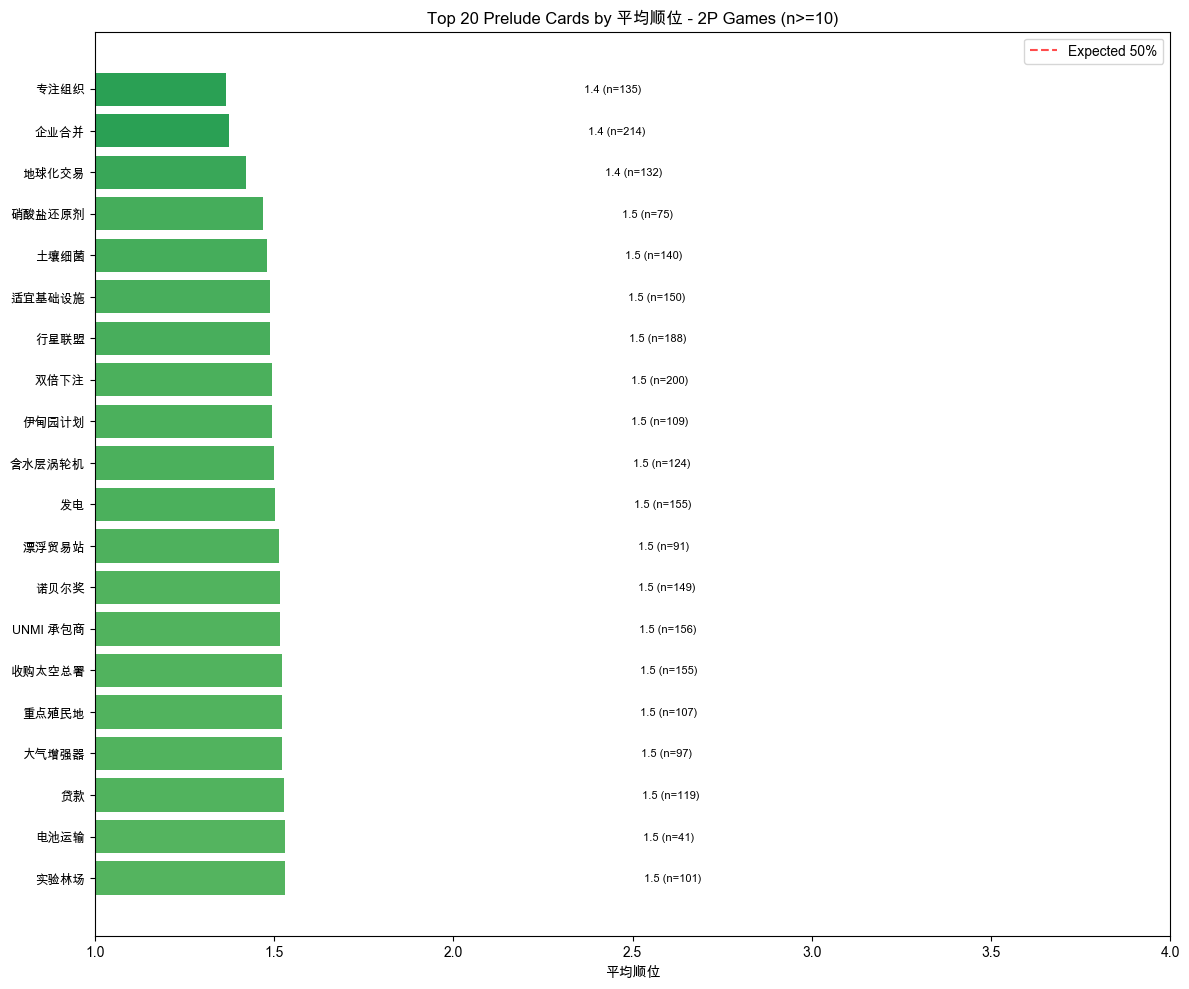

Saved: ./display/prelude_2p_weighted_top20.png
Saved: ./display/prelude_stats_4p_full.csv (109 rows)
Saved: ./display/prelude_stats_4p_filtered.csv (91 rows)


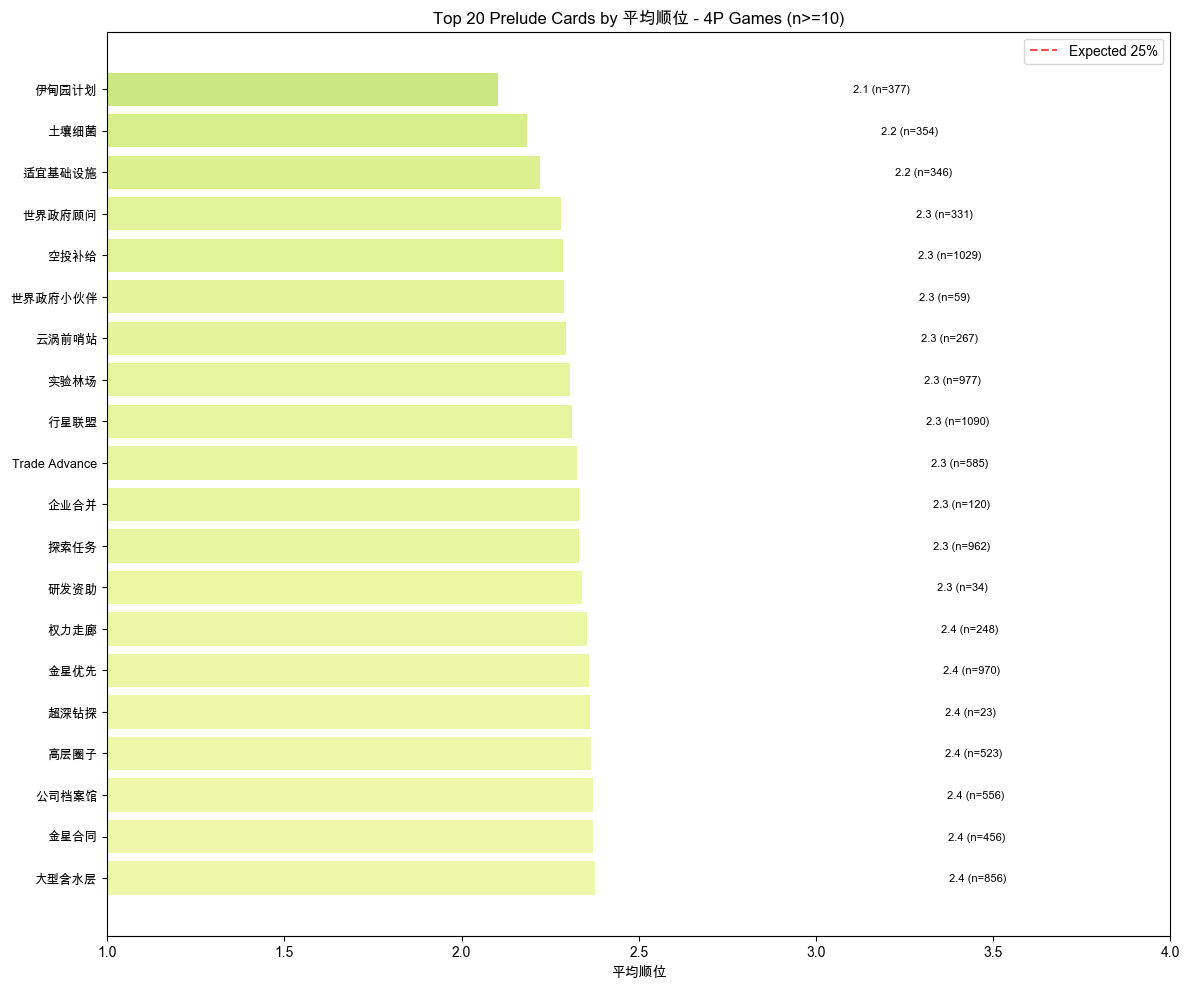

Saved: ./display/prelude_4p_weighted_top20.png


In [30]:
# 7.1 Prelude Stats by Player Count (2P vs 4P)

if 'prelude_df' in dir() and len(prelude_df) > 0:
    # Calculate prelude stats for 2P and 4P separately
    for players in [2, 4]:
        prelude_df_filtered = prelude_df[prelude_df['players'] == players].copy()

        if len(prelude_df_filtered) > 0:
            prelude_stats = prelude_df_filtered.groupby('prelude_name').agg(
                total_uses=('game_id', 'count'),
                wins=('position', lambda x: (x == 1).sum()),
                avg_position=('position', 'mean'),
                avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
            ).reset_index()
            prelude_stats = add_bayesian_weighted_avg(prelude_stats)
            prelude_stats['win_rate'] = (prelude_stats['wins'] / prelude_stats['total_uses'] * 100).round(2)
            prelude_stats = prelude_stats.sort_values('weighted_avg_score', ascending=True)

            # Add cn_name column
            prelude_stats = add_cn_name_column(prelude_stats, 'prelude_name', CN_MAP)

            # Save full and filtered versions
            prelude_stats.to_csv(f'{DISPLAY_DIR}/prelude_stats_{players}p_full.csv', index=False)
            print(f"Saved: {DISPLAY_DIR}/prelude_stats_{players}p_full.csv ({len(prelude_stats)} rows)")

            prelude_stats_filtered = prelude_stats[prelude_stats['total_uses'] >= MIN_SAMPLE_SIZE].copy()
            prelude_stats_filtered.to_csv(f'{DISPLAY_DIR}/prelude_stats_{players}p_filtered.csv', index=False)
            print(f"Saved: {DISPLAY_DIR}/prelude_stats_{players}p_filtered.csv ({len(prelude_stats_filtered)} rows)")

            # Visualization
            if len(prelude_stats_filtered) > 0:
                fig, ax = plt.subplots(figsize=(12, 10))
                top20 = prelude_stats_filtered.head(20)
                colors = plt.cm.RdYlGn(np.clip((4 - top20['weighted_avg_score']) / 3, 0, 1))
                bars = ax.barh(range(len(top20)), top20['weighted_avg_score'], color=colors)
                ax.set_yticks(range(len(top20)))
                ax.set_yticklabels(top20['cn_name_plot'], fontsize=9)
                ax.invert_yaxis()
                ax.set_xlabel('平均顺位')

                # Expected win rate line
                expected_wr = 50 if players == 2 else 25
                ax.axvline(x=expected_wr, color='red', linestyle='--', alpha=0.7, label=f'Expected {expected_wr}%')
                ax.legend()

                ax.set_title(f'Top 20 Prelude Cards by 平均顺位 - {players}P Games (n>={MIN_SAMPLE_SIZE})')
                ax.set_xlim(1, 4)

                for bar, score, uses in zip(bars, top20['weighted_avg_score'], top20['total_uses']):
                    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                            f'{score:.1f} (n={uses})', va='center', fontsize=8)

                plt.tight_layout()
                plt.savefig(f'{DISPLAY_DIR}/prelude_{players}p_weighted_top20.png', dpi=150, bbox_inches='tight')
                plt.show()
                print(f"Saved: {DISPLAY_DIR}/prelude_{players}p_weighted_top20.png")
else:
    print("No prelude data available")

Saved: ./display/card_stats_2p_full.csv (763 rows)
Saved: ./display/card_stats_2p_filtered.csv (713 rows)


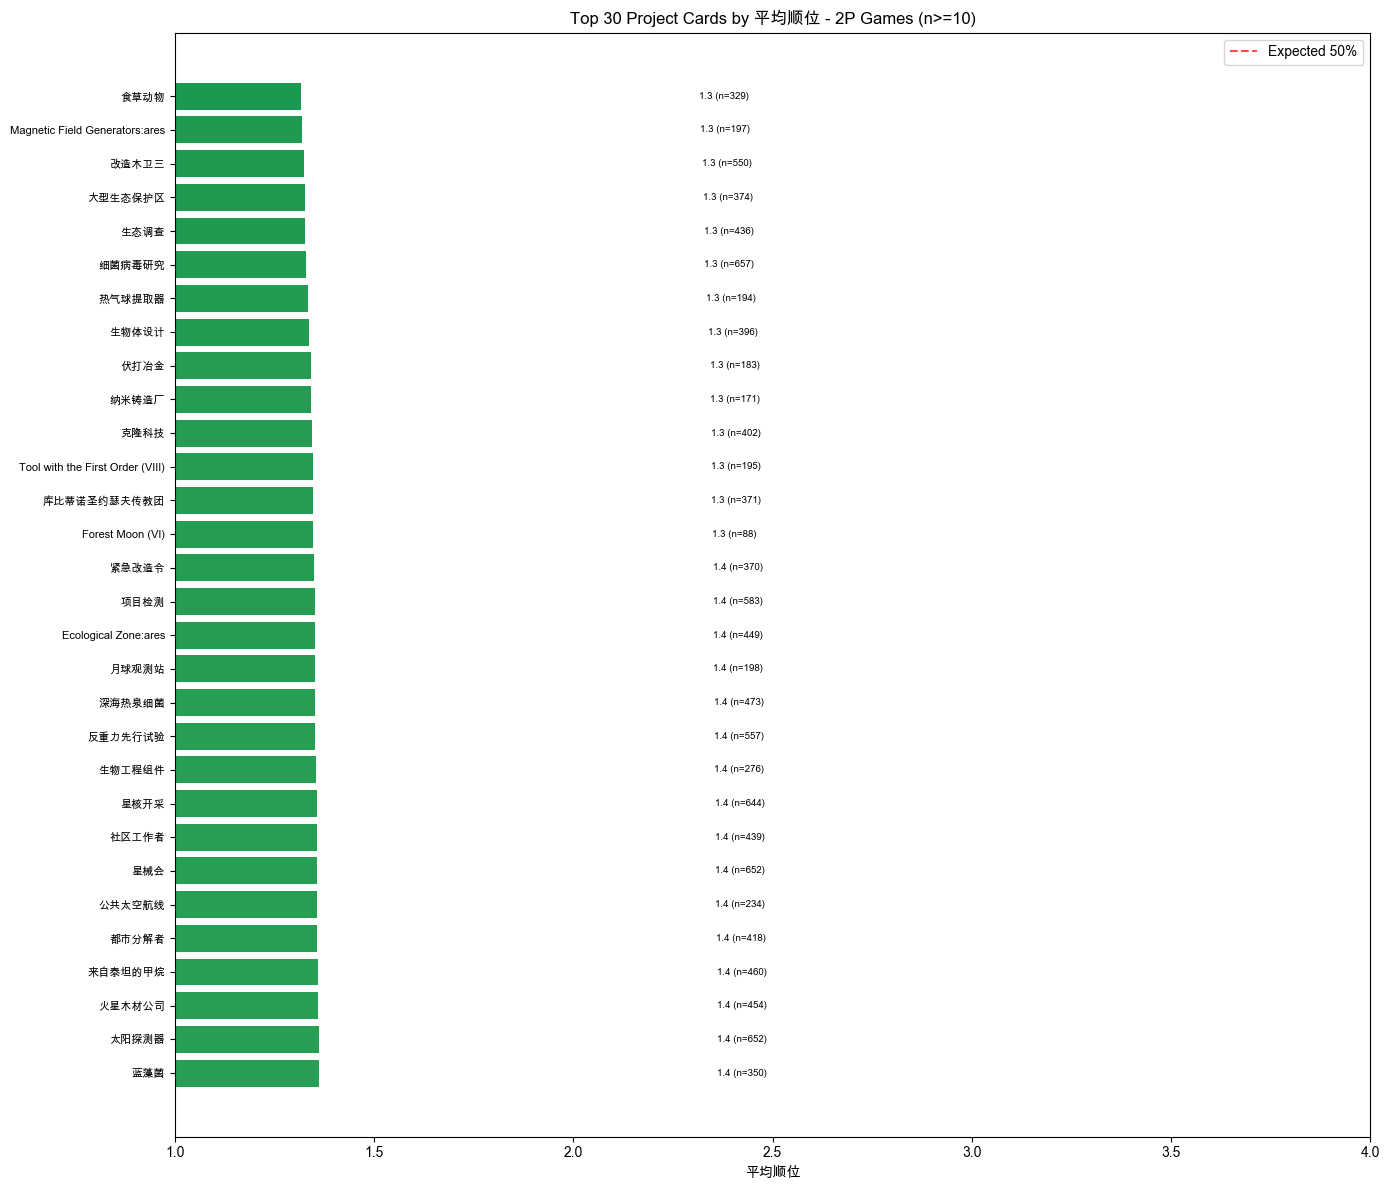

Saved: ./display/card_2p_weighted_top30.png
Saved: ./display/card_stats_4p_full.csv (758 rows)
Saved: ./display/card_stats_4p_filtered.csv (664 rows)


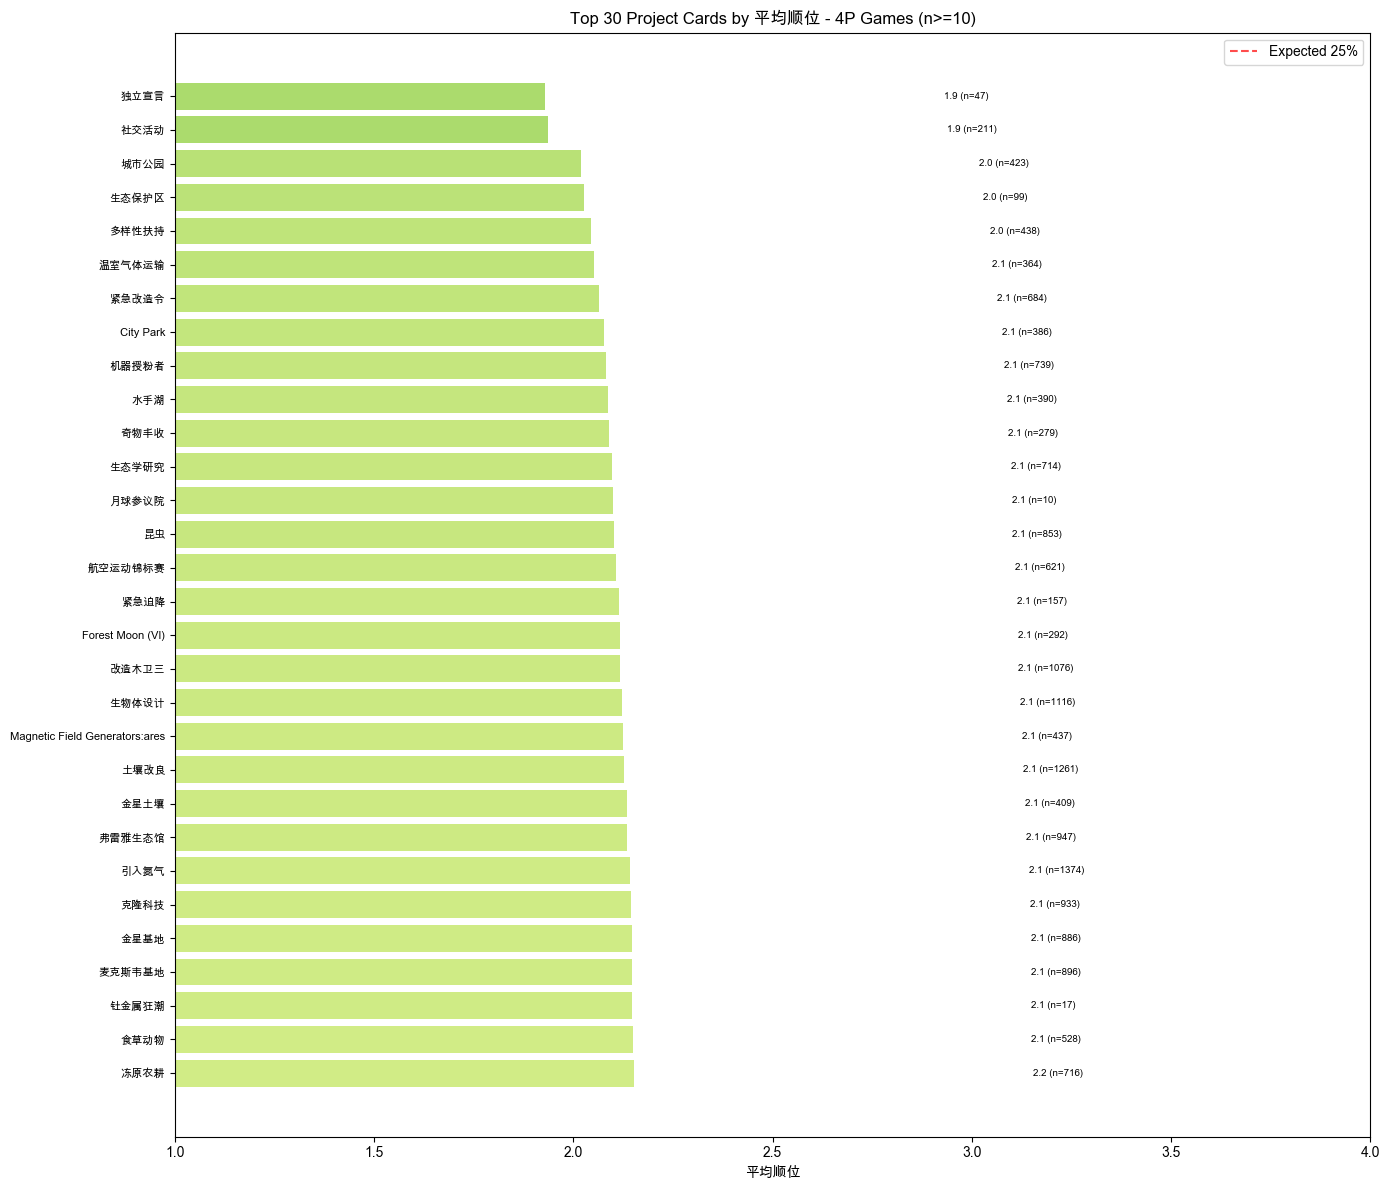

Saved: ./display/card_4p_weighted_top30.png


In [31]:
# 7.2 Card Stats by Player Count (2P vs 4P)

if 'played_cards_df' in dir() and len(played_cards_df) > 0:
    # Calculate card stats for 2P and 4P separately
    for players in [2, 4]:
        cards_df_filtered = played_cards_df[((~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])) & (played_cards_df['players'] == players)].copy()

        if len(cards_df_filtered) > 0:
            card_stats = cards_df_filtered.groupby('card_name').agg(
                play_count=('game_id', 'count'),
                wins=('position', lambda x: (x == 1).sum()),
                avg_position=('position', 'mean'),
                avg_score=('player_score', 'mean'),
        total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
            ).reset_index()
            card_stats = add_bayesian_weighted_avg(card_stats)
            card_stats['win_rate'] = (card_stats['wins'] / card_stats['play_count'] * 100).round(2)
            card_stats = card_stats.sort_values('weighted_avg_score', ascending=True)

            # Add cn_name column
            card_stats = add_cn_name_column(card_stats, 'card_name', CN_MAP)

            # Save full and filtered versions
            card_stats.to_csv(f'{DISPLAY_DIR}/card_stats_{players}p_full.csv', index=False)
            print(f"Saved: {DISPLAY_DIR}/card_stats_{players}p_full.csv ({len(card_stats)} rows)")

            card_stats_filtered = card_stats[card_stats['play_count'] >= MIN_SAMPLE_SIZE].copy()
            card_stats_filtered.to_csv(f'{DISPLAY_DIR}/card_stats_{players}p_filtered.csv', index=False)
            print(f"Saved: {DISPLAY_DIR}/card_stats_{players}p_filtered.csv ({len(card_stats_filtered)} rows)")

            # Visualization - Top 30 by Weighted Score
            if len(card_stats_filtered) > 0:
                fig, ax = plt.subplots(figsize=(14, 12))
                top30 = card_stats_filtered.head(30)
                colors = plt.cm.RdYlGn(np.clip((4 - top30['weighted_avg_score']) / 3, 0, 1))
                bars = ax.barh(range(len(top30)), top30['weighted_avg_score'], color=colors)
                ax.set_yticks(range(len(top30)))
                ax.set_yticklabels(top30['cn_name_plot'], fontsize=8)
                ax.invert_yaxis()
                ax.set_xlabel('平均顺位')

                # Expected win rate line
                expected_wr = 50 if players == 2 else 25
                ax.axvline(x=expected_wr, color='red', linestyle='--', alpha=0.7, label=f'Expected {expected_wr}%')
                ax.legend()

                ax.set_title(f'Top 30 Project Cards by 平均顺位 - {players}P Games (n>={MIN_SAMPLE_SIZE})')
                ax.set_xlim(1, 4)

                for bar, score, count in zip(bars, top30['weighted_avg_score'], top30['play_count']):
                    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                            f'{score:.1f} (n={count})', va='center', fontsize=7)

                plt.tight_layout()
                plt.savefig(f'{DISPLAY_DIR}/card_{players}p_weighted_top30.png', dpi=150, bbox_inches='tight')
                plt.show()
                print(f"Saved: {DISPLAY_DIR}/card_{players}p_weighted_top30.png")
else:
    print("No card data available")

Saved: ./display/card_2p_vs_4p_comparison.csv (657 rows)


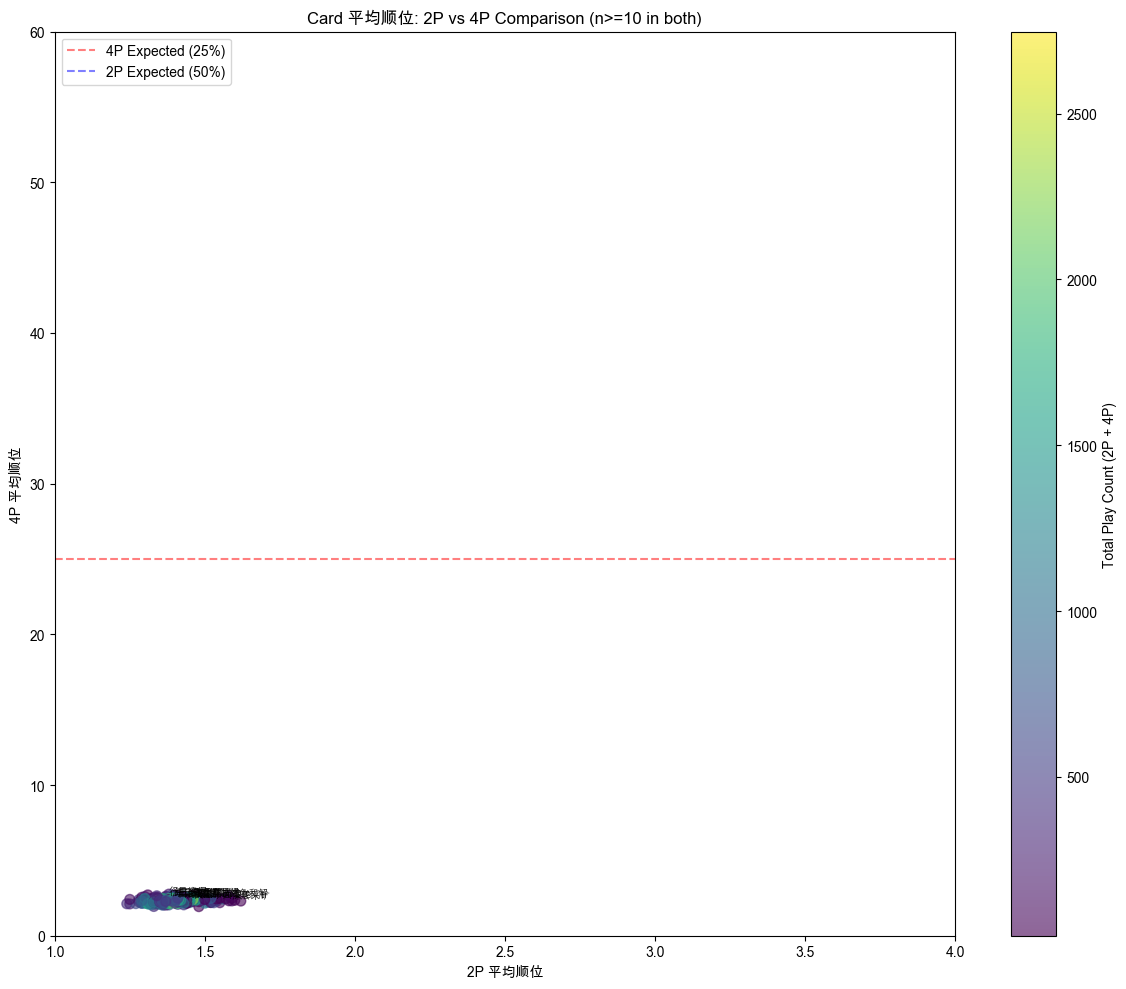

Saved: ./display/card_2p_vs_4p_scatter.png


In [32]:
# 7.3 Comparison: 2P vs 4P Weighted Score for Top Cards

if 'played_cards_df' in dir() and len(played_cards_df) > 0:
    # Get card stats for both 2P and 4P
    cards_2p = played_cards_df[((~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])) & (played_cards_df['players'] == 2)].copy()
    cards_4p = played_cards_df[((~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])) & (played_cards_df['players'] == 4)].copy()

    if len(cards_2p) > 0 and len(cards_4p) > 0:
        # Calculate stats
        stats_2p = cards_2p.groupby('card_name').agg(
            play_count_2p=('game_id', 'count'),
            total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
        ).reset_index()
        stats_2p = add_bayesian_weighted_avg(stats_2p, prior_mean=1.5)
        stats_2p['weighted_2p'] = stats_2p['weighted_avg_score'].round(2)

        stats_4p = cards_4p.groupby('card_name').agg(
            play_count_4p=('game_id', 'count'),
            total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
        ).reset_index()
        stats_4p = add_bayesian_weighted_avg(stats_4p, prior_mean=2.5)
        stats_4p['weighted_4p'] = stats_4p['weighted_avg_score'].round(2)

        # Merge
        comparison = stats_2p.merge(stats_4p, on='card_name', how='inner')
        comparison = comparison[(comparison['play_count_2p'] >= MIN_SAMPLE_SIZE) &
                                (comparison['play_count_4p'] >= MIN_SAMPLE_SIZE)]

        # Add cn_name
        comparison = add_cn_name_column(comparison, 'card_name', CN_MAP)

        # Calculate normalized win rate (relative to expected)
        comparison['wr_diff_2p'] = comparison['weighted_2p'] - 1.5  # 2P expected 平均顺位 1.5
        comparison['wr_diff_4p'] = comparison['weighted_4p'] - 2.5  # 4P expected 平均顺位 2.5
        comparison['total_diff'] = comparison['wr_diff_2p'] + comparison['wr_diff_4p']

        # Save comparison
        comparison.to_csv(f'{DISPLAY_DIR}/card_2p_vs_4p_comparison.csv', index=False)
        print(f"Saved: {DISPLAY_DIR}/card_2p_vs_4p_comparison.csv ({len(comparison)} rows)")

        # Visualization: Scatter plot comparing 2P vs 4P win rates
        fig, ax = plt.subplots(figsize=(12, 10))

        scatter = ax.scatter(
            comparison['weighted_2p'],
            comparison['weighted_4p'],
            c=comparison['play_count_2p'] + comparison['play_count_4p'],
            cmap='viridis',
            s=50,
            alpha=0.6
        )

        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Total Play Count (2P + 4P)')

        # Add reference lines
        ax.axhline(y=25, color='red', linestyle='--', alpha=0.5, label='4P Expected (25%)')
        ax.axvline(x=50, color='blue', linestyle='--', alpha=0.5, label='2P Expected (50%)')

        # Label top performers
        top_overall = comparison.nlargest(10, 'total_diff')
        for _, row in top_overall.iterrows():
            ax.annotate(
                row['cn_name_plot'][:12],
                (row['weighted_2p'], row['weighted_4p']),
                fontsize=7,
                alpha=0.8
            )

        ax.set_xlabel('2P 平均顺位')
        ax.set_ylabel('4P 平均顺位')
        ax.set_title(f'Card 平均顺位: 2P vs 4P Comparison (n>={MIN_SAMPLE_SIZE} in both)')
        ax.legend(loc='upper left')
        ax.set_xlim(1, 4)
        ax.set_ylim(0, 60)

        plt.tight_layout()
        plt.savefig(f'{DISPLAY_DIR}/card_2p_vs_4p_scatter.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {DISPLAY_DIR}/card_2p_vs_4p_scatter.png")

Saved: ./display/prelude_2p_vs_4p_comparison.csv (84 rows)


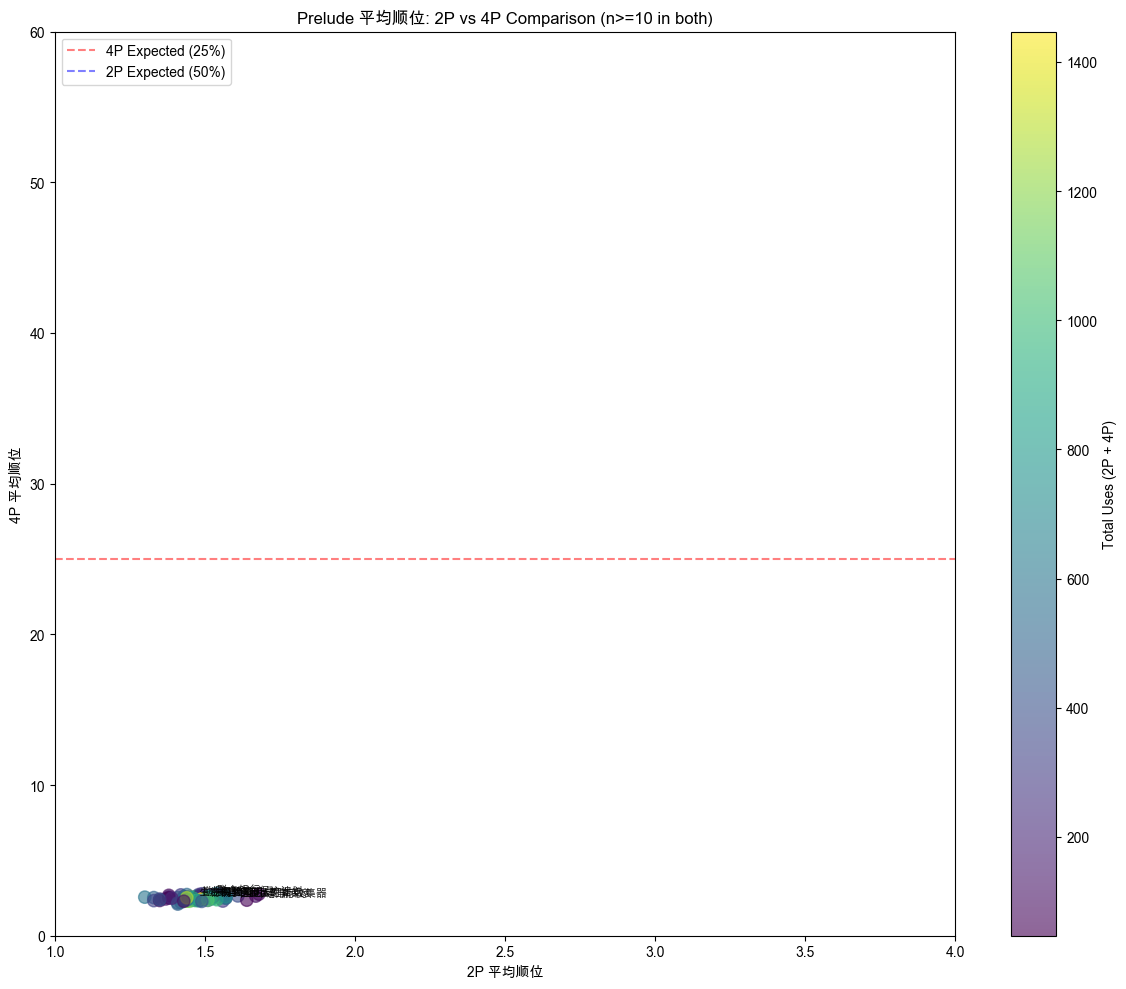

Saved: ./display/prelude_2p_vs_4p_scatter.png


In [33]:
# 7.4 Comparison: 2P vs 4P Weighted Score for Preludes

if 'prelude_df' in dir() and len(prelude_df) > 0:
    # Get prelude stats for both 2P and 4P
    prelude_2p = prelude_df[prelude_df['players'] == 2].copy()
    prelude_4p = prelude_df[prelude_df['players'] == 4].copy()

    if len(prelude_2p) > 0 and len(prelude_4p) > 0:
        # Calculate stats
        stats_2p = prelude_2p.groupby('prelude_name').agg(
            uses_2p=('game_id', 'count'),
            total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
        ).reset_index()
        stats_2p = add_bayesian_weighted_avg(stats_2p, prior_mean=1.5)
        stats_2p['weighted_2p'] = stats_2p['weighted_avg_score'].round(2)

        stats_4p = prelude_4p.groupby('prelude_name').agg(
            uses_4p=('game_id', 'count'),
            total_weighted=('weighted_score', 'sum'), count_weighted=('weighted_score', 'count')
        ).reset_index()
        stats_4p = add_bayesian_weighted_avg(stats_4p, prior_mean=2.5)
        stats_4p['weighted_4p'] = stats_4p['weighted_avg_score'].round(2)

        # Merge
        comparison = stats_2p.merge(stats_4p, on='prelude_name', how='inner')
        comparison = comparison[(comparison['uses_2p'] >= MIN_SAMPLE_SIZE) &
                                (comparison['uses_4p'] >= MIN_SAMPLE_SIZE)]

        # Add cn_name
        comparison = add_cn_name_column(comparison, 'prelude_name', CN_MAP)

        # Calculate normalized win rate
        comparison['wr_diff_2p'] = comparison['weighted_2p'] - 50
        comparison['wr_diff_4p'] = comparison['weighted_4p'] - 25
        comparison['total_diff'] = comparison['wr_diff_2p'] + comparison['wr_diff_4p']

        # Save comparison
        comparison.to_csv(f'{DISPLAY_DIR}/prelude_2p_vs_4p_comparison.csv', index=False)
        print(f"Saved: {DISPLAY_DIR}/prelude_2p_vs_4p_comparison.csv ({len(comparison)} rows)")

        # Visualization: Scatter plot
        fig, ax = plt.subplots(figsize=(12, 10))

        scatter = ax.scatter(
            comparison['weighted_2p'],
            comparison['weighted_4p'],
            c=comparison['uses_2p'] + comparison['uses_4p'],
            cmap='viridis',
            s=80,
            alpha=0.6
        )

        cbar = plt.colorbar(scatter)
        cbar.set_label('Total Uses (2P + 4P)')

        ax.axhline(y=25, color='red', linestyle='--', alpha=0.5, label='4P Expected (25%)')
        ax.axvline(x=50, color='blue', linestyle='--', alpha=0.5, label='2P Expected (50%)')

        # Label top performers
        top_overall = comparison.nlargest(10, 'total_diff')
        for _, row in top_overall.iterrows():
            ax.annotate(
                row['cn_name_plot'][:12],
                (row['weighted_2p'], row['weighted_4p']),
                fontsize=8,
                alpha=0.8
            )

        ax.set_xlim(1, 2)
        ax.set_xlabel('2P 平均顺位')
        ax.set_ylim(1, 4)
        ax.set_ylabel('4P 平均顺位')
        ax.set_title(f'Prelude 平均顺位: 2P vs 4P Comparison (n>={MIN_SAMPLE_SIZE} in both)')
        ax.legend(loc='upper left')
        ax.set_xlim(1, 4)
        ax.set_ylim(0, 60)

        plt.tight_layout()
        plt.savefig(f'{DISPLAY_DIR}/prelude_2p_vs_4p_scatter.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {DISPLAY_DIR}/prelude_2p_vs_4p_scatter.png")